In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import sys
#path = r"/Users/constantinslioussarenko/PythonGitRepositories/MyoMap"
path = r"/home/cslioussarenko/PythonRepositories"
sys.path.append(path+"/epgpy")
sys.path.append(path+"/machines")
sys.path.append(path+"/mutools")
sys.path.append(path+"/dicomstack")
sys.path.append(path+"/mrf-sim")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from dictoptimizers import SimpleDictSearch
from utils_mrf import *
import json
import readTwix as rT
import time
import os
from numpy.lib.format import open_memmap
from numpy import memmap
import pickle

base_folder = "../data/InVivo/3D"
localfile = "/20220106_JM/meas_MID00180_FID48490_raFin_3D_tra_1x1x5mm_FULL_new.dat"
localfile = "/20220113_CS/meas_MID00163_FID49558_raFin_3D_tra_1x1x5mm_FULL_50GS_read.dat"
#localfile = "/20220113_CS/meas_MID00164_FID49559_raFin_3D_tra_1x1x5mm_FULL_50GS_slice.dat"
localfile = "/20220118_BM/meas_MID00151_FID49924_raFin_3D_tra_1x1x5mm_FULL_read_nav.dat"
localfile="/phantom.001.v1/phantom.001.v1.dat"

import twixtools
%matplotlib inline

def calculate_sensitivity_map_3D_for_nav(kdata,trajectory,res=16,image_size=(400,)):
    traj=trajectory.get_traj()
    nb_channels=kdata.shape[0]
    npoint=kdata.shape[-1]
    nb_slices=kdata.shape[1]
    nb_gating_spokes=kdata.shape[2]
    center_res = int(npoint / 2 - 1)
    kdata=kdata.reshape((nb_channels,-1,npoint))
    b1_nav=np.zeros((nb_channels,kdata.shape[1],)+nav_image_size,dtype=np.complex128)
    kdata_for_sensi = np.zeros(kdata.shape[1:], dtype=np.complex128)
    for i in tqdm(range(nb_channels)):
        kdata_for_sensi[:, (center_res - int(res / 2)):(center_res + int(res / 2))] = kdata[i,:,(center_res - int(res / 2)):(center_res + int(res / 2))]
        b1_nav[i] = finufft.nufft1d1(traj[0,:,2], kdata_for_sensi, image_size)

        print("Normalizing sensi")

        #b1 = coil_sensitivity / np.linalg.norm(coil_sensitivity, axis=0)
        #del coil_sensitivity
        #b1 = b1 / np.max(np.abs(b1.flatten()))
    b1_nav /= np.linalg.norm(b1_nav, axis=0)
    b1_nav /= np.max(np.abs(b1_nav.flatten()))

    b1_nav=b1_nav.reshape((nb_channels,nb_slices,nb_gating_spokes,int(npoint/2)))
    return b1_nav

def simulate_nav_images_multi(kdata,trajectory,image_size=(400,),b1=None):
    traj=trajectory.get_traj()
    nb_channels=kdata.shape[0]
    npoint=kdata.shape[-1]
    nb_slices=kdata.shape[1]
    nb_gating_spokes=kdata.shape[2]
    
    if b1 is not None:
        if b1.ndim==2:
            b1=np.expand_dims(b1,axis=(1,2))
        elif b1.ndim==3:
            b1=np.expand_dims(b1,axis==(1))
    
    traj=traj.astype(np.float32)
    
    kdata=kdata.reshape((nb_channels,-1,npoint))
    images_series_rebuilt_nav = np.zeros((nb_slices,nb_gating_spokes,int(npoint/2)),dtype=np.complex64)
    #all_channels_images_nav = np.zeros((nb_channels,nb_slices,nb_gating_spokes,int(npoint/2)),dtype=np.complex64)

    for i in tqdm(range(nb_channels)):
        fk = finufft.nufft1d1(traj[0,:,2], kdata[i, :, :], image_size)
        fk = fk.reshape((nb_slices,nb_gating_spokes,int(npoint/2)))

        #all_channels_images_nav[i]=fk

        if b1 is None:
            images_series_rebuilt_nav += np.abs(fk) ** 2
        else:
            images_series_rebuilt_nav += b1[i].conj() *fk

    if b1 is None:
        images_series_rebuilt_nav = np.sqrt(images_series_rebuilt_nav)
    
    return images_series_rebuilt_nav

def calculate_displacement(image,bottom,top,shifts):
    nb_gating_spokes=image.shape[1]
    nb_slices = image.shape[0]
    
    npoint_image= image.shape[-1]
    ft=np.mean(image,axis=0)
    #ft=np.mean(image_nav_best_channel,axis=0)
    #ft=image[0]
    image_nav_for_correl=image.reshape(-1,npoint_image)
    nb_images=image_nav_for_correl.shape[0]
    correls=[]
    #adj=[]
    for j in tqdm(range(nb_images)):
        corrs=np.zeros(len(shifts))
        
        for i,shift in enumerate(shifts):
            corr=np.corrcoef(np.concatenate([ft[j%nb_gating_spokes,bottom:top].reshape(1,-1),image_nav_for_correl[j,bottom+shift:top+shift].reshape(1,-1)],axis=0))[0,1]
            #corr = np.linalg.norm(image_nav_for_correl[0, bottom:top]-image_nav_for_correl[j + 1, (bottom + shift):(top + shift)])
            corrs[i]=corr
        
        
        #adjustment=np.sum(dft_x[j+1]*dft_t[j])/np.sum(dft_x[j+1]**2)
        #adj.append(adjustment)
        correls.append(corrs)
    correls_array=np.array(correls)
    mvt=[shifts[i] for i in np.argmax(correls_array,axis=-1)]
    #mvt=[shifts[i] for i in np.argmin(correls_array,axis=-1)]
    #mvt=np.array(mvt)+np.array(adj)
    #mvt=np.concatenate([[0],mvt]).astype(int)
    #mvt=np.array(mvt).reshape(int(nb_slices),int(nb_gating_spokes))
    #displacement=-np.cumsum(mvt,axis=-1).flatten()
    displacement = np.array(mvt)
    return displacement,correls_array


In [2]:
filename = base_folder+localfile

#filename="./data/InVivo/3D/20211221_EV_MRF/meas_MID00043_FID42065_raFin_3D_tra_1x1x5mm_us2_vivo.dat"
#filename="./data/InVivo/3D/20211119_EV_MRF/meas_MID00043_FID42065_raFin_3D_tra_1x1x5mm_us2_vivo.dat"
#filename="./data/InVivo/3D/20211119_EV_MRF/meas_MID00043_FID42065_raFin_3D_tra_1x1x5mm_us2_vivo.dat"

filename_save=str.split(filename,".dat") [0]+".npy"
filename_nav_save=str.split(filename,".dat") [0]+"_nav.npy"

folder = "/".join(str.split(filename,"/")[:-1])


filename_b1 = str.split(filename,".dat") [0]+"_b1.npy"
filename_seqParams = str.split(filename,".dat") [0]+"_seqParams.pkl"

filename_volume = str.split(filename,".dat") [0]+"_volumes.npy"
filename_kdata = str.split(filename,".dat") [0]+"_kdata.npy"
filename_mask= str.split(filename,".dat") [0]+"_mask.npy"


In [3]:

use_GPU = False
light_memory_usage=True

In [4]:
file = open(filename_seqParams, "rb")
dico_seqParams = pickle.load(file)
file.close()


In [5]:
use_navigator_dll=dico_seqParams["use_navigator_dll"]

if use_navigator_dll:
    meas_sampling_mode=dico_seqParams["alFree"][14]
    nb_gating_spokes = dico_seqParams["alFree"][6]
else:
    meas_sampling_mode = dico_seqParams["alFree"][12]
    nb_gating_spokes = 0

if nb_gating_spokes>0:
    meas_orientation =  dico_seqParams["alFree"][11]
    if meas_orientation==1:
        nav_direction = "READ"
    elif meas_orientation==2:
        nav_direction = "PHASE"
    elif meas_orientation==3:
        nav_direction = "SLICE"

nb_segments = dico_seqParams["alFree"][4]

x_FOV = dico_seqParams["x_FOV"]
y_FOV = dico_seqParams["y_FOV"]
z_FOV = dico_seqParams["z_FOV"]
nb_part = dico_seqParams["nb_part"]

In [6]:
nb_allspokes=nb_segments
undersampling_factor=1

In [7]:
data_for_nav=np.load(filename_nav_save)

In [8]:
data_for_nav.shape

(1, 16, 50, 800)

In [9]:
npoint = data_for_nav.shape[-1]
nb_slices=data_for_nav.shape[1]
nb_channels=data_for_nav.shape[0]

In [10]:
all_timesteps = np.arange(nb_allspokes)
nav_timesteps=all_timesteps[::int(nb_allspokes/nb_gating_spokes)]

nav_traj=Navigator3D(direction=[0,0,1],npoint=npoint,nb_slices=nb_slices,applied_timesteps=list(nav_timesteps))
#test_traj = nav_traj.get_traj()

nav_image_size = (int(npoint/2),)

In [11]:
b1_nav = calculate_sensitivity_map_3D_for_nav(data_for_nav,nav_traj,res=16,image_size=nav_image_size)

100%|██████████| 1/1 [00:00<00:00, 29.65it/s]

Normalizing sensi


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


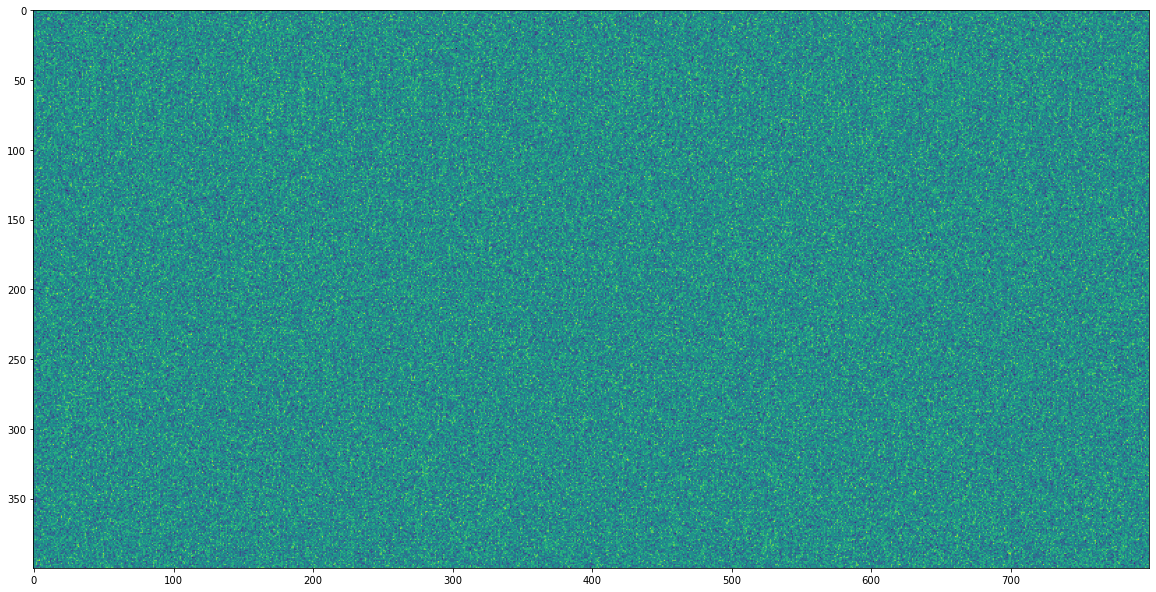

In [12]:
ch=0
plt.figure(figsize=(20,30))
plt.imshow(np.abs(np.expand_dims(b1_nav[ch].reshape(-1,int(npoint/2)).T,axis=-1)))

In [13]:
b1_nav_0 = b1_nav[:,0,0,:]
b1_nav_mean=np.mean(b1_nav,axis=(1,2))

## Tests to run

1. Image best channel (window 80-120,50-150,20-380)
2. Image all channels b1 None (window 80-120,50-150,20-380)
3. Image all channels b1 mean (window 80-120,50-150,20-380)

Output : 
- Displacement
- Plot displacement all reps
- Plot displacement 5:10
- Plot displacement 43:48
- Plot correlation and images and pathological case


In [155]:
displacements_all={}
correls_all={}
shifts=list(range(-25,25))

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Image best channel

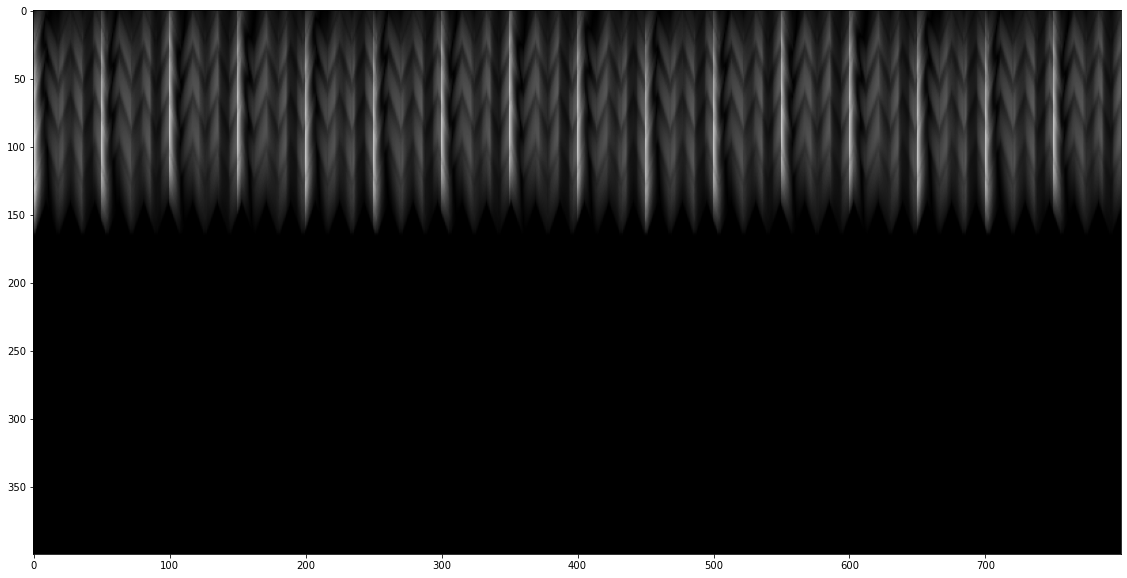

In [157]:
image_nav_ch=image_nav_all_channels[0]
plt.figure(figsize=(40,10))
plt.imshow(image_nav_ch.reshape(-1, int(npoint / 2)).T, cmap="gray")

In [158]:
image_nav_all_channels=[]
for j in range(nb_channels):
    images_series_rebuilt_nav_ch = simulate_nav_images_multi(np.expand_dims(data_for_nav[j],axis=0), nav_traj, nav_image_size, b1=None)
    image_nav_ch = np.abs(images_series_rebuilt_nav_ch)
    # plt.figure()
    #plt.imshow(image_nav_ch.reshape(-1, int(npoint / 2)).T, cmap="gray")
    #plt.title("Image channel {}".format(j))
    image_nav_all_channels.append(image_nav_ch)
#plt.close("all")
image_nav_all_channels=np.array(image_nav_all_channels)
image_nav_best_channel = image_nav_all_channels[0]

100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


In [159]:
image=image_nav_best_channel
series="best_channel"

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
bottom=80
top=120
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:02<00:00, 282.22it/s]


In [161]:
bottom=50
top=150
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:02<00:00, 270.63it/s]


In [162]:
bottom=25
top=375
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:03<00:00, 263.49it/s]


# Image combined no b1 map

In [163]:
images_nav_none=np.abs(simulate_nav_images_multi(data_for_nav,nav_traj,nav_image_size,None))

100%|██████████| 1/1 [00:00<00:00, 36.92it/s]


In [164]:
image=images_nav_none
series="b1_none"

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [165]:
bottom=80
top=120
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:02<00:00, 282.19it/s]


In [166]:
bottom=50
top=150
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:02<00:00, 273.74it/s]


In [167]:
bottom=25
top=375
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:03<00:00, 266.42it/s]


## Image combined b1 mean along time

In [168]:
images_nav_mean=np.abs(simulate_nav_images_multi(data_for_nav,nav_traj,nav_image_size,b1_nav_mean))

100%|██████████| 1/1 [00:00<00:00, 34.37it/s]


In [169]:
image=images_nav_mean
series="b1_mean"

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
bottom=80
top=120
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:02<00:00, 282.25it/s]


In [171]:
bottom=50
top=150
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

100%|██████████| 800/800 [00:02<00:00, 269.06it/s]


In [182]:
bottom=25
top=375
key="{}_{}_{}".format(series,bottom,top)
displacements_all[key],correls_all[key]=calculate_displacement(image,bottom,top,shifts)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 800/800 [00:03<00:00, 265.98it/s]


In [173]:
displacements_all.keys()

dict_keys(['best_channel_80_120', 'best_channel_50_150', 'best_channel_25_375', 'b1_none_80_120', 'b1_none_50_150', 'b1_none_25_375', 'b1_mean_80_120', 'b1_mean_50_150', 'b1_mean_35_375'])

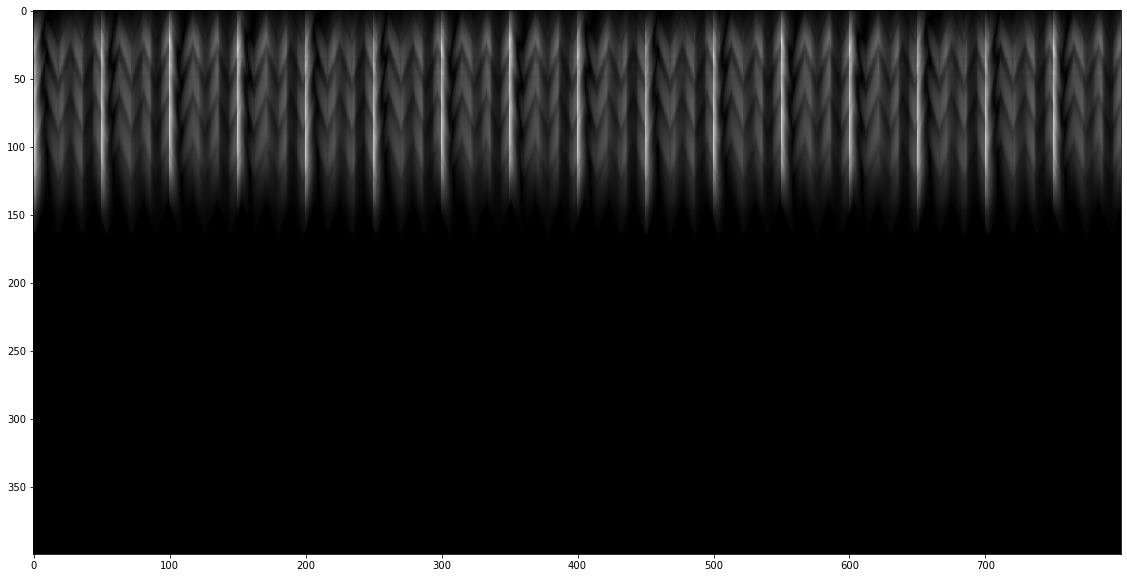

In [174]:
plt.figure(figsize=(40,10))
plt.imshow(images_nav_mean.reshape(-1,int(npoint/2)).T,cmap="gray")

## Comparisons

### Displacement plot

In [175]:
images_all={"best_channel":image_nav_best_channel,"b1_none":images_nav_none,"b1_mean":images_nav_mean}

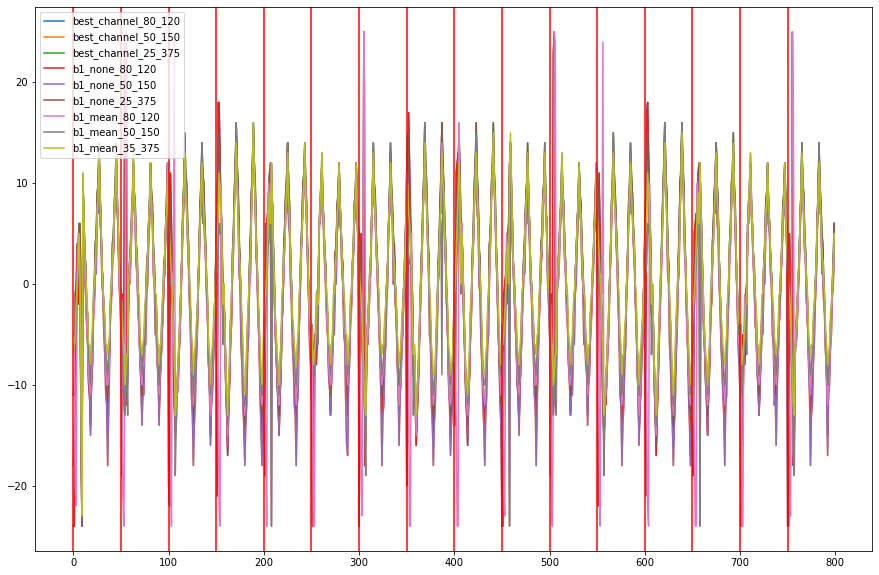

In [176]:
start_cycle=0
end_cycle = nb_slices

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


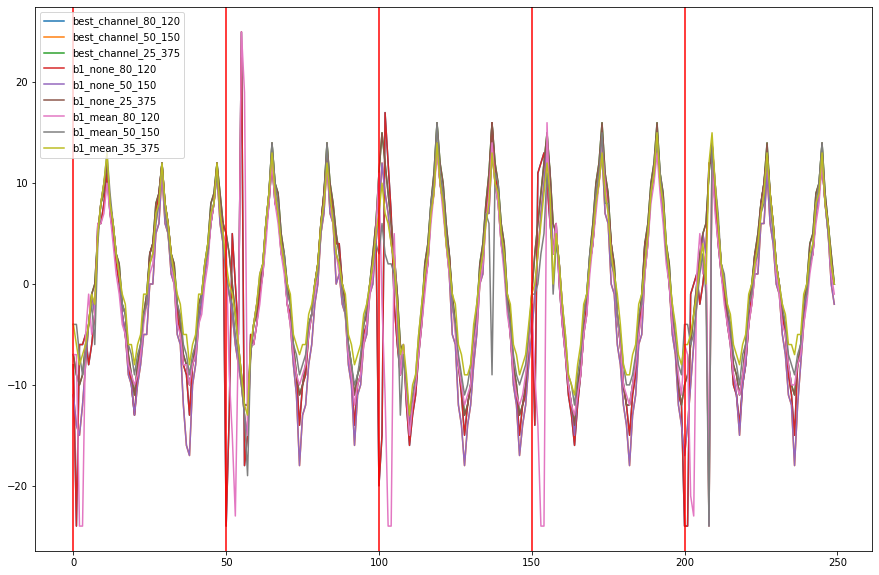

In [177]:
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


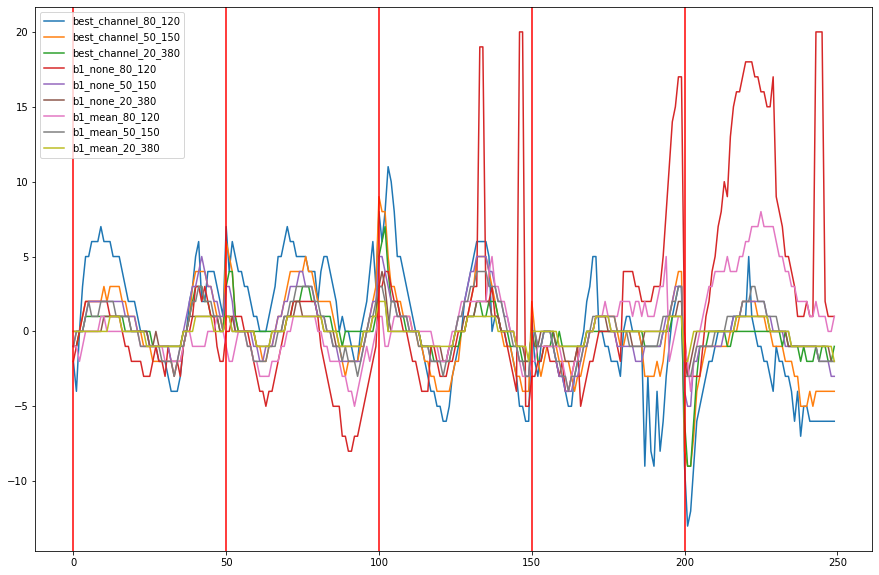

In [55]:
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


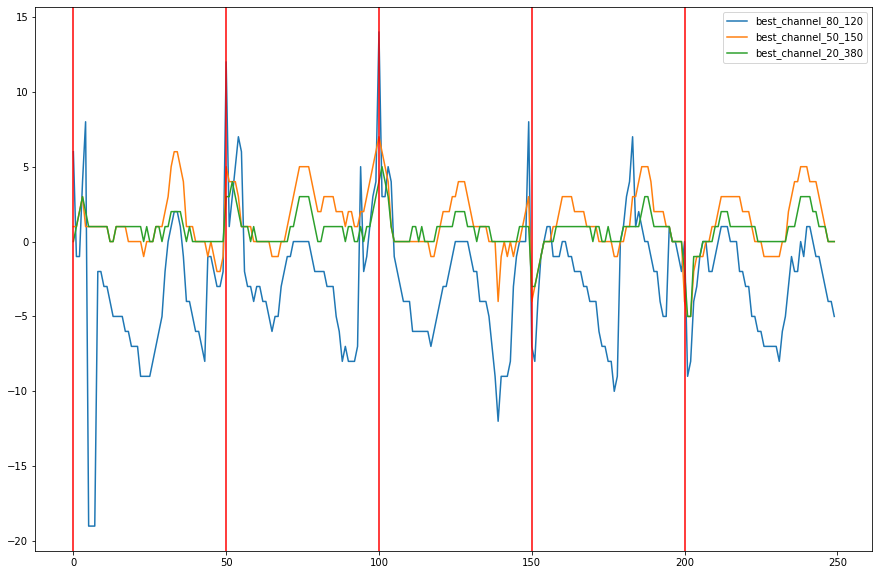

In [56]:
key="best_channel"
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


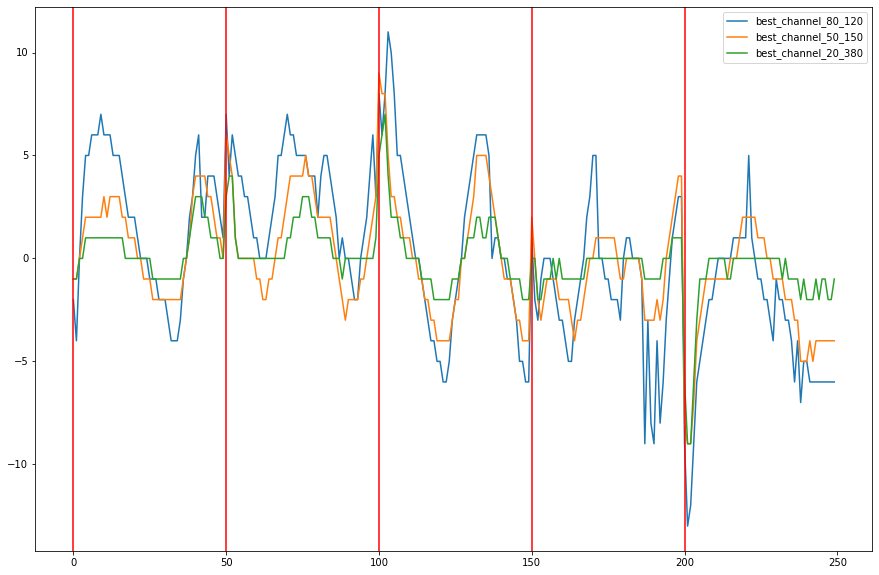

In [57]:
key="best_channel"
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


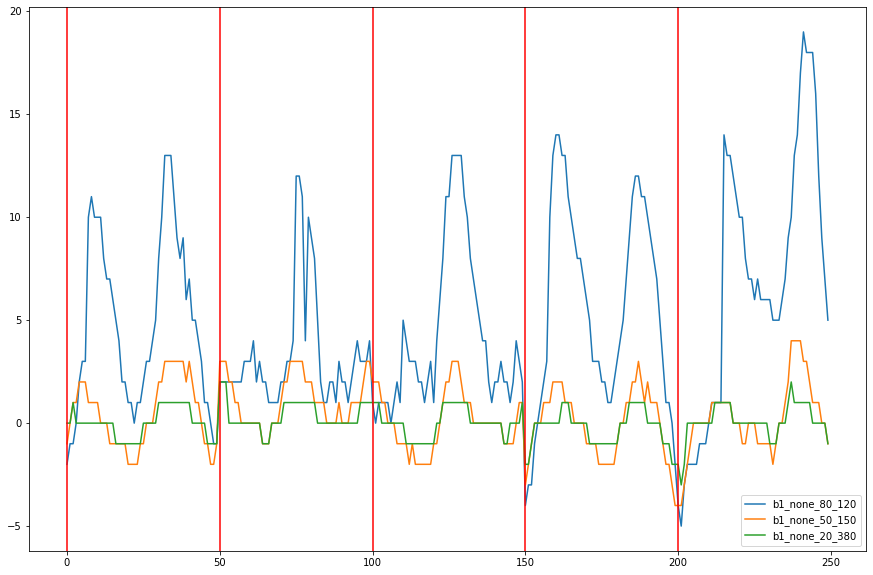

In [58]:
key="b1_none"
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


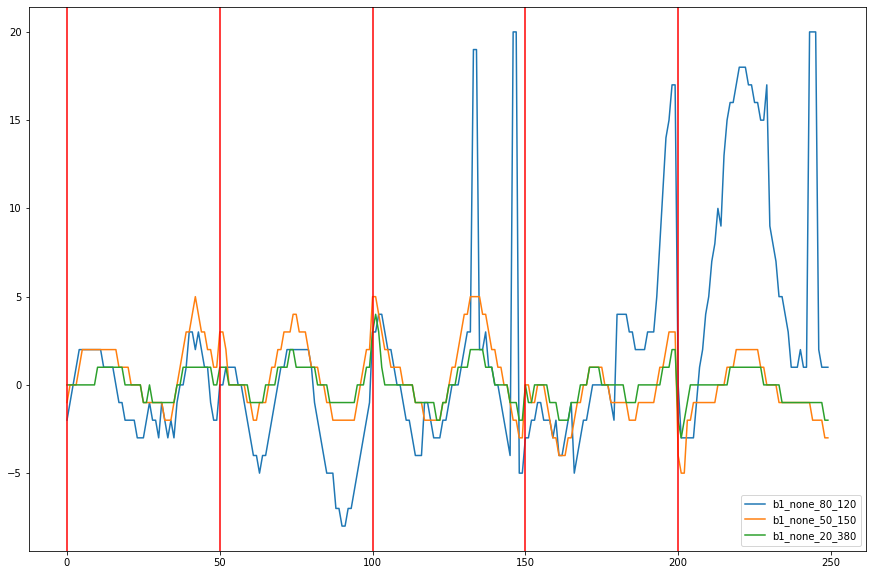

In [59]:
key="b1_none"
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

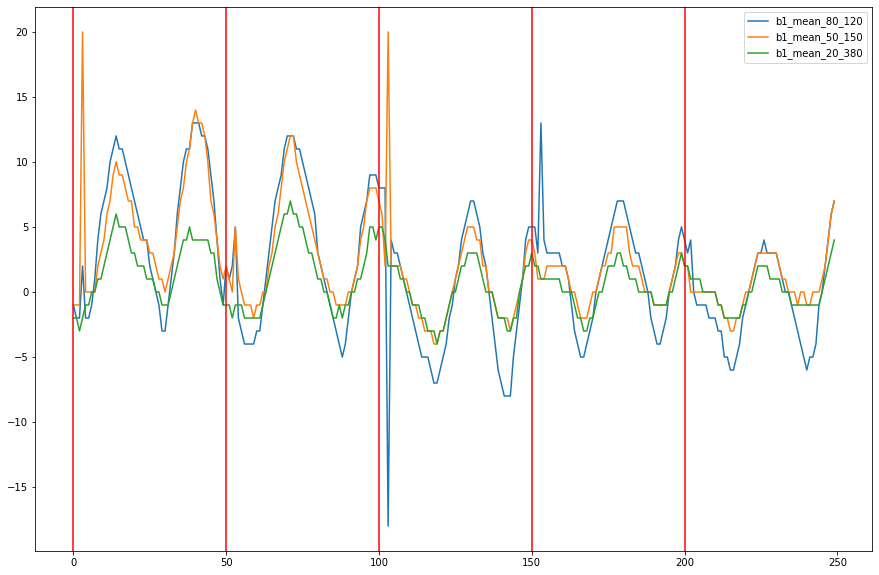

In [52]:
key="b1_mean"
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

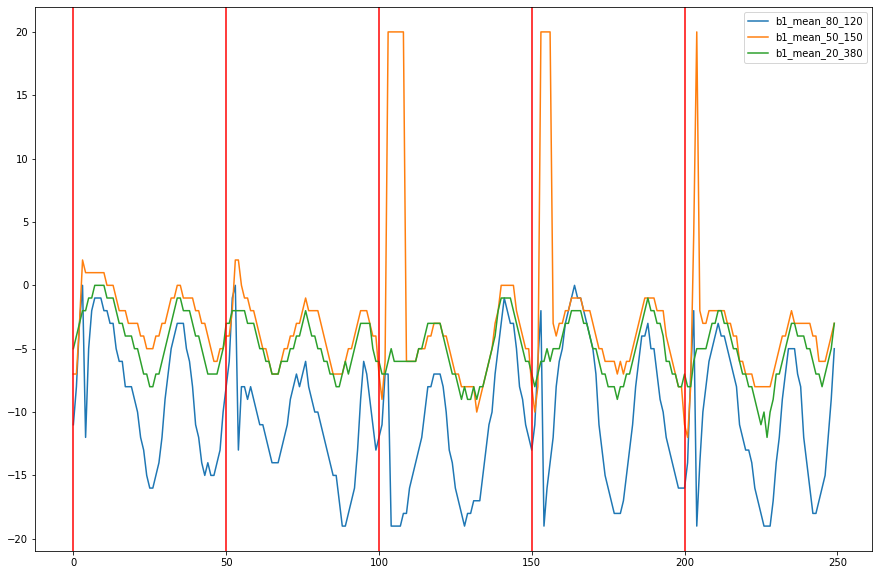

In [53]:
key="b1_mean"
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

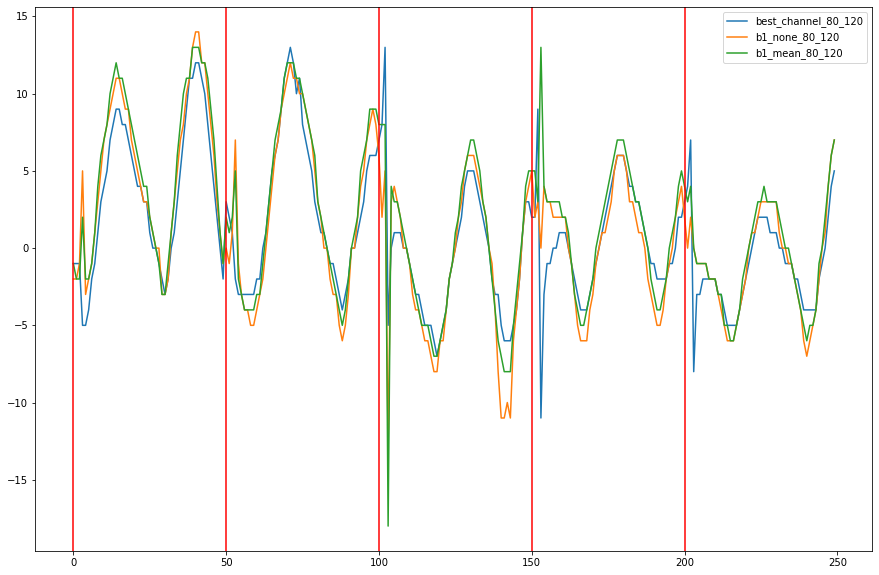

In [54]:
key="80_120"
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

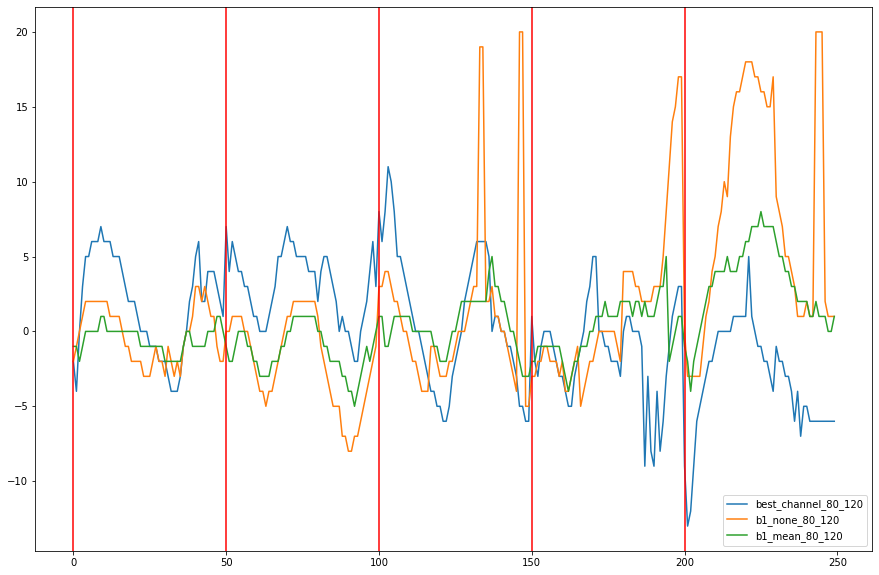

In [65]:
key="80_120"
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


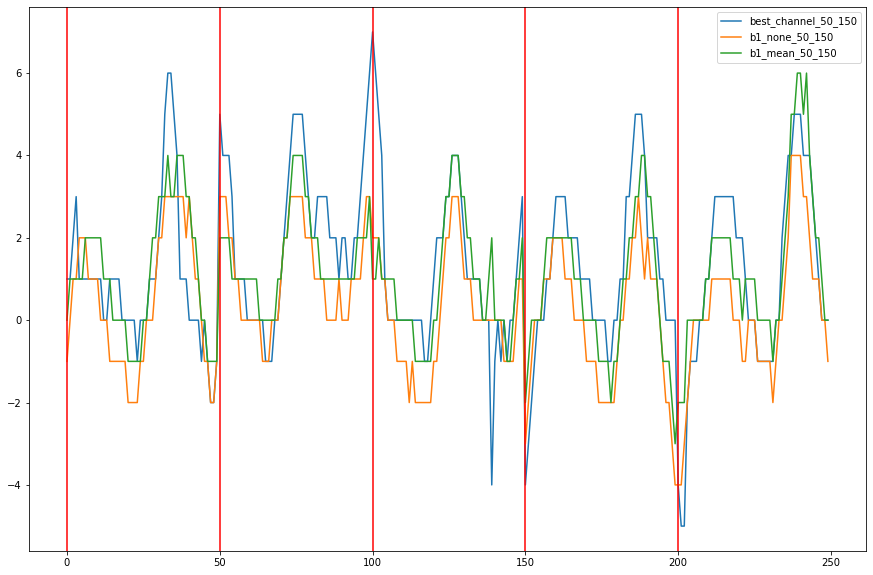

In [66]:
key="50_150"
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


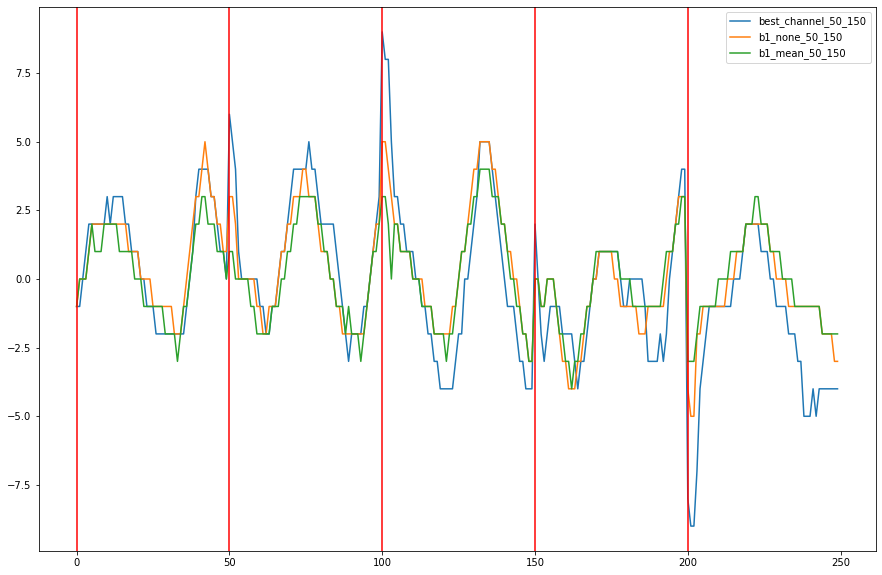

In [67]:
key="50_150"
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

best_channel_25_375
b1_none_25_375
b1_mean_25_375


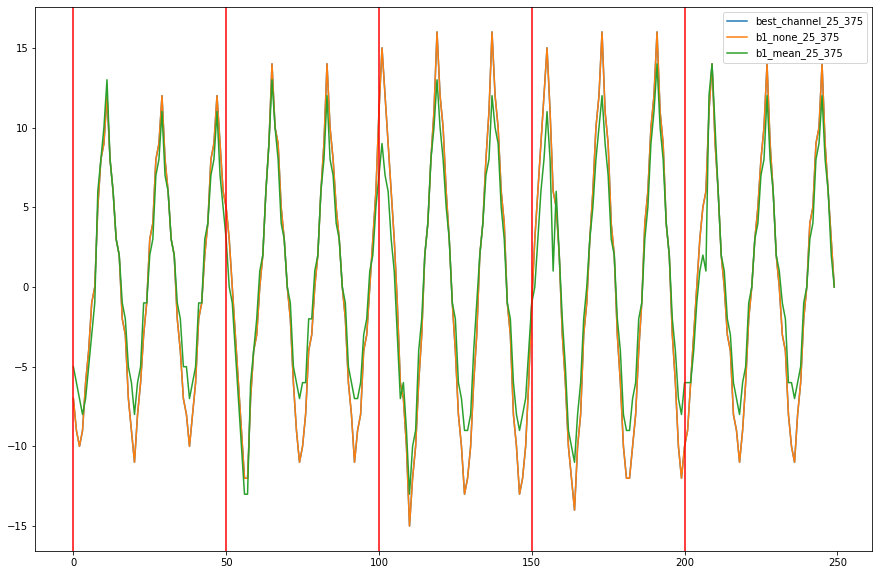

In [183]:
key="25_375"
start_cycle=5
end_cycle = 10

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        print(k)
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


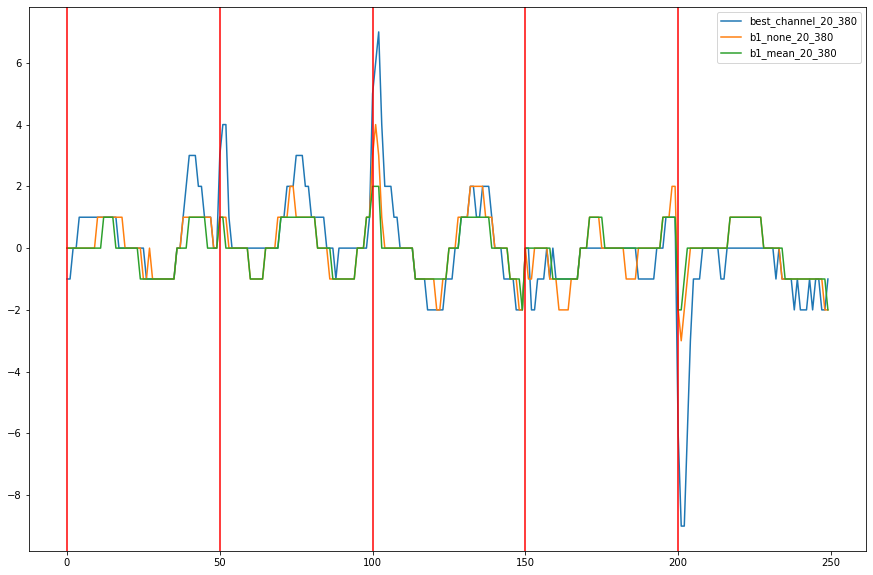

In [69]:
key="20_380"
start_cycle=43
end_cycle = 48

plt.figure(figsize=(15,10))
for k in displacements_all.keys():
    if key in k:
        plt.plot(-displacements_all[k][(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)],label=k)


for j in range(end_cycle-start_cycle):
    plt.axvline(x=j * nb_gating_spokes, color="r")
    
plt.legend()

Conclusion :
Taking as window the whole image removes sharp movement peaks due to insufficient signal. b1_mean and b1_none are of course preferable and largely correlated, however b1_mean looks a bit smoother. However the amplitude of movement is reduced.

### Correlation of shifted nav images with fingerprint

In [184]:
def plot_correls(correls_array_for_plot,inc=10):
    plot_index_prev=0
    plot_index=inc
    while plot_index<correls_array_for_plot.shape[0]+inc:
        print(plot_index)
        plt.figure()
        plt.plot(correls_array_for_plot[plot_index_prev:np.minimum(plot_index,correls_array.shape[0]),:].T)
        plot_index_prev=plot_index
        plot_index=plot_index+inc
    plt.figure()
    plt.plot(np.mean(correls_array_for_plot,axis=0))
    plt.title("{} : Mean correl with fingerprint".format(key))
    print("Spoke where mean correl is minimum : {}".format(np.argmin(np.mean(correls_array_for_plot,axis=0))))
    print("Spoke where mean correl is maximum : {}".format(np.argmax(np.mean(correls_array_for_plot,axis=0))))

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [185]:
correls_array_for_plot.shape

(16, 50)

10
20
Spoke where mean correl is minimum : 4
Spoke where mean correl is maximum : 7


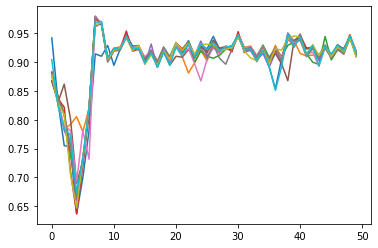

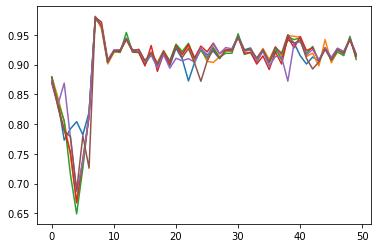

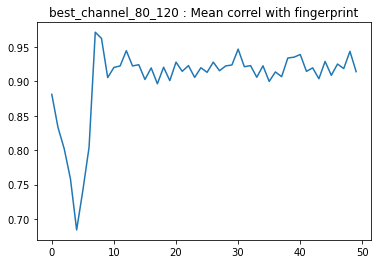

In [186]:
key="best_channel_80_120"
correls_array=correls_all[key]
correls_array_for_plot=np.max(correls_array,axis=-1).reshape(nb_slices,nb_gating_spokes)
plot_correls(correls_array_for_plot)

10
20
Spoke where mean correl is minimum : 9
Spoke where mean correl is maximum : 1


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


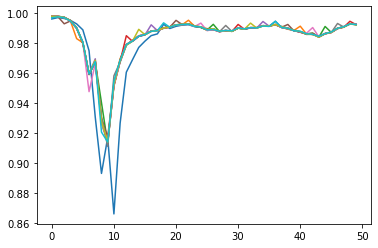

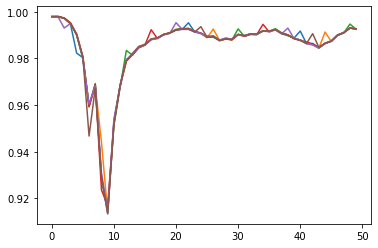

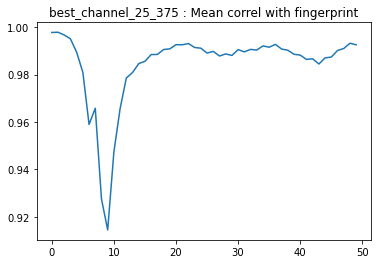

In [187]:
key="best_channel_25_375"
correls_array=correls_all[key]
correls_array_for_plot=np.max(correls_array,axis=-1).reshape(nb_slices,nb_gating_spokes)
plot_correls(correls_array_for_plot)

10
20
Spoke where mean correl is minimum : 9
Spoke where mean correl is maximum : 0


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


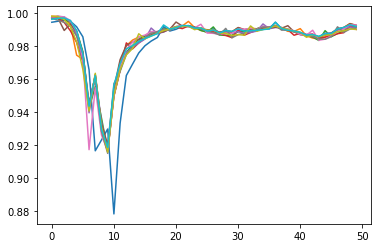

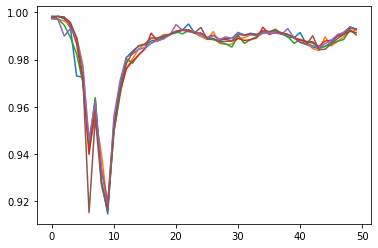

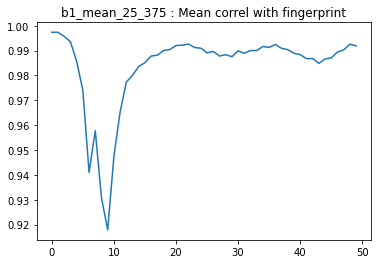

In [188]:
key="b1_mean_25_375"
correls_array=correls_all[key]
correls_array_for_plot=np.max(correls_array,axis=-1).reshape(nb_slices,nb_gating_spokes)
plot_correls(correls_array_for_plot)

10
20
Spoke where mean correl is minimum : 6
Spoke where mean correl is maximum : 1


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


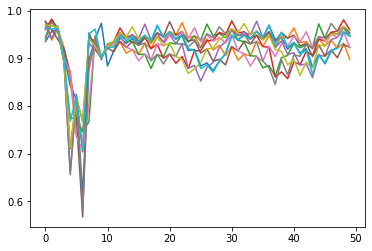

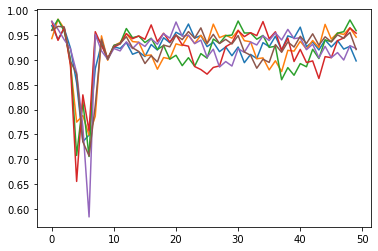

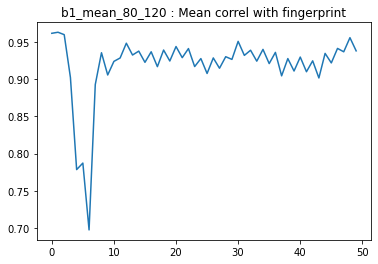

In [189]:
key="b1_mean_80_120"
correls_array=correls_all[key]
correls_array_for_plot=np.max(correls_array,axis=-1).reshape(nb_slices,nb_gating_spokes)
plot_correls(correls_array_for_plot)

10
20
Spoke where mean correl is minimum : 9
Spoke where mean correl is maximum : 1


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


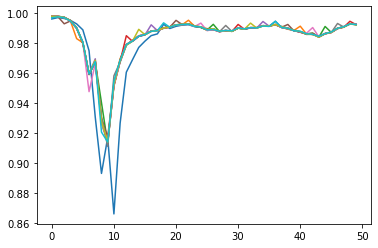

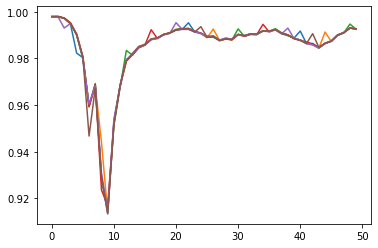

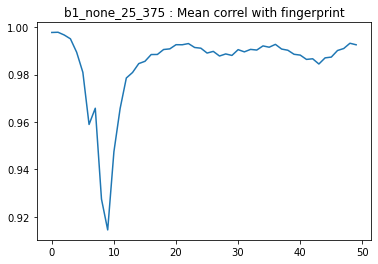

In [190]:
key="b1_none_25_375"
correls_array=correls_all[key]
correls_array_for_plot=np.max(correls_array,axis=-1).reshape(nb_slices,nb_gating_spokes)
plot_correls(correls_array_for_plot)

Conclusion :
By increasing the window, the max correl we can obtain with each fingerprint is increased on average. best_channel low correlation for spoke 2 somehow disappears when using all channels (no big difference between b1_none and b1_mean)

### Plot correl of adjusted images between repetitions of the same navigator

In [191]:

def plot_adjusted_images_vs_baseline(series,i,bottom,top):
    global displacements_all
    global images_all
    key="{}_{}_{}".format(series,bottom,top)
    displacement=displacements_all[key]
    image=images_all[series]

    image_for_adj=image.reshape(-1,image.shape[-1])
    image_adjusted=np.zeros((image_for_adj.shape[0],top-bottom))
    #print(image_nav_best_channel_adjusted.shape)
    for j in range(image_adjusted.shape[0]):
        image_adjusted[j,:]=image_for_adj[j,(bottom+displacement[j]):(top+displacement[j])]

    image_adjusted=image_adjusted.reshape(nb_slices,nb_gating_spokes,-1)
    
    plt.figure(figsize=(40,10))
    plt.imshow(image_adjusted[:,i,:],cmap="gray")
    plt.title("{} : Adjusted Image along partitions for gating spoke {}".format(key,i))
    plt.figure(figsize=(40,10))
    plt.imshow(image[:,i,bottom:top],cmap="gray")
    plt.title("Original Image along partitions for gating spoke {}".format(key,i))
    plt.figure(figsize=(10,10))
    sns.heatmap(np.corrcoef(image_adjusted[:,i,:]))
    plt.title("{} : Correlation of Adjusted Images accross partition".format(key))
    plt.figure(figsize=(10,10))
    sns.heatmap(np.corrcoef(image[:,i,bottom:top]))
    plt.title("{} : Correlation of Original Images accross partition".format(key))
    plt.figure()
    #plt.hist(np.corrcoef(image_adjusted[:,i,:]));
    sns.distplot(np.corrcoef(image_adjusted[:,i,:]),label="Adjusted")
    sns.distplot(np.corrcoef(image[:,i,bottom:top]),label="Original")
    plt.title("{} : Histogram of correlation of Original vs Adjusted Images accross partition".format(key))
    #plt.title("{} : Histogram of correlation of Adjusted Images accross partition".format(key))
    #plt.figure()
    #plt.hist(np.corrcoef(image[:,i,bottom:top]));
    #plt.title("{} : Histogram of correlation of Original vs Adjusted Images accross partition".format(key))
    plt.legend()
    
    


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [192]:
series="best_channel"


In [193]:
bottom=80
top=120

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


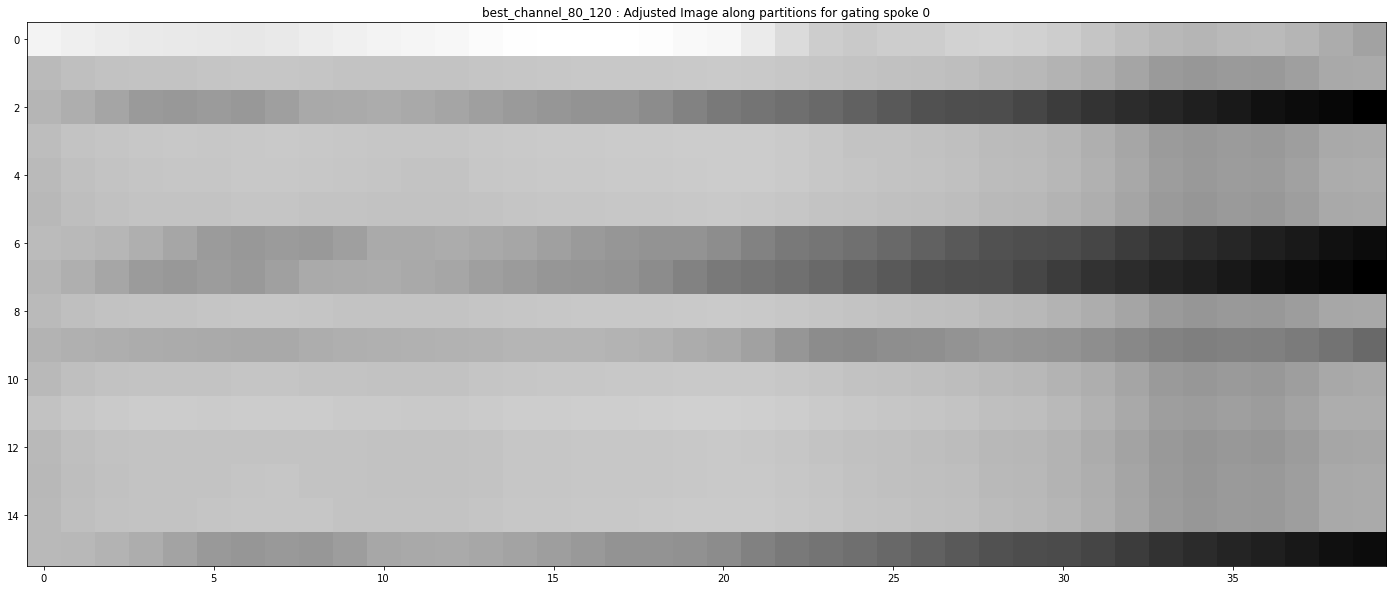

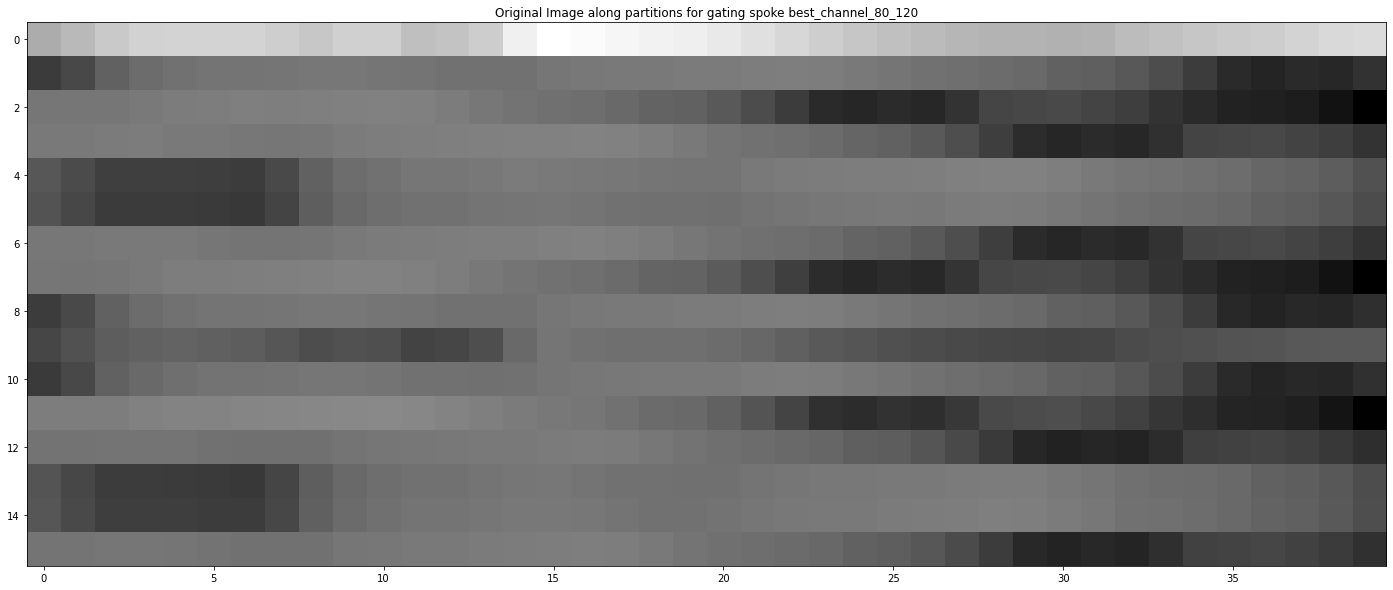

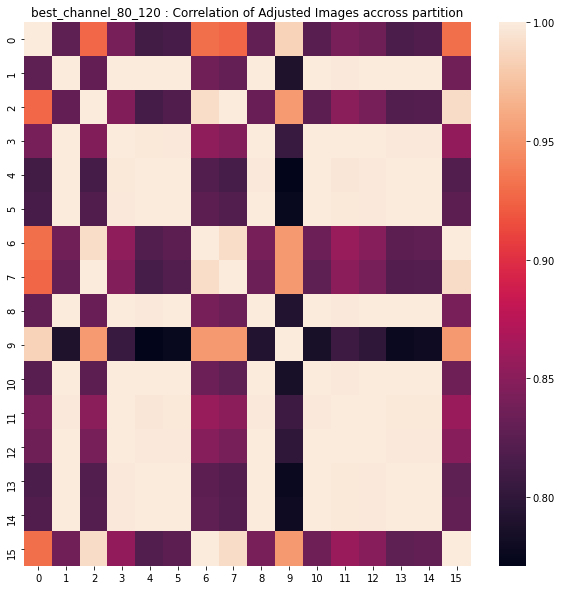

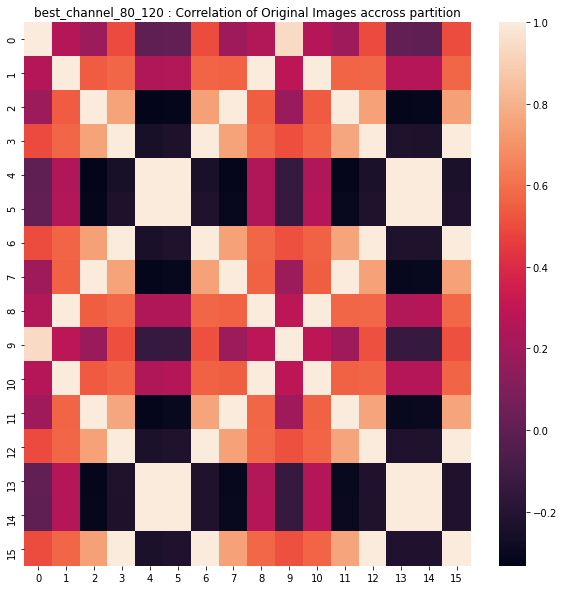

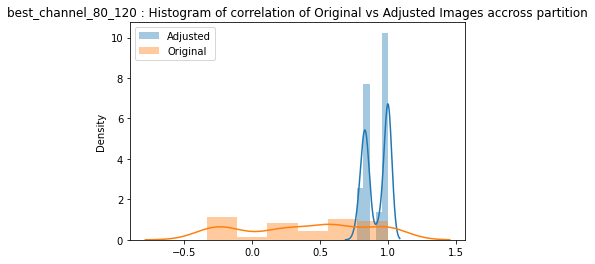

In [194]:
plot_adjusted_images_vs_baseline(series,0,bottom,top)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

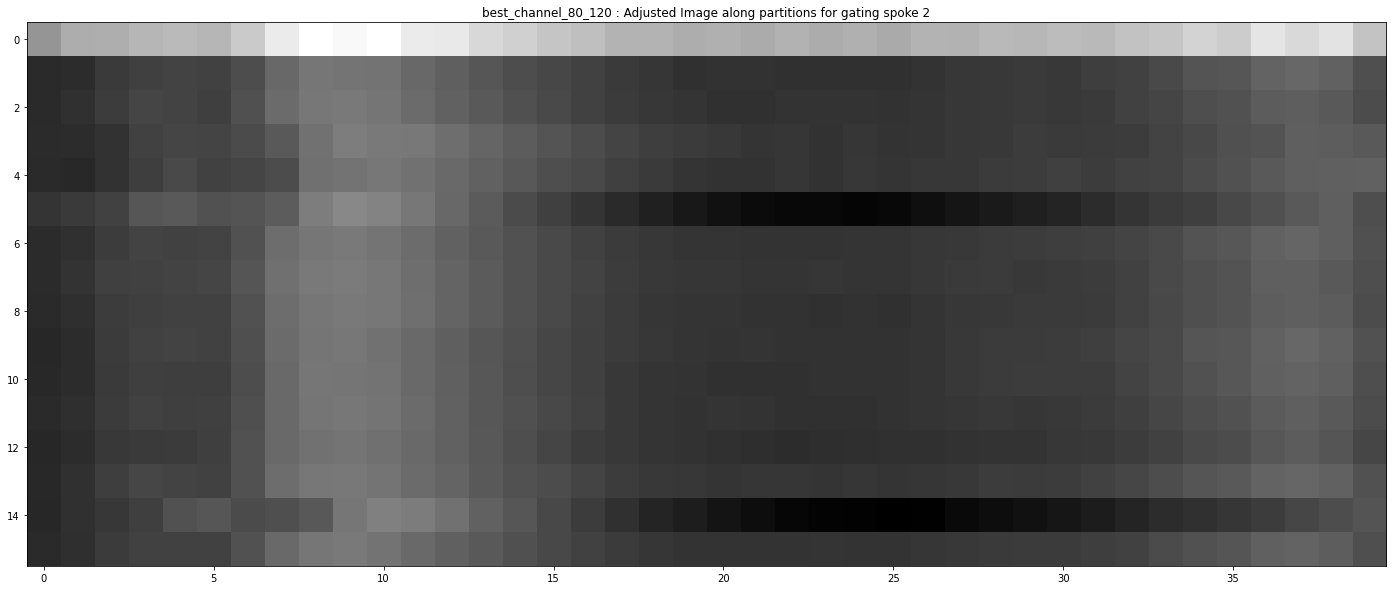

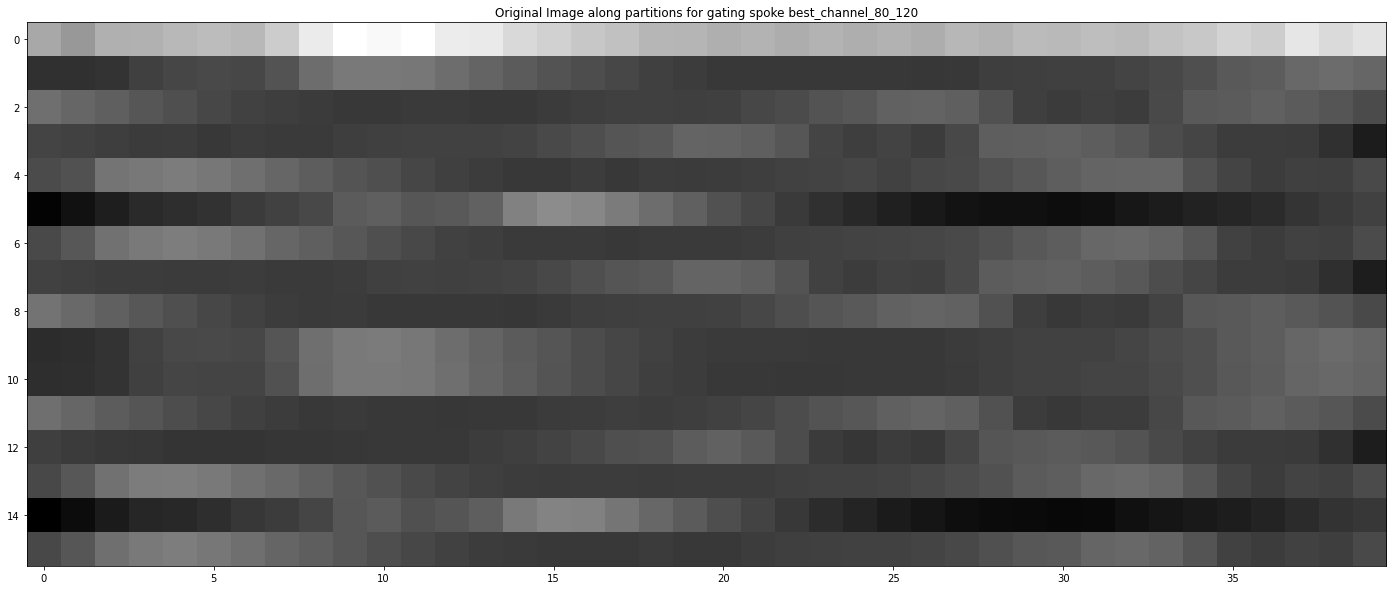

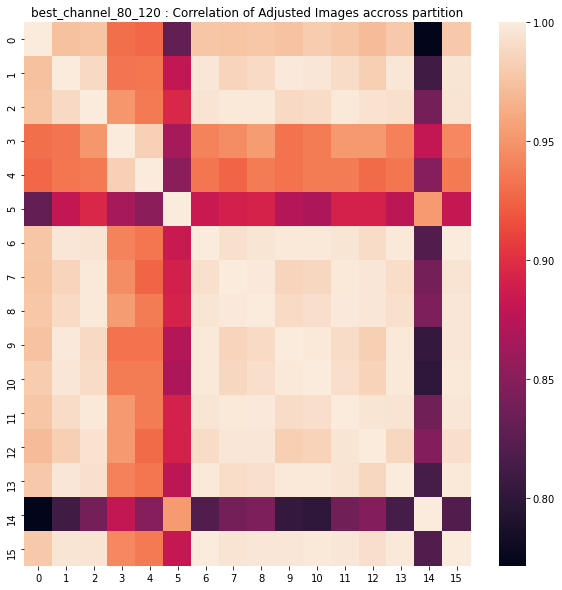

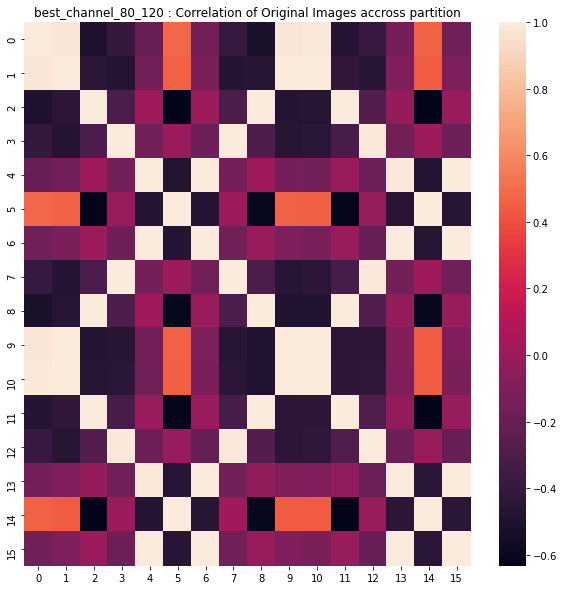

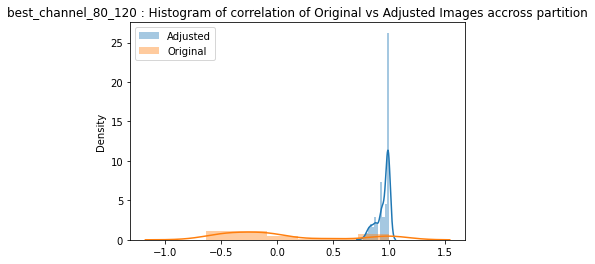

In [195]:
plot_adjusted_images_vs_baseline(series,2,bottom,top)

In [196]:
bottom=25
top=375

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


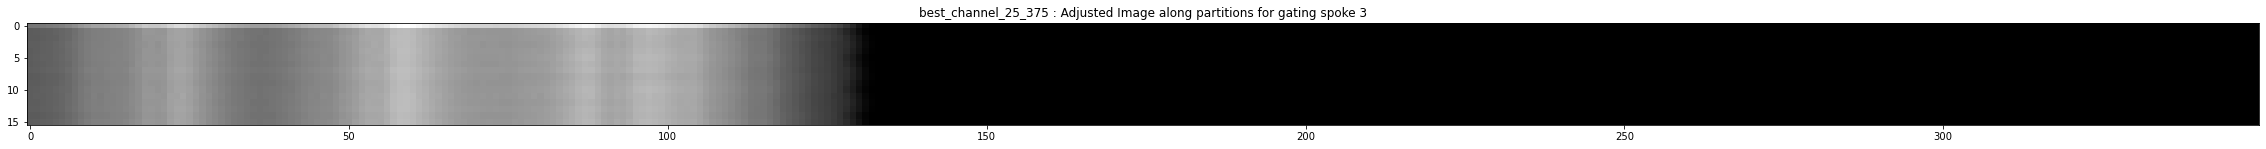

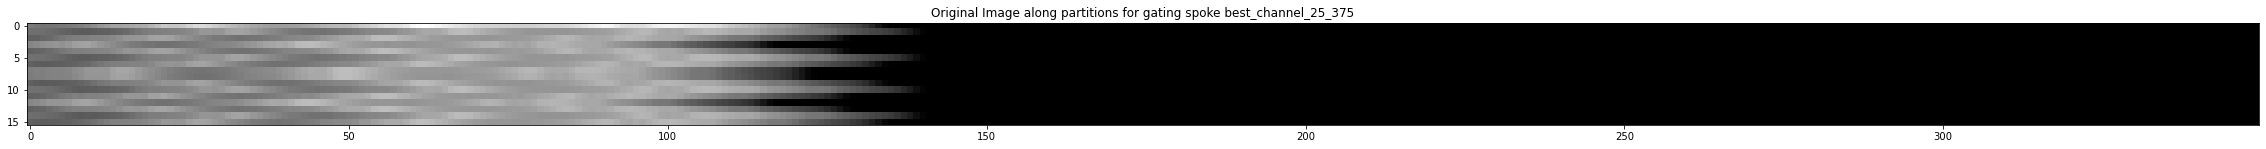

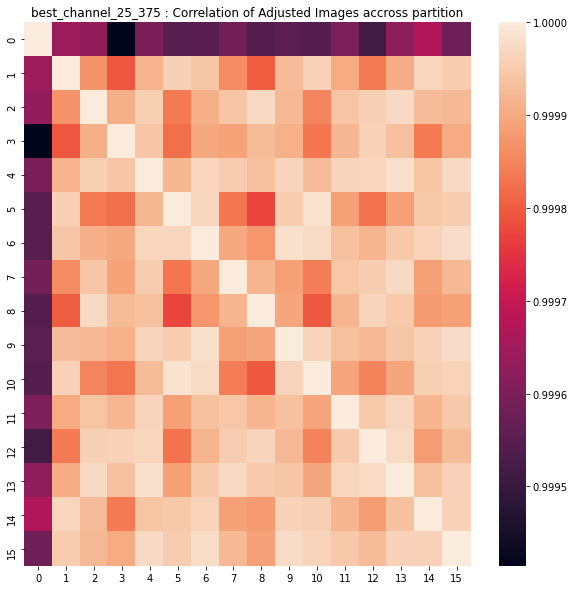

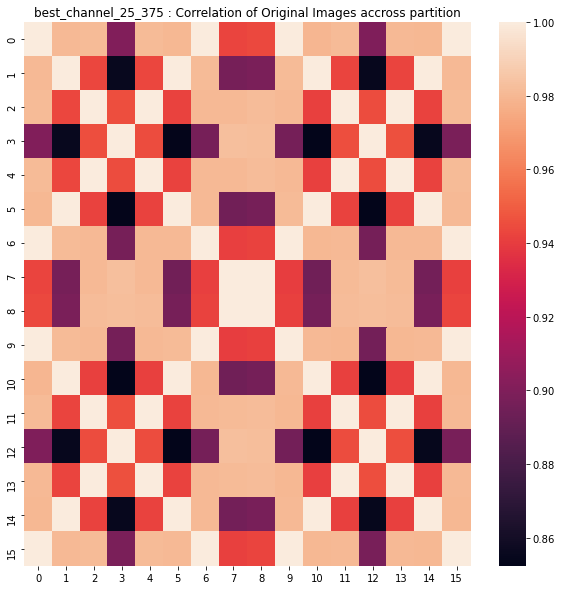

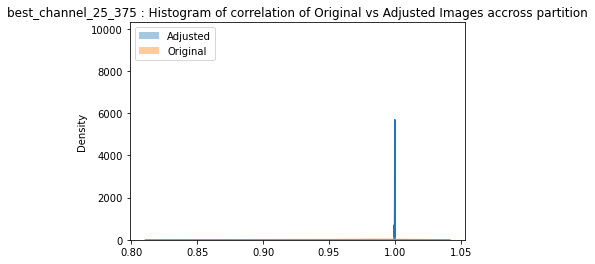

In [197]:
plot_adjusted_images_vs_baseline(series,3,bottom,top)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

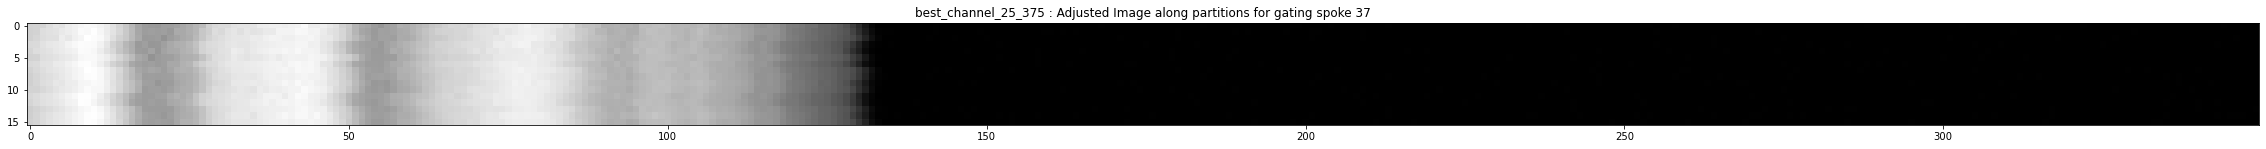

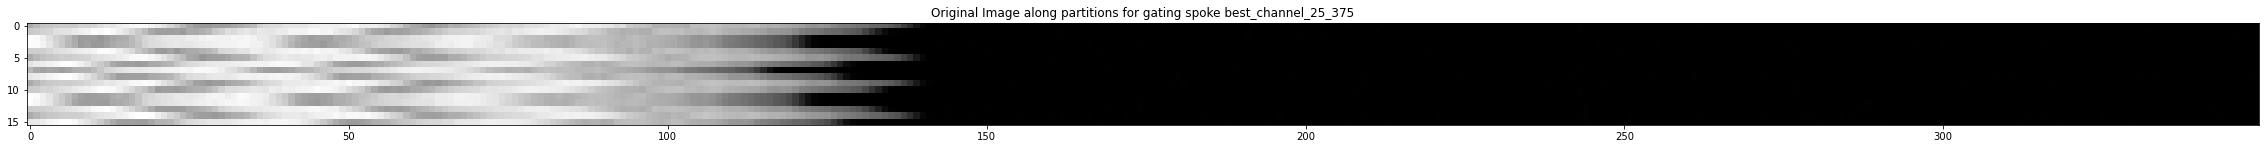

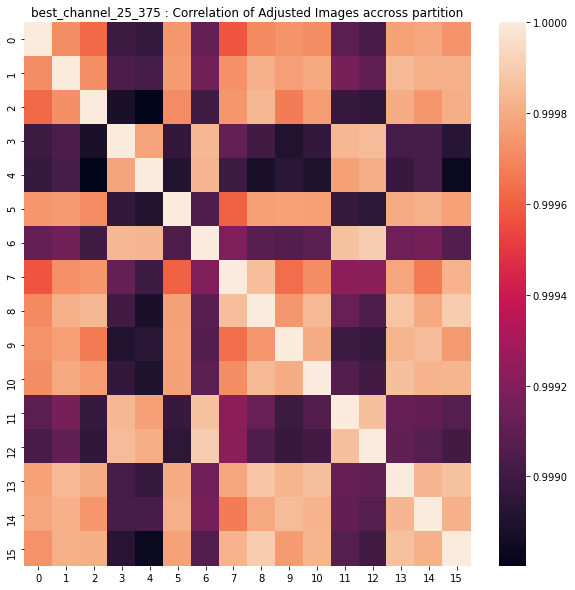

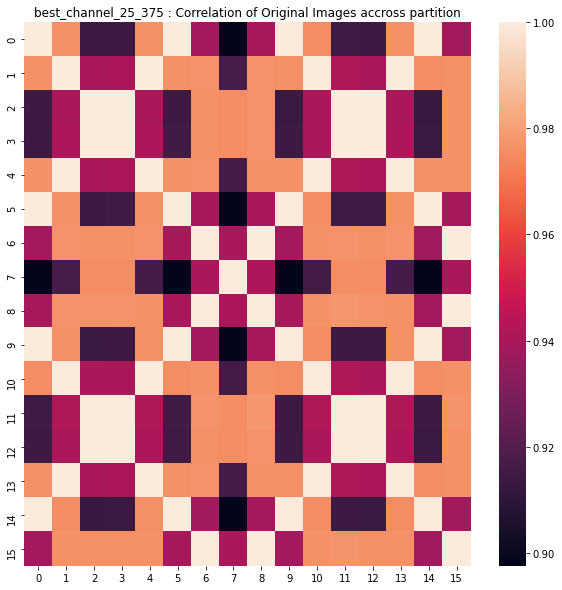

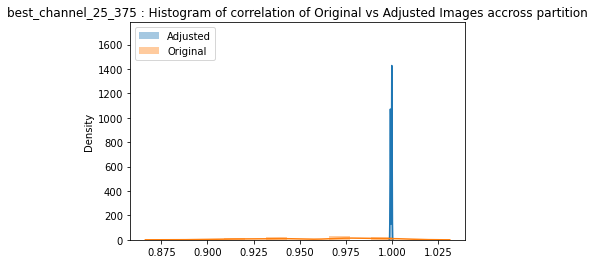

In [198]:
plot_adjusted_images_vs_baseline(series,37,bottom,top)

In [199]:
series="b1_mean"

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [202]:
bottom=50
top=150

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


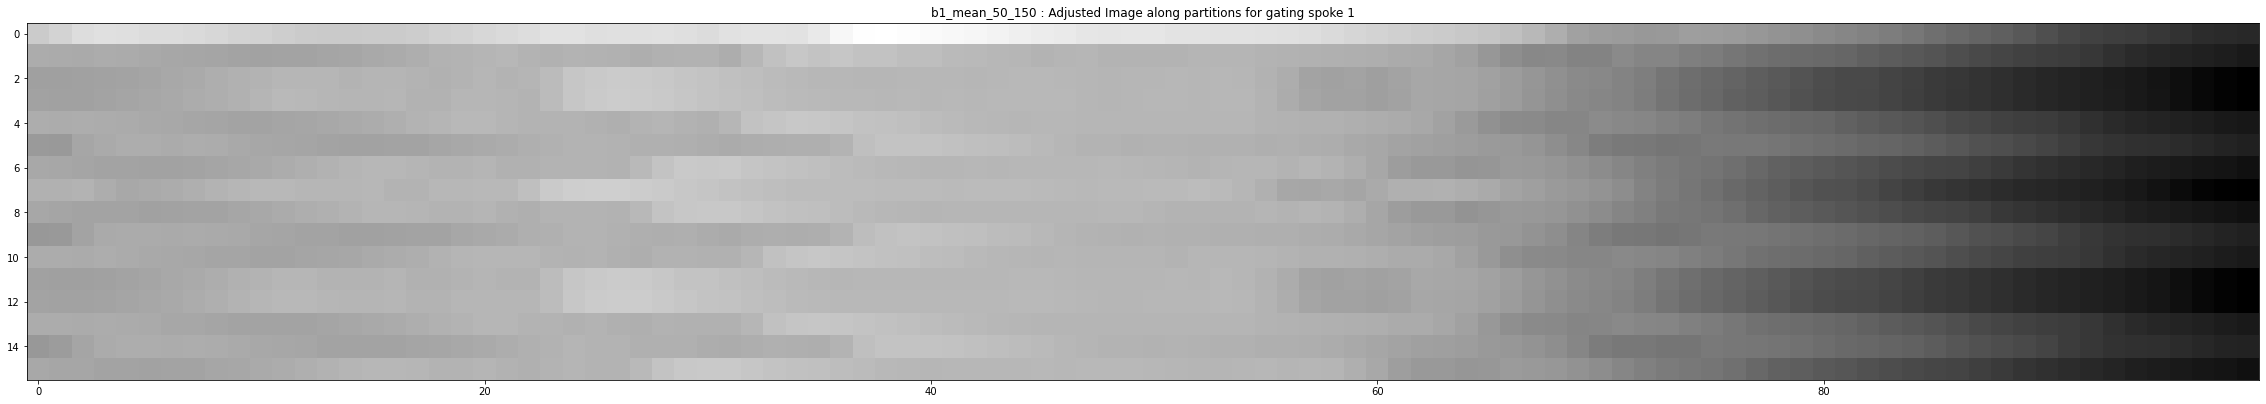

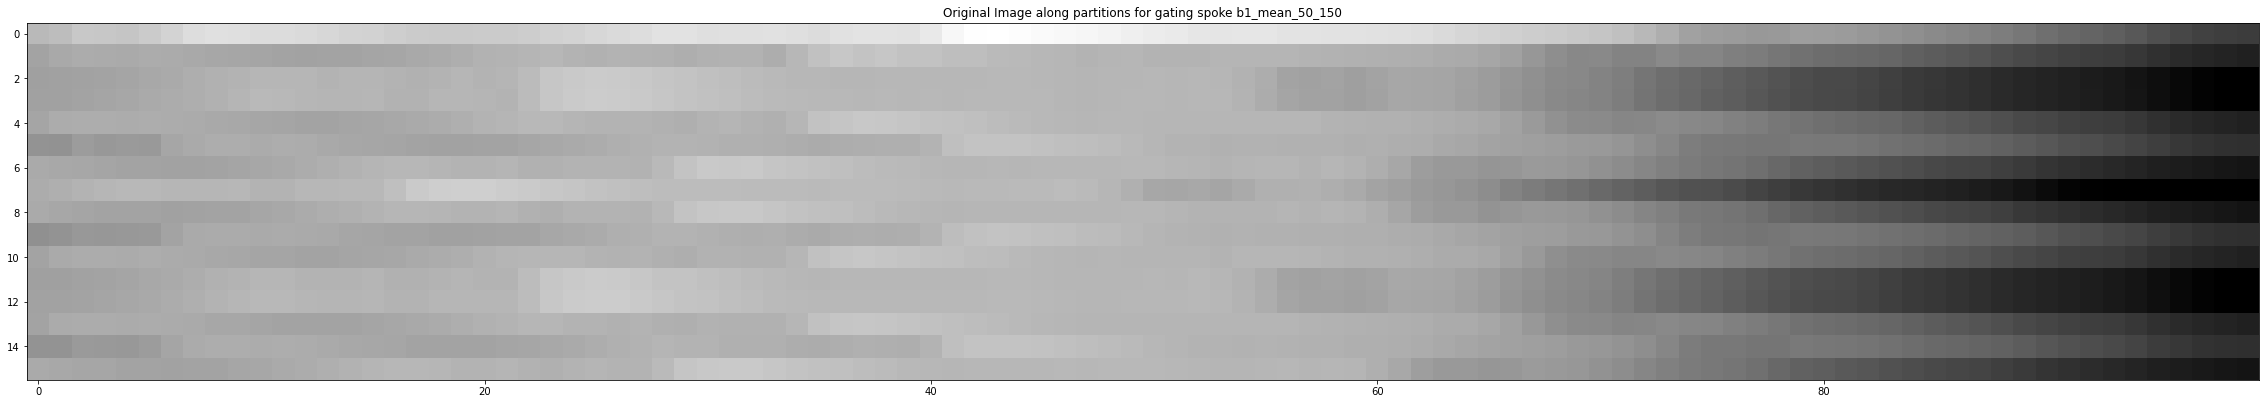

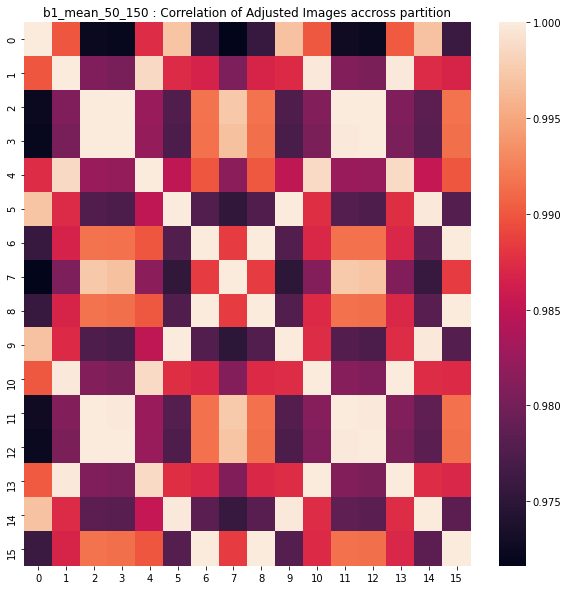

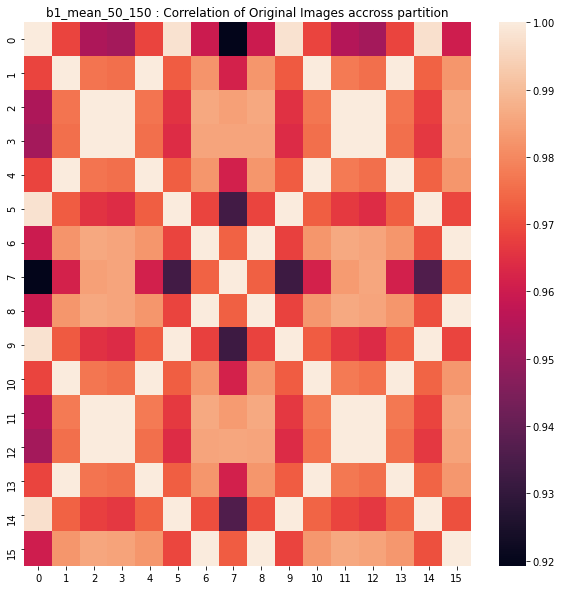

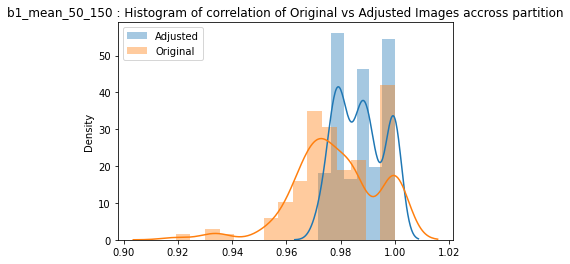

In [203]:
plot_adjusted_images_vs_baseline(series,1,bottom,top)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

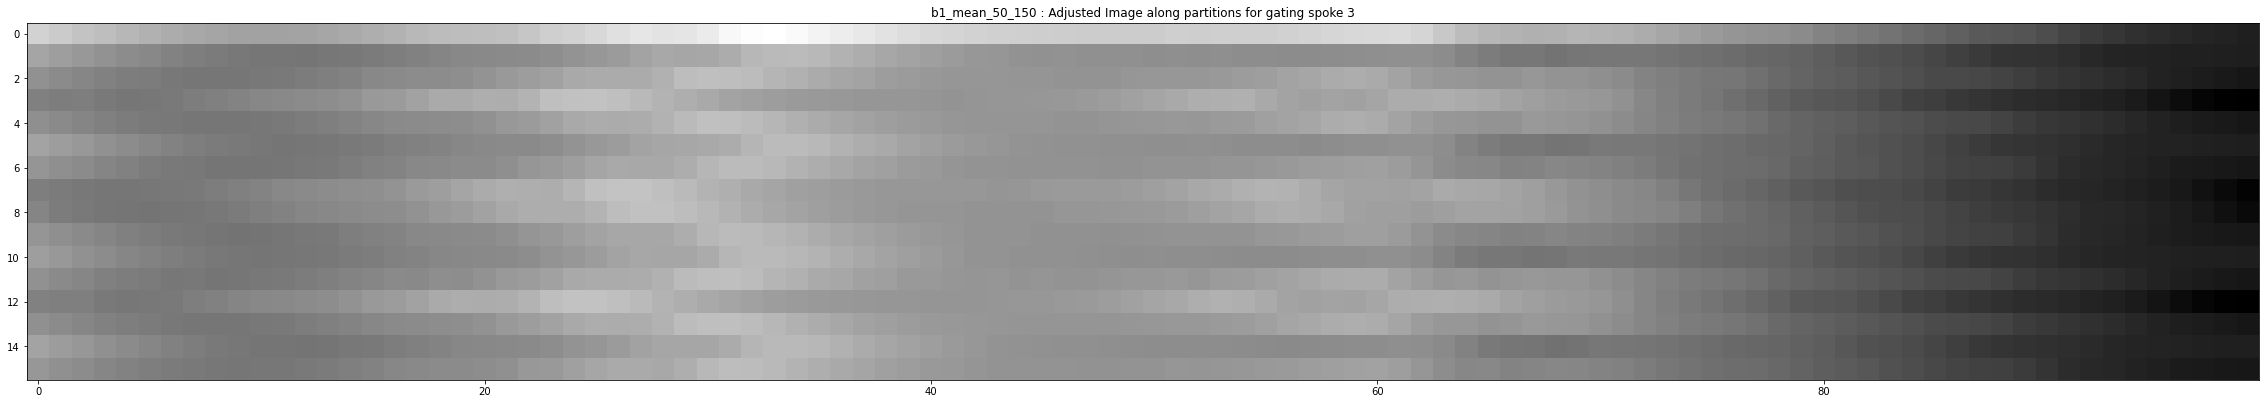

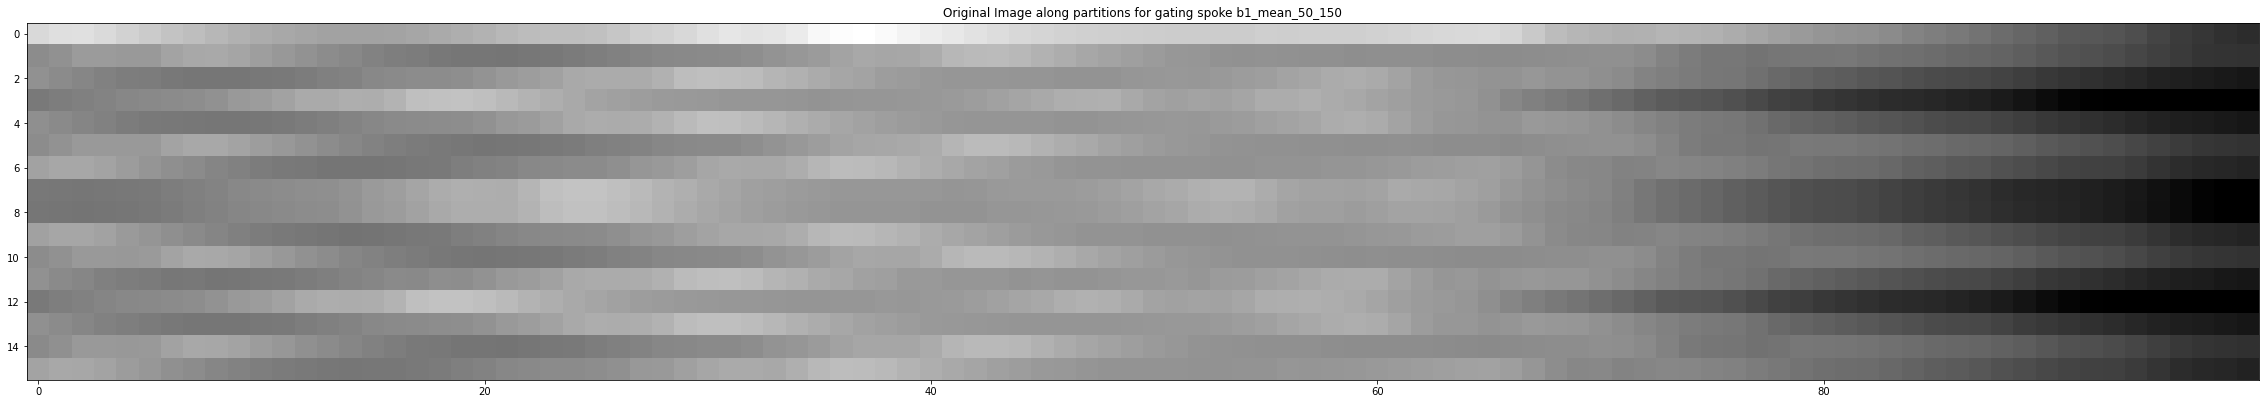

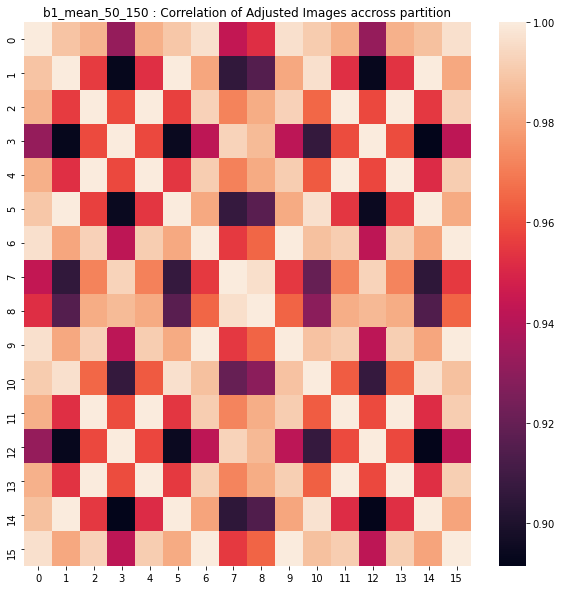

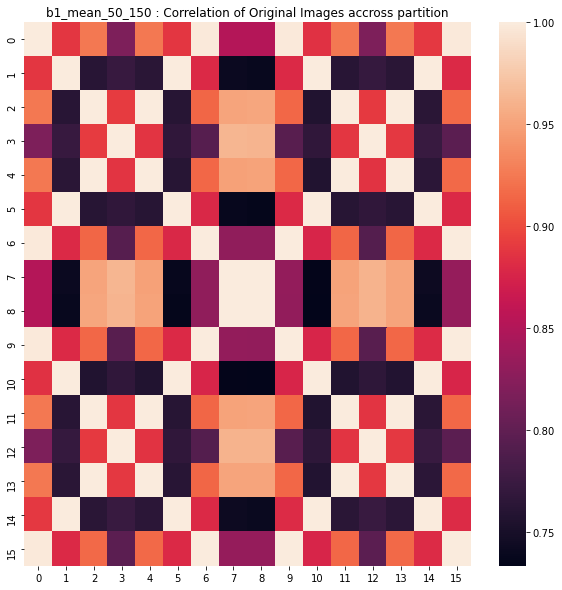

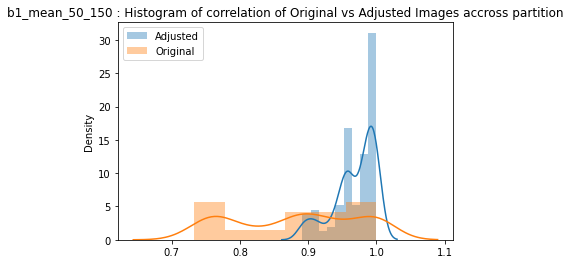

In [204]:
plot_adjusted_images_vs_baseline(series,3,bottom,top)

In [205]:
bottom=25
top=375

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


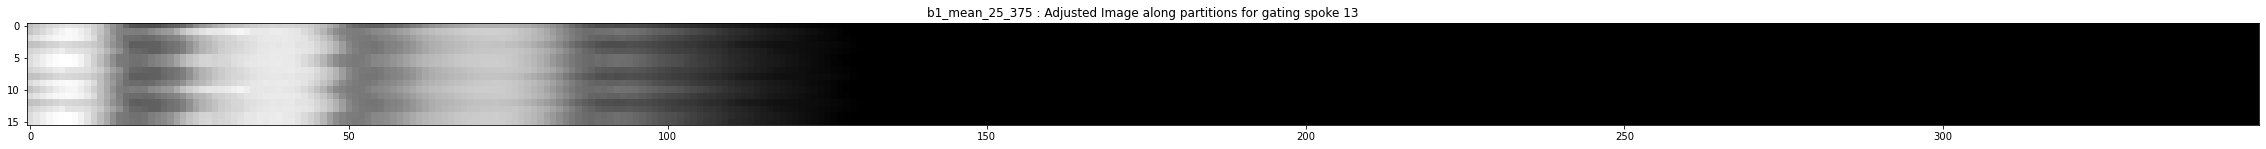

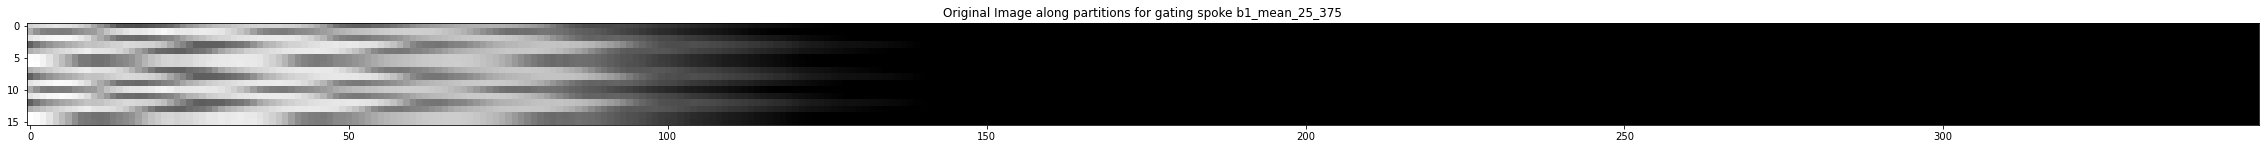

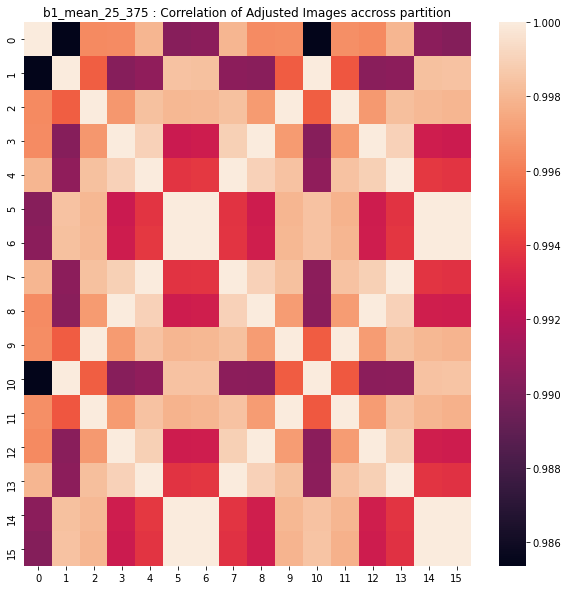

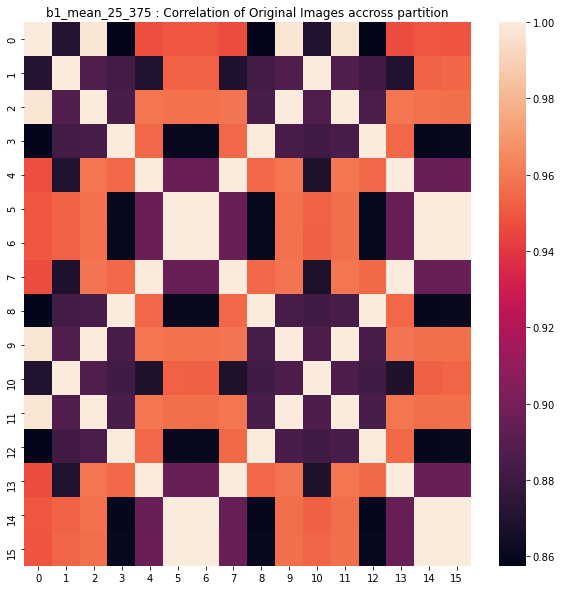

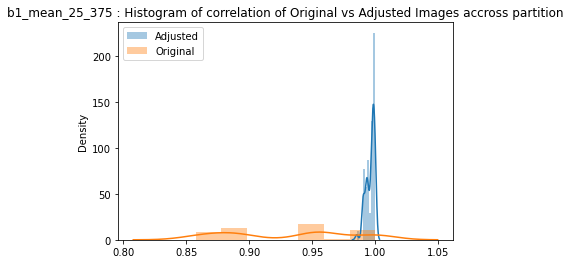

In [206]:
plot_adjusted_images_vs_baseline(series,13,bottom,top)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

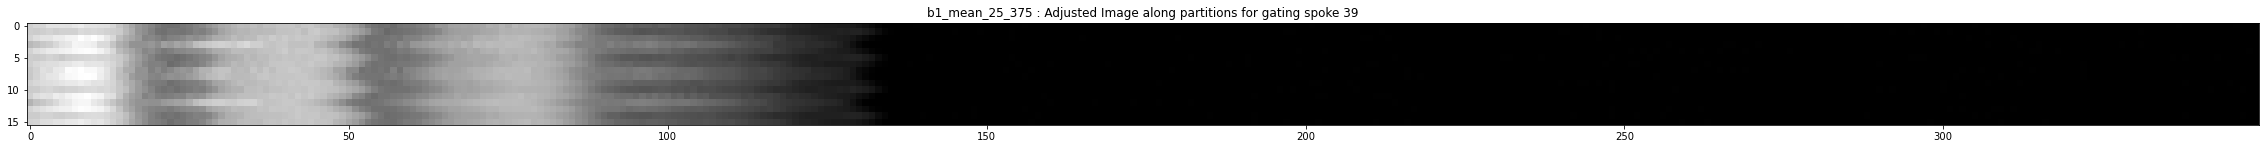

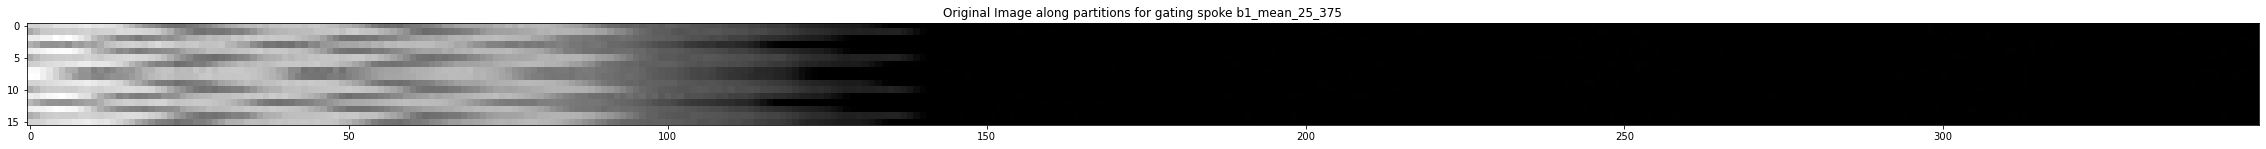

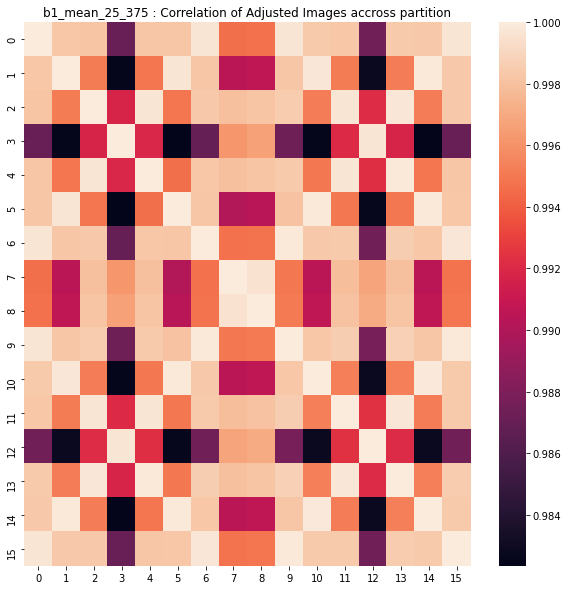

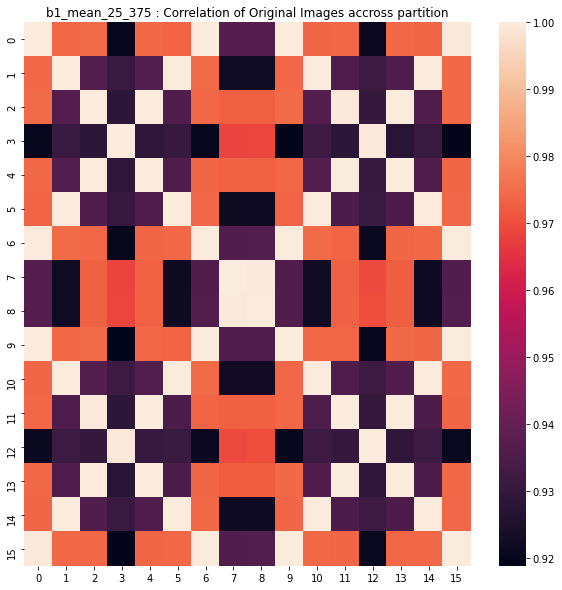

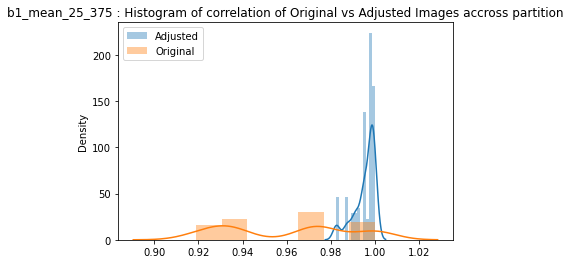

In [207]:
plot_adjusted_images_vs_baseline(series,39,bottom,top)

Conclusion :
On spokes where correlation with fingerprint is generally lower, the result of the algorithm is generally less good.
When taking smaller windows, correlation on original images is a lot lower - and the gain in correlation a lot sharper when adjusting images. The best channel correlation of original image with fingerprint is generally higher.

## Plot against image

In [208]:
def plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,serie=None,bottom=None,top=None,plot_on_same_image=False):
    global displacements_all
    global images_all
    global nb_slices
    global nb_gating_spokes
    
    if serie is None:
        list_images = list(images_all.keys())
    else :
        list_images = serie
    
    if (bottom is None) or (top is None):
        list_displacements=sorted(displacements_all.keys())
    else:
        list_displacements=[d for d in displacements_all.keys() if "{}_{}".format(bottom,top) in d ]
    
    
    if plot_on_same_image:
        plt.figure(figsize=(40, 30))
        image_nav_for_correl=images_all[list_images[0]].reshape(-1,images_all[list_images[0]].shape[-1])
        plt.imshow(image_nav_for_correl[(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes), bottom_plot:top_plot].T, cmap="gray")
    
    for k in list_images:
        if not(plot_on_same_image):
            image_nav_for_correl=images_all[k].reshape(-1,images_all[k].shape[-1])
        print(image_nav_for_correl.shape)
        for key in sorted(list_displacements):
            if k in key:
                
                displacement=displacements_all[key]
                disp_0=displacement[0]


                
                if not(plot_on_same_image):
                    plt.figure(figsize=(40, 30))
                    plt.imshow(image_nav_for_correl[(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes), bottom_plot:top_plot].T, cmap="gray")
                
                if not(plot_on_same_image):
                    plt.plot(displacement[(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)]-disp_0+pixel_start-bottom_plot,linewidth=5,c="y")
                else:
                    plt.plot(displacement[(start_cycle * nb_gating_spokes):(end_cycle * nb_gating_spokes)]-disp_0+pixel_start-bottom_plot,linewidth=5,label=key)
                for j in range(end_cycle-start_cycle):
                    plt.axvline(x=j * nb_gating_spokes, color="r")
                if not(plot_on_same_image):
                    plt.title("{} : Displacement for cycles {} to {}".format(key,start_cycle,end_cycle))
                else:
                    plt.title("Displacement for cycles {} to {}".format(start_cycle,end_cycle))
    
    if plot_on_same_image:
        plt.legend()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [209]:
pixel_start=100
bottom_plot=50
top_plot=150

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)
(800, 400)
(800, 400)


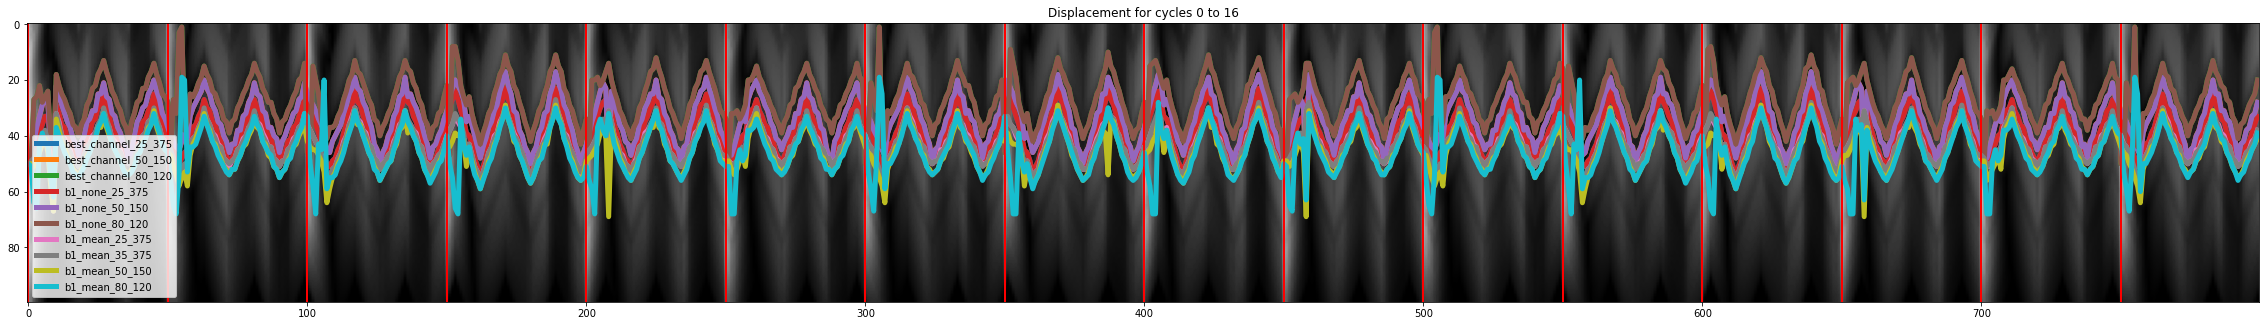

In [210]:

start_cycle = 0
end_cycle=nb_slices

plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,plot_on_same_image=True)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)
(800, 400)
(800, 400)


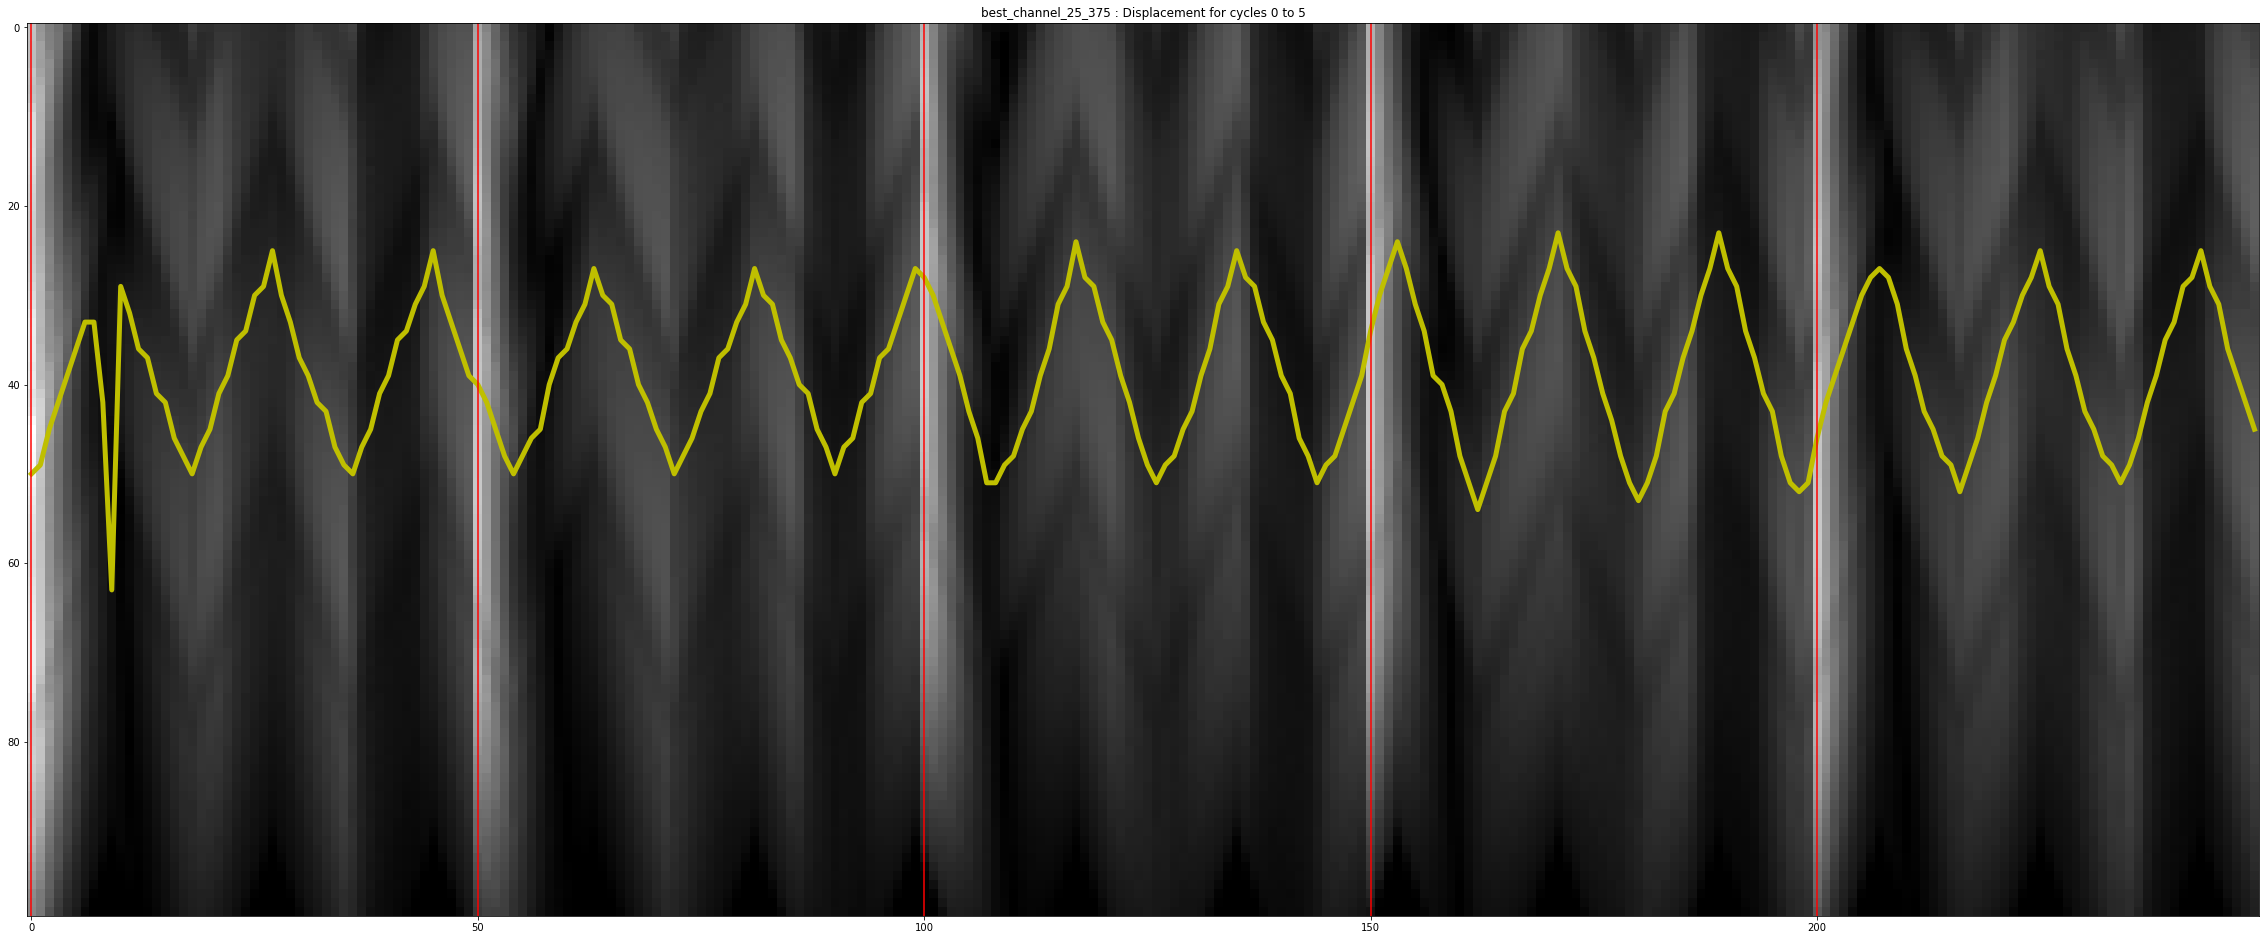

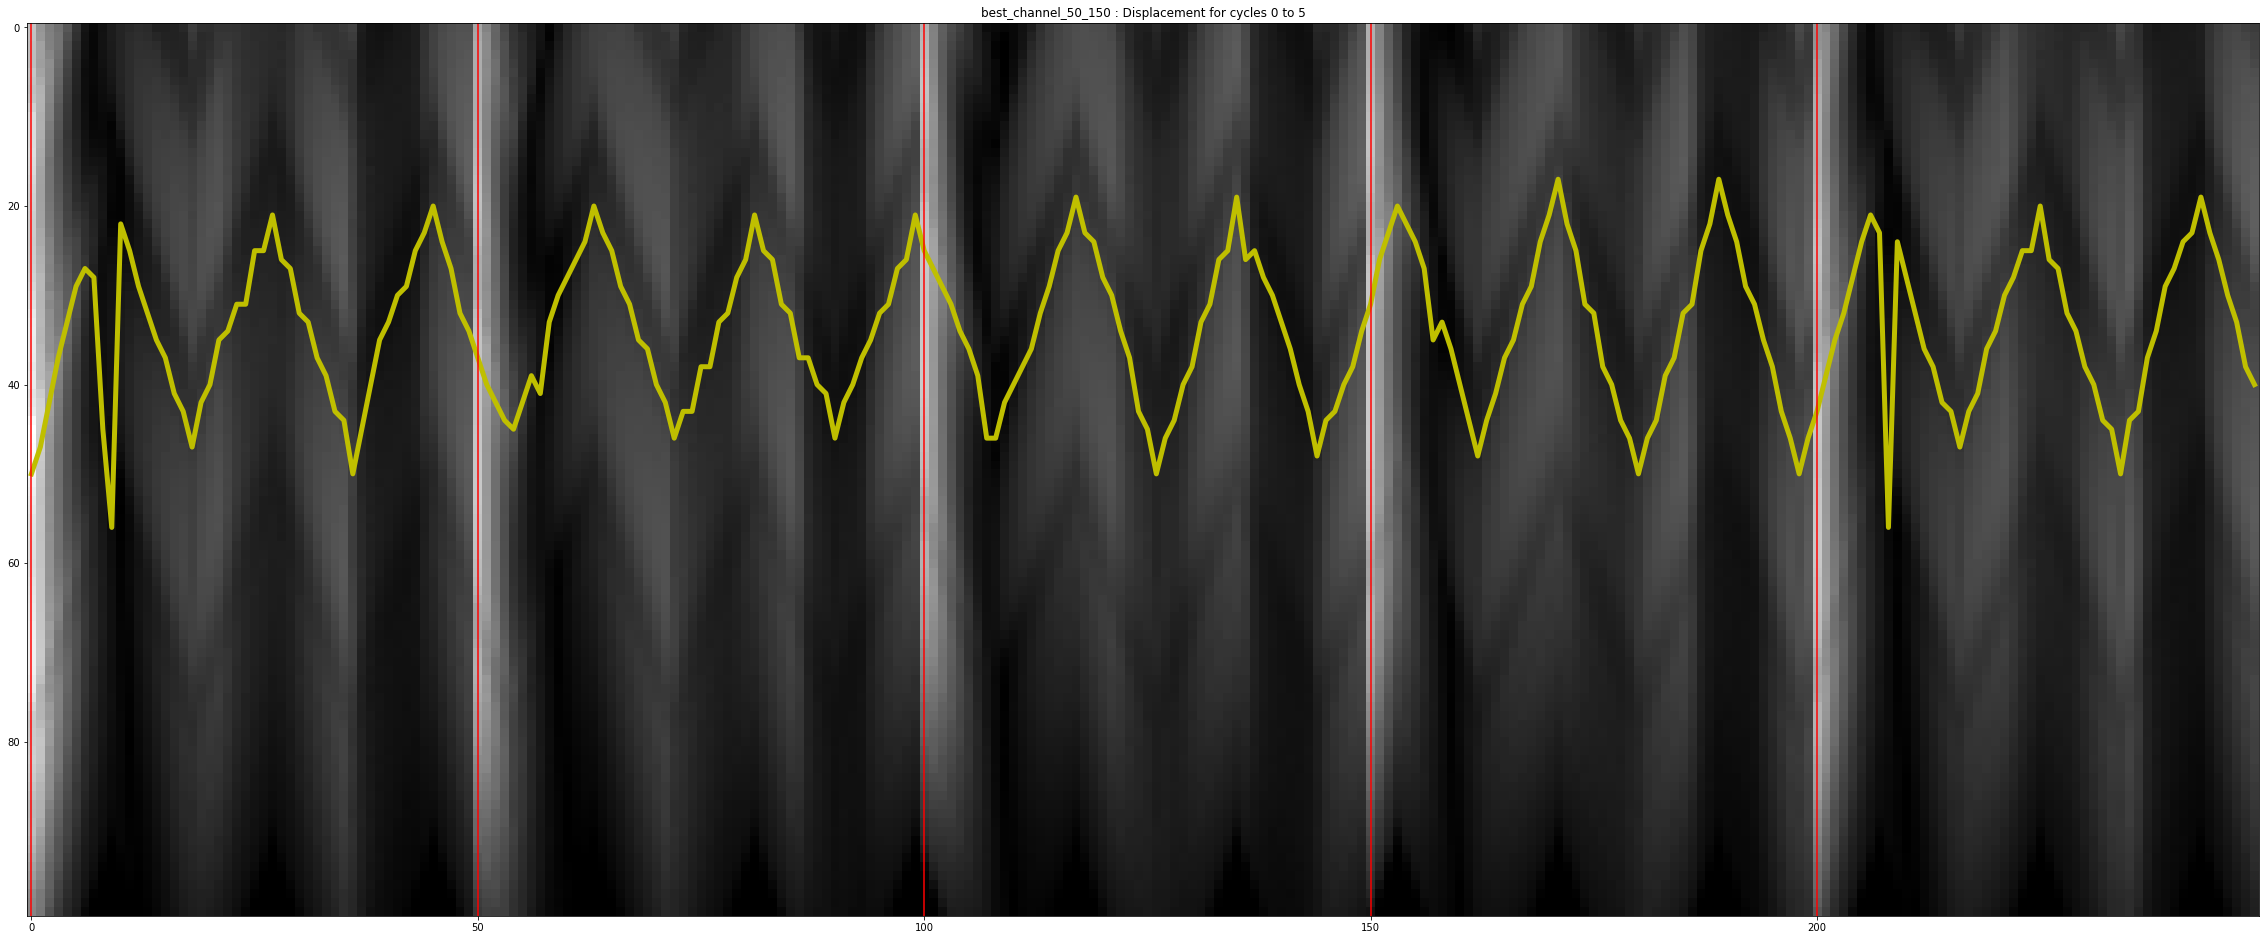

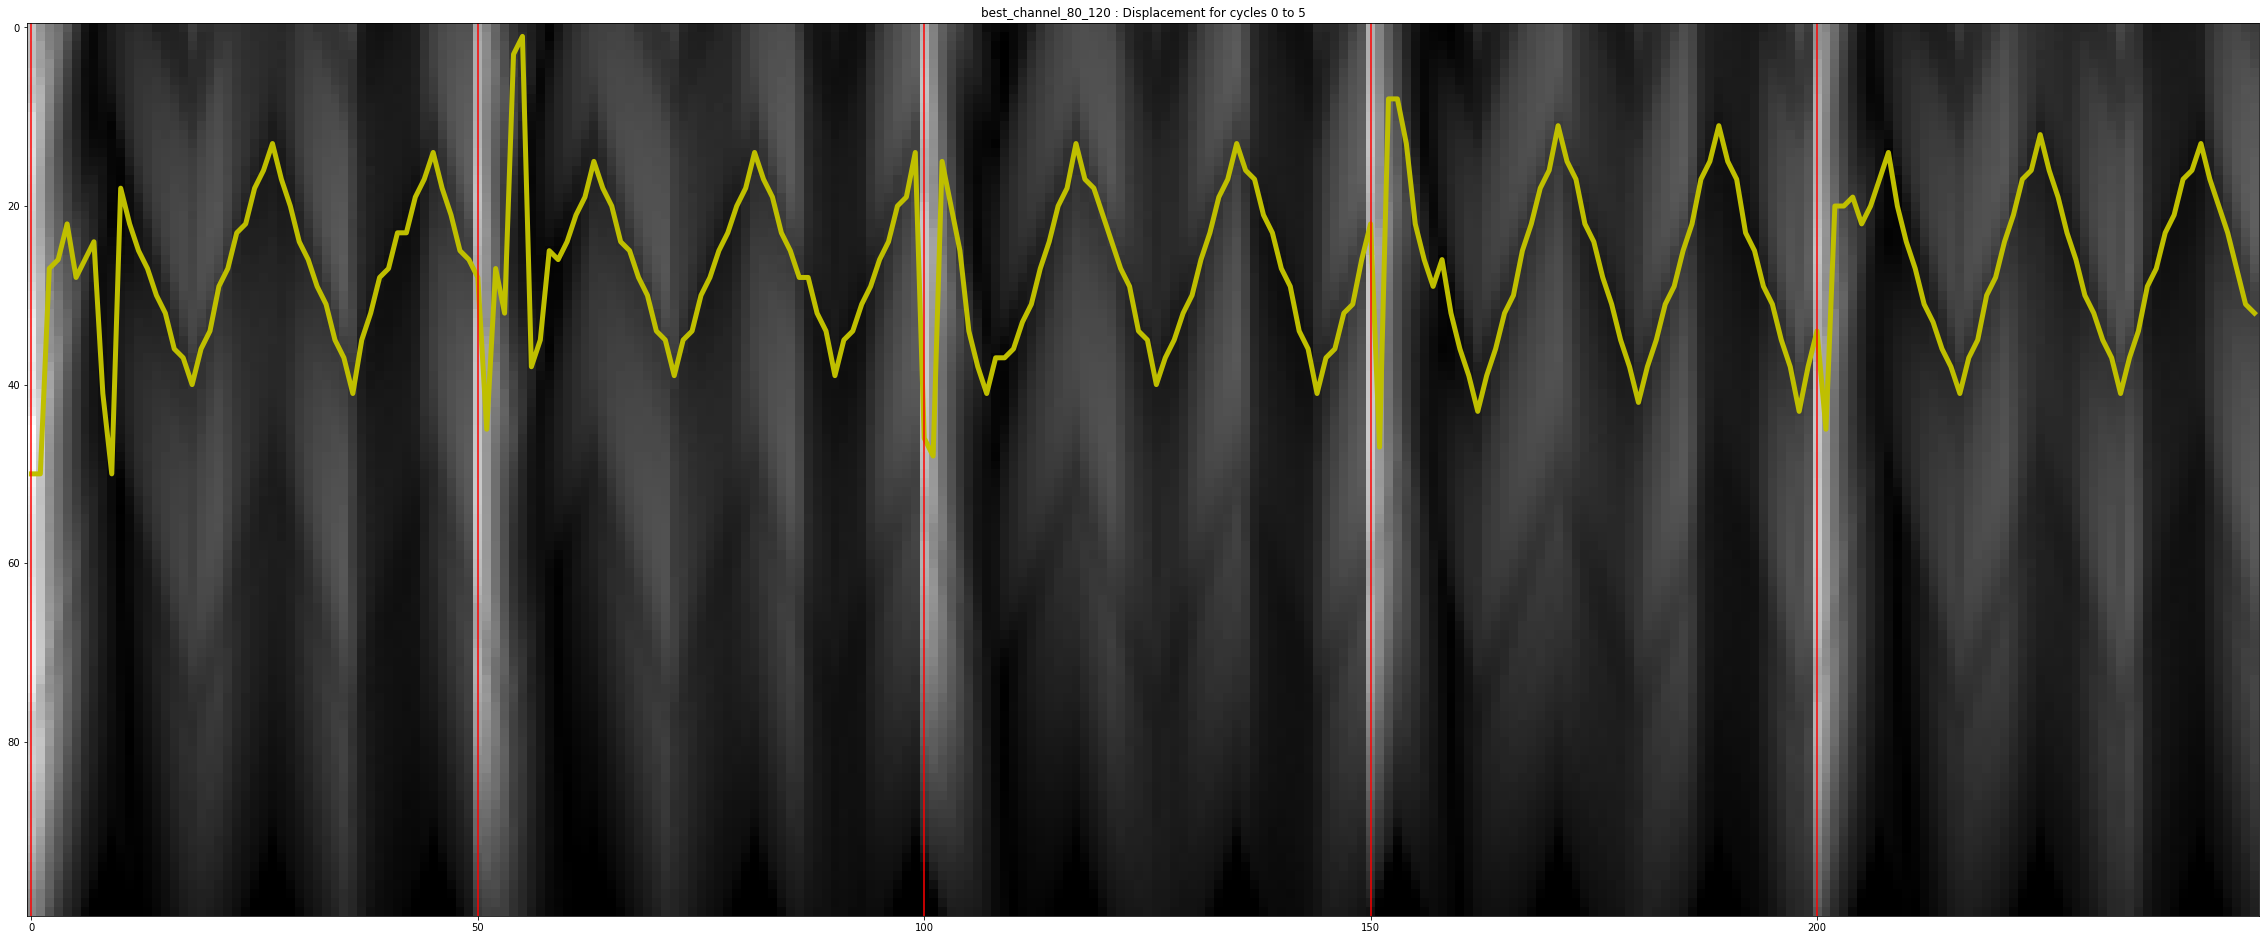

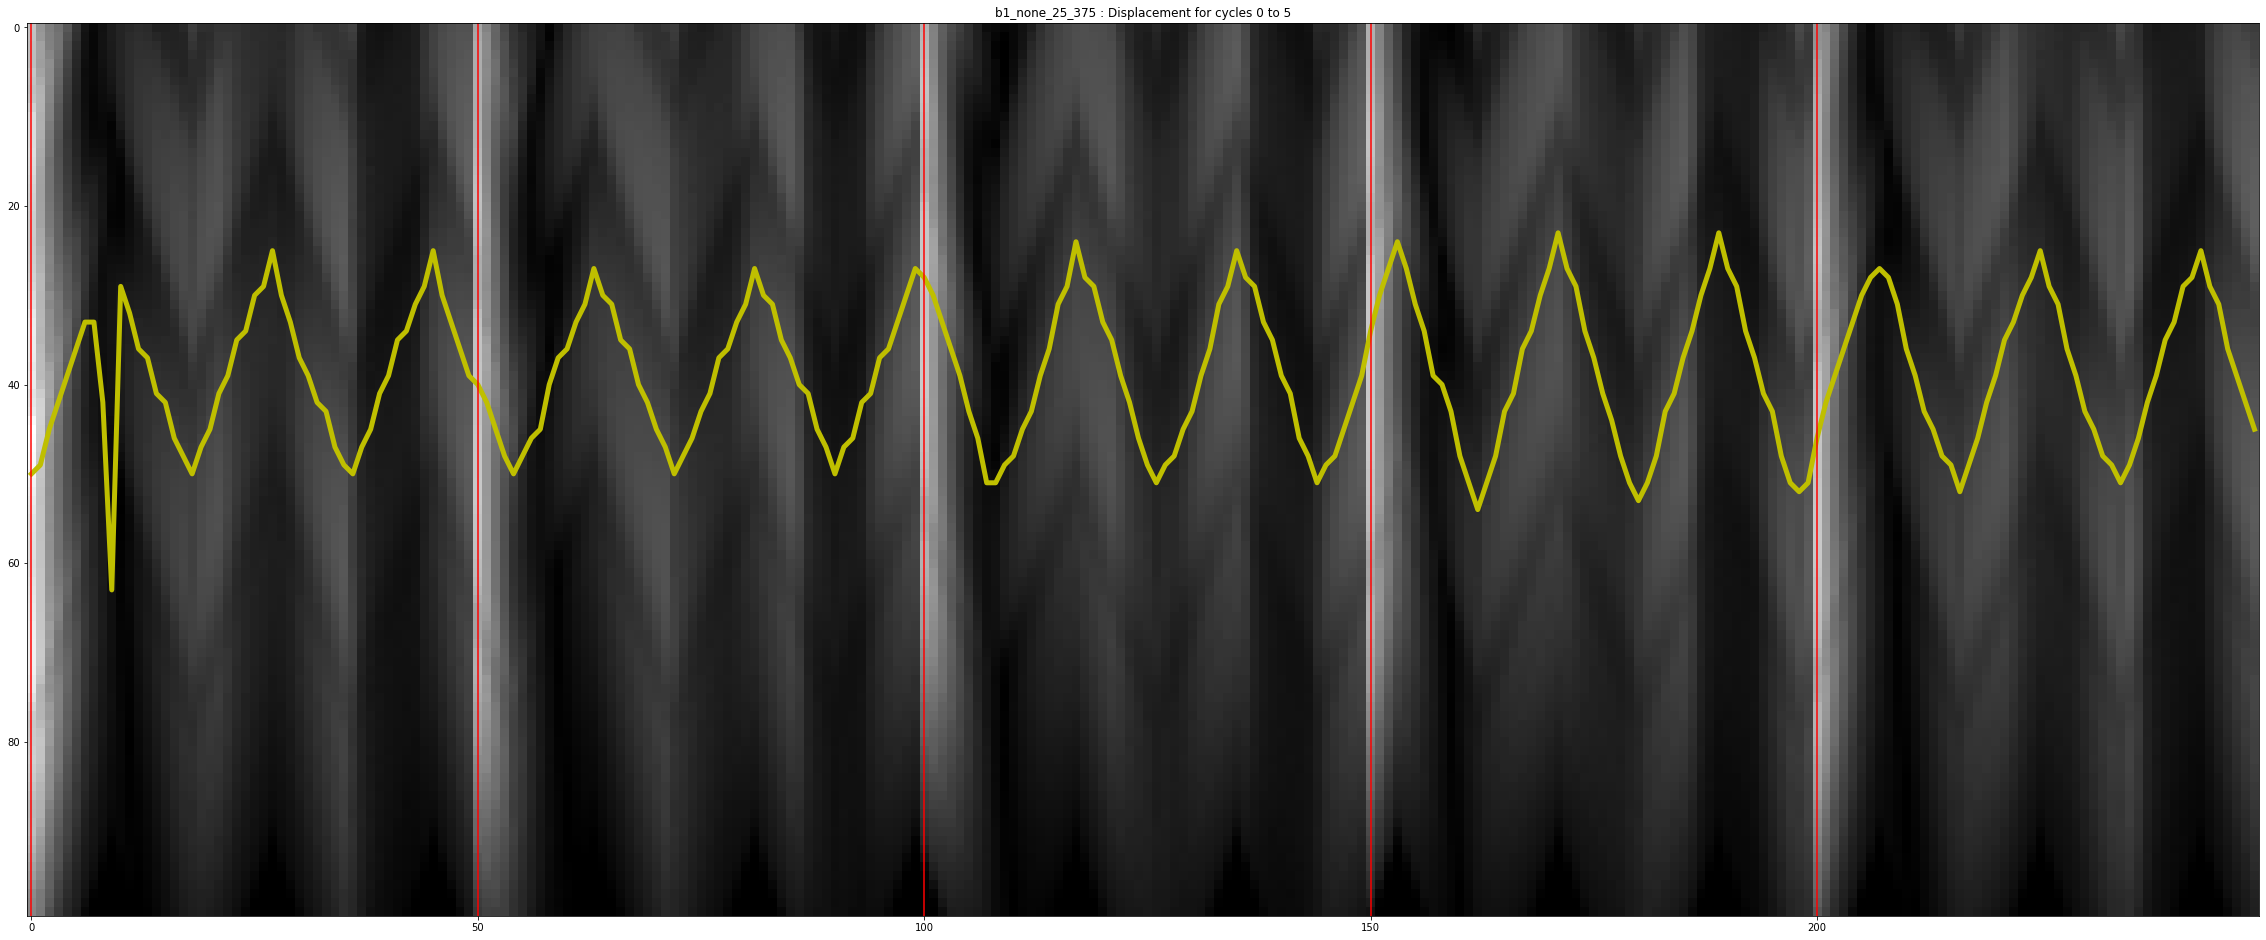

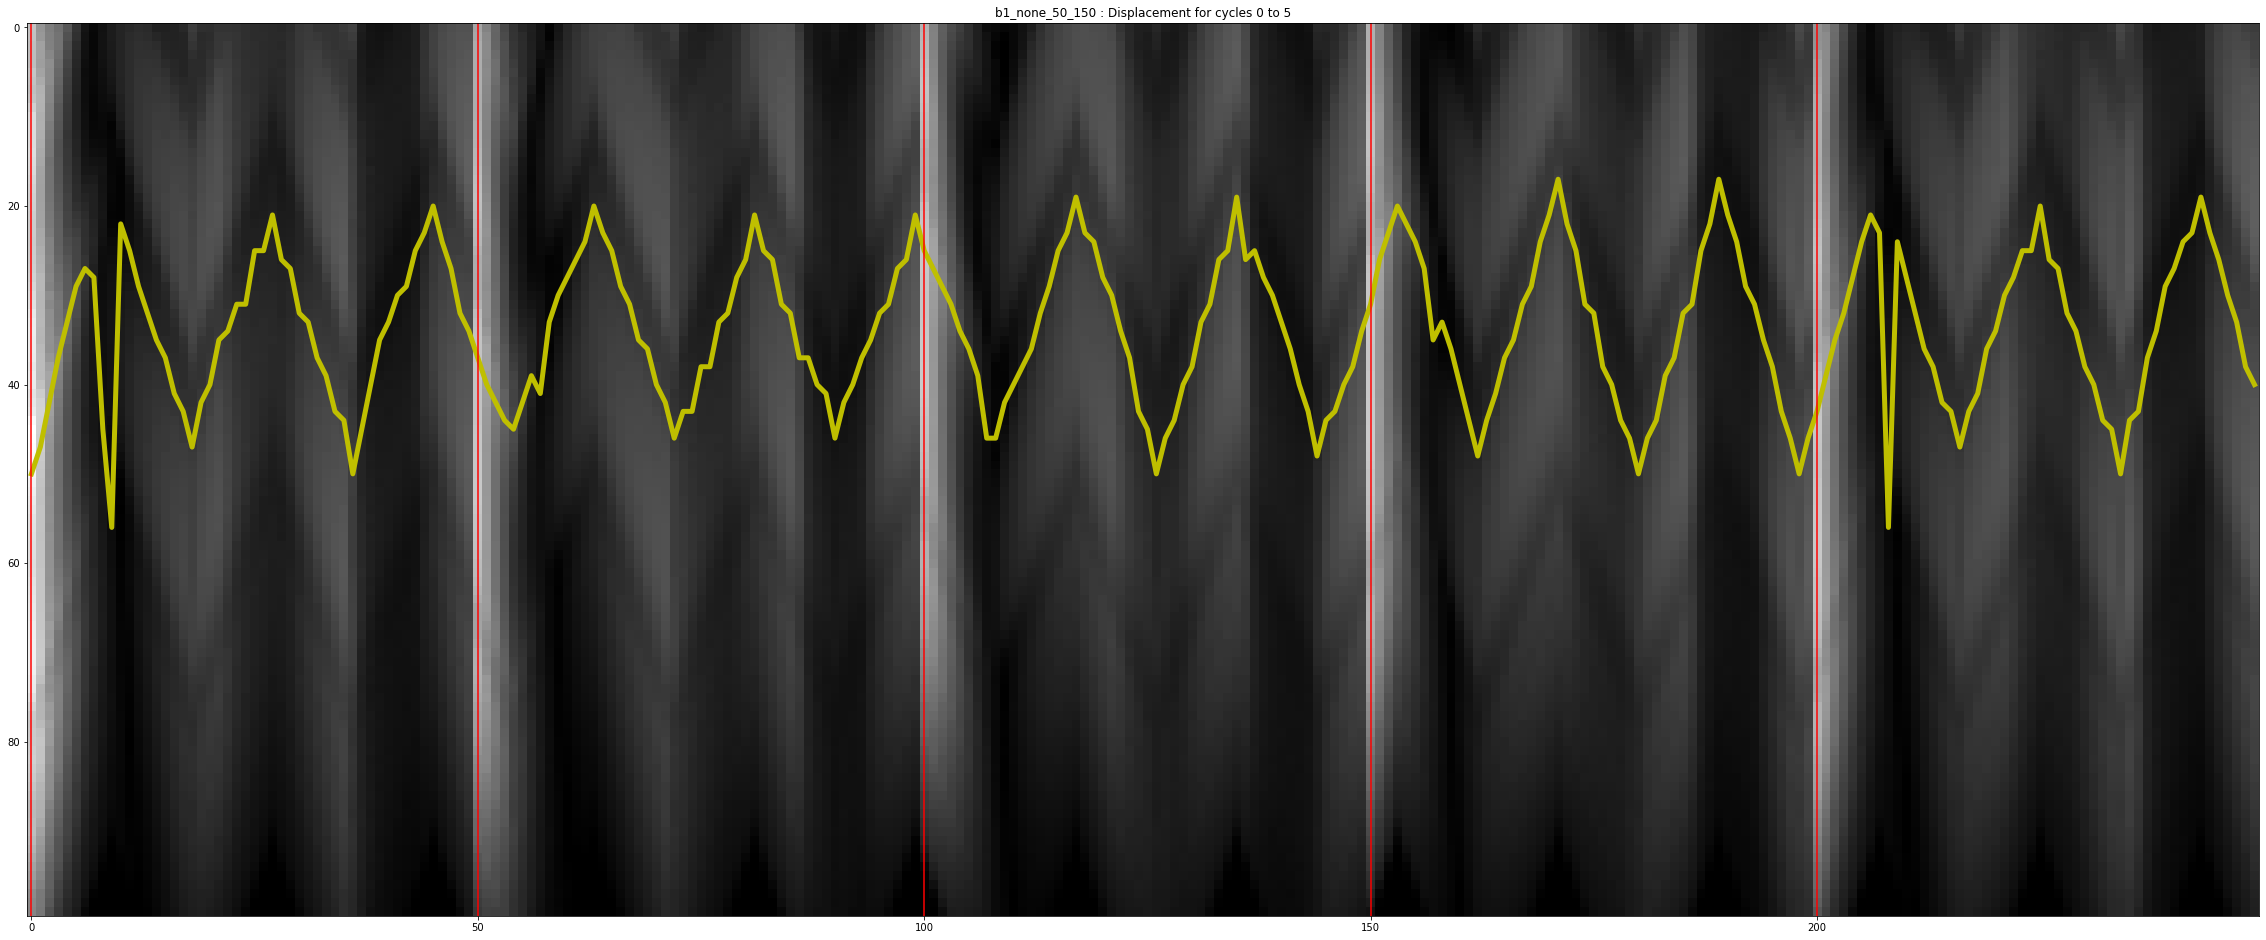

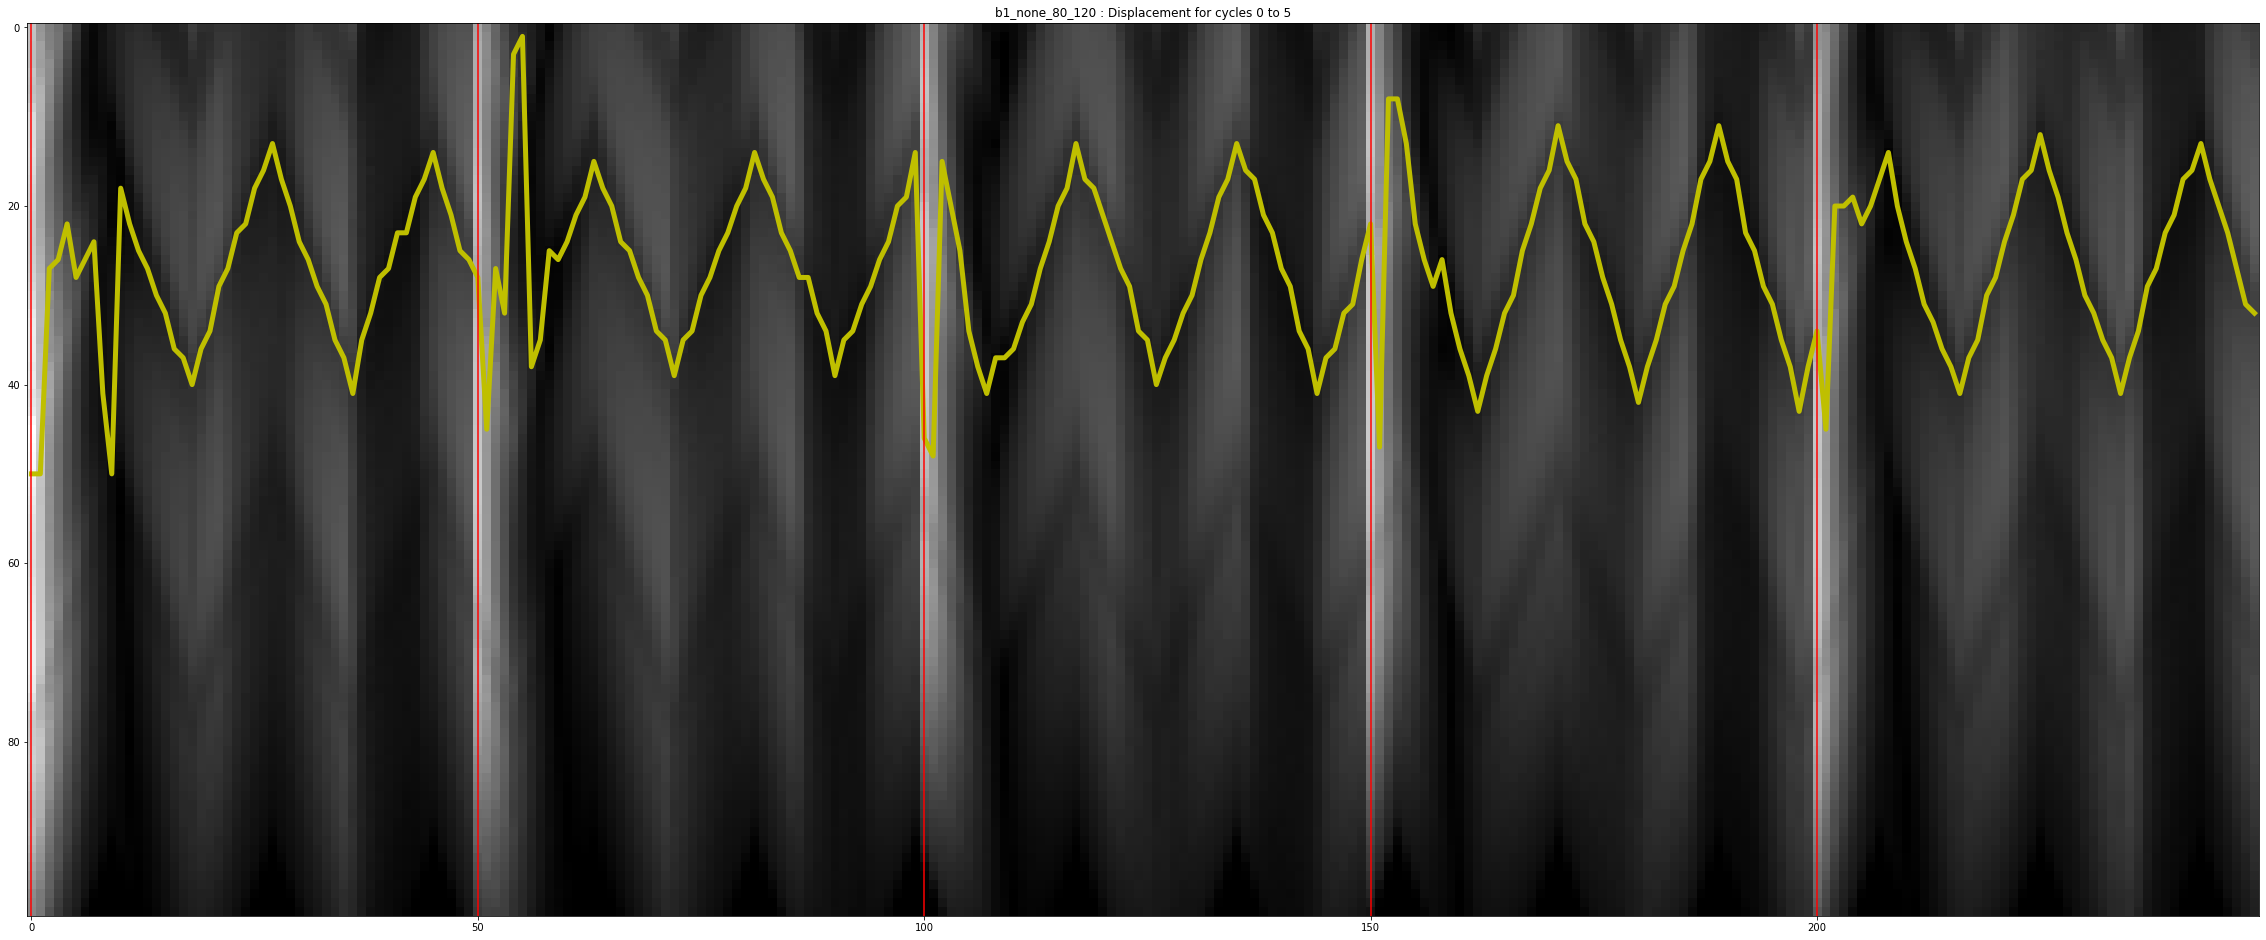

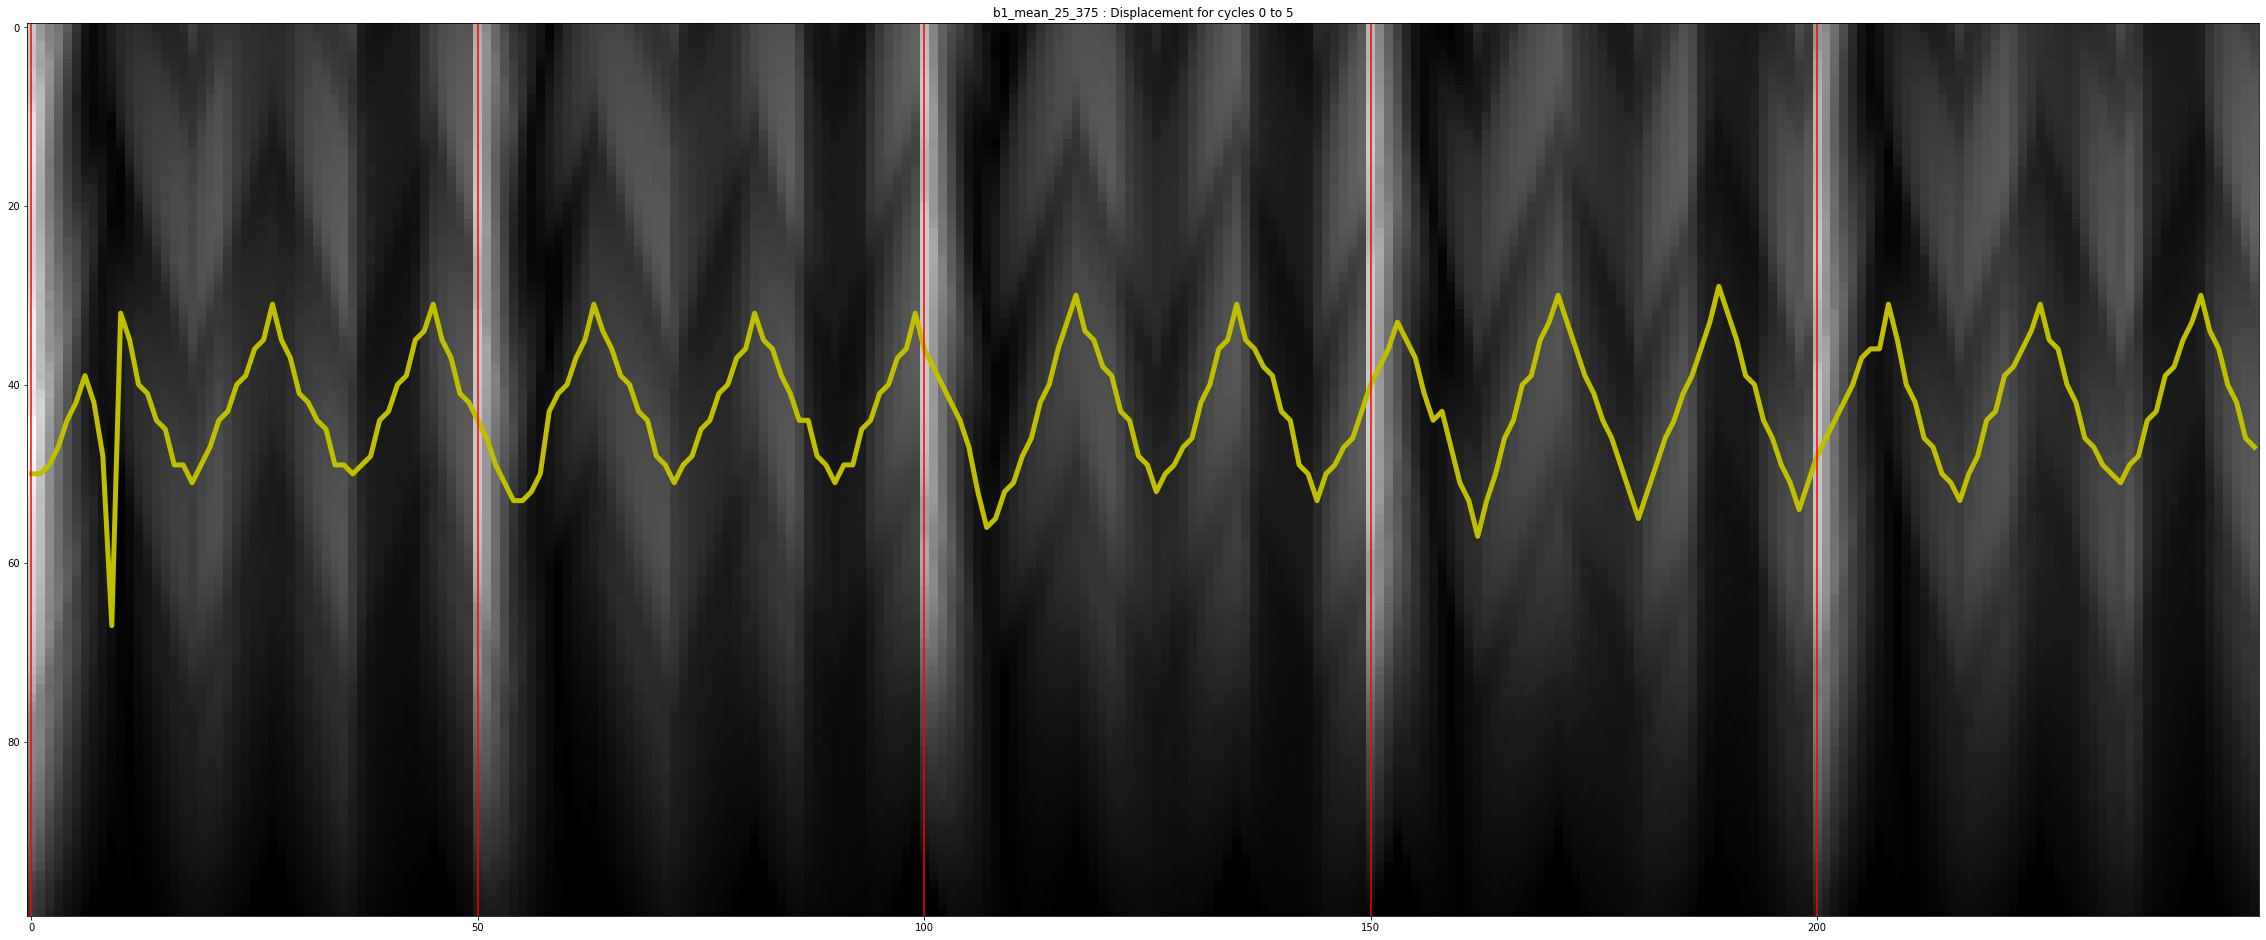

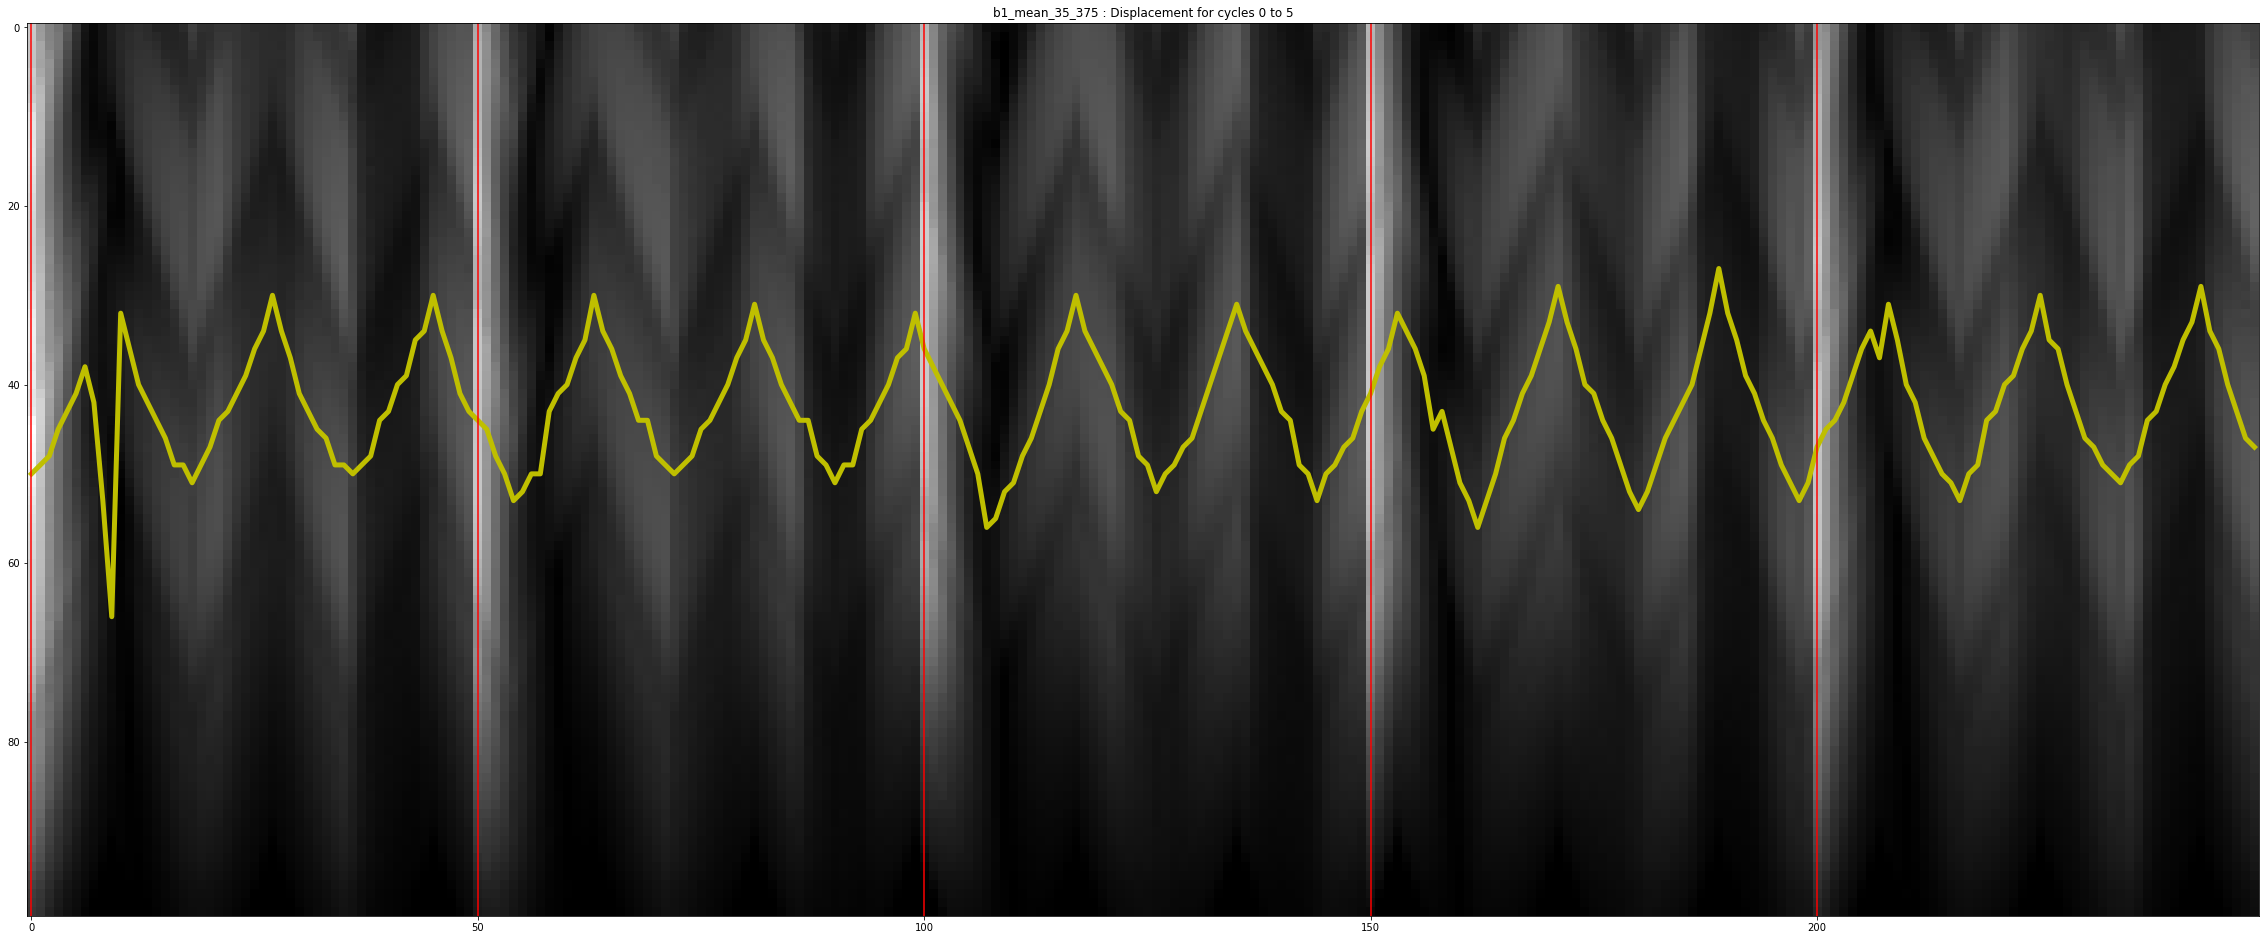

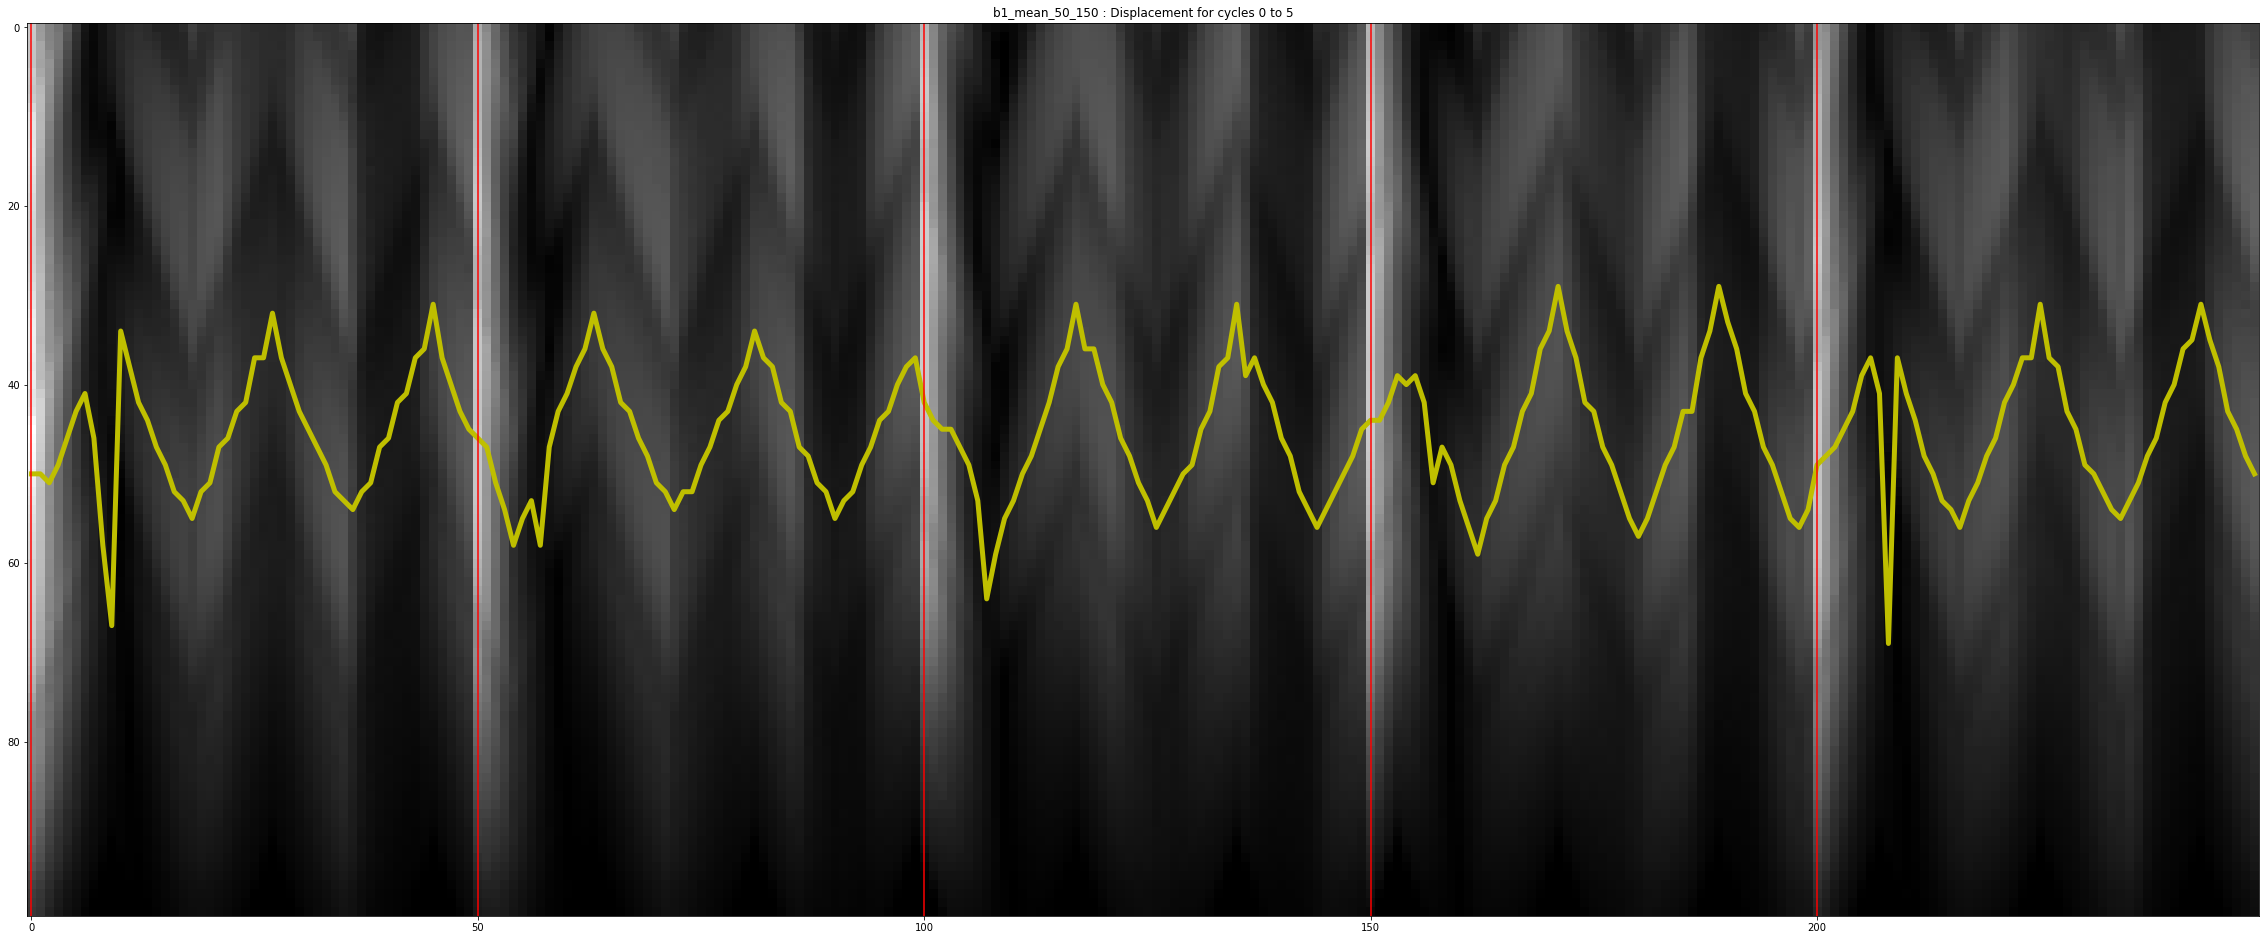

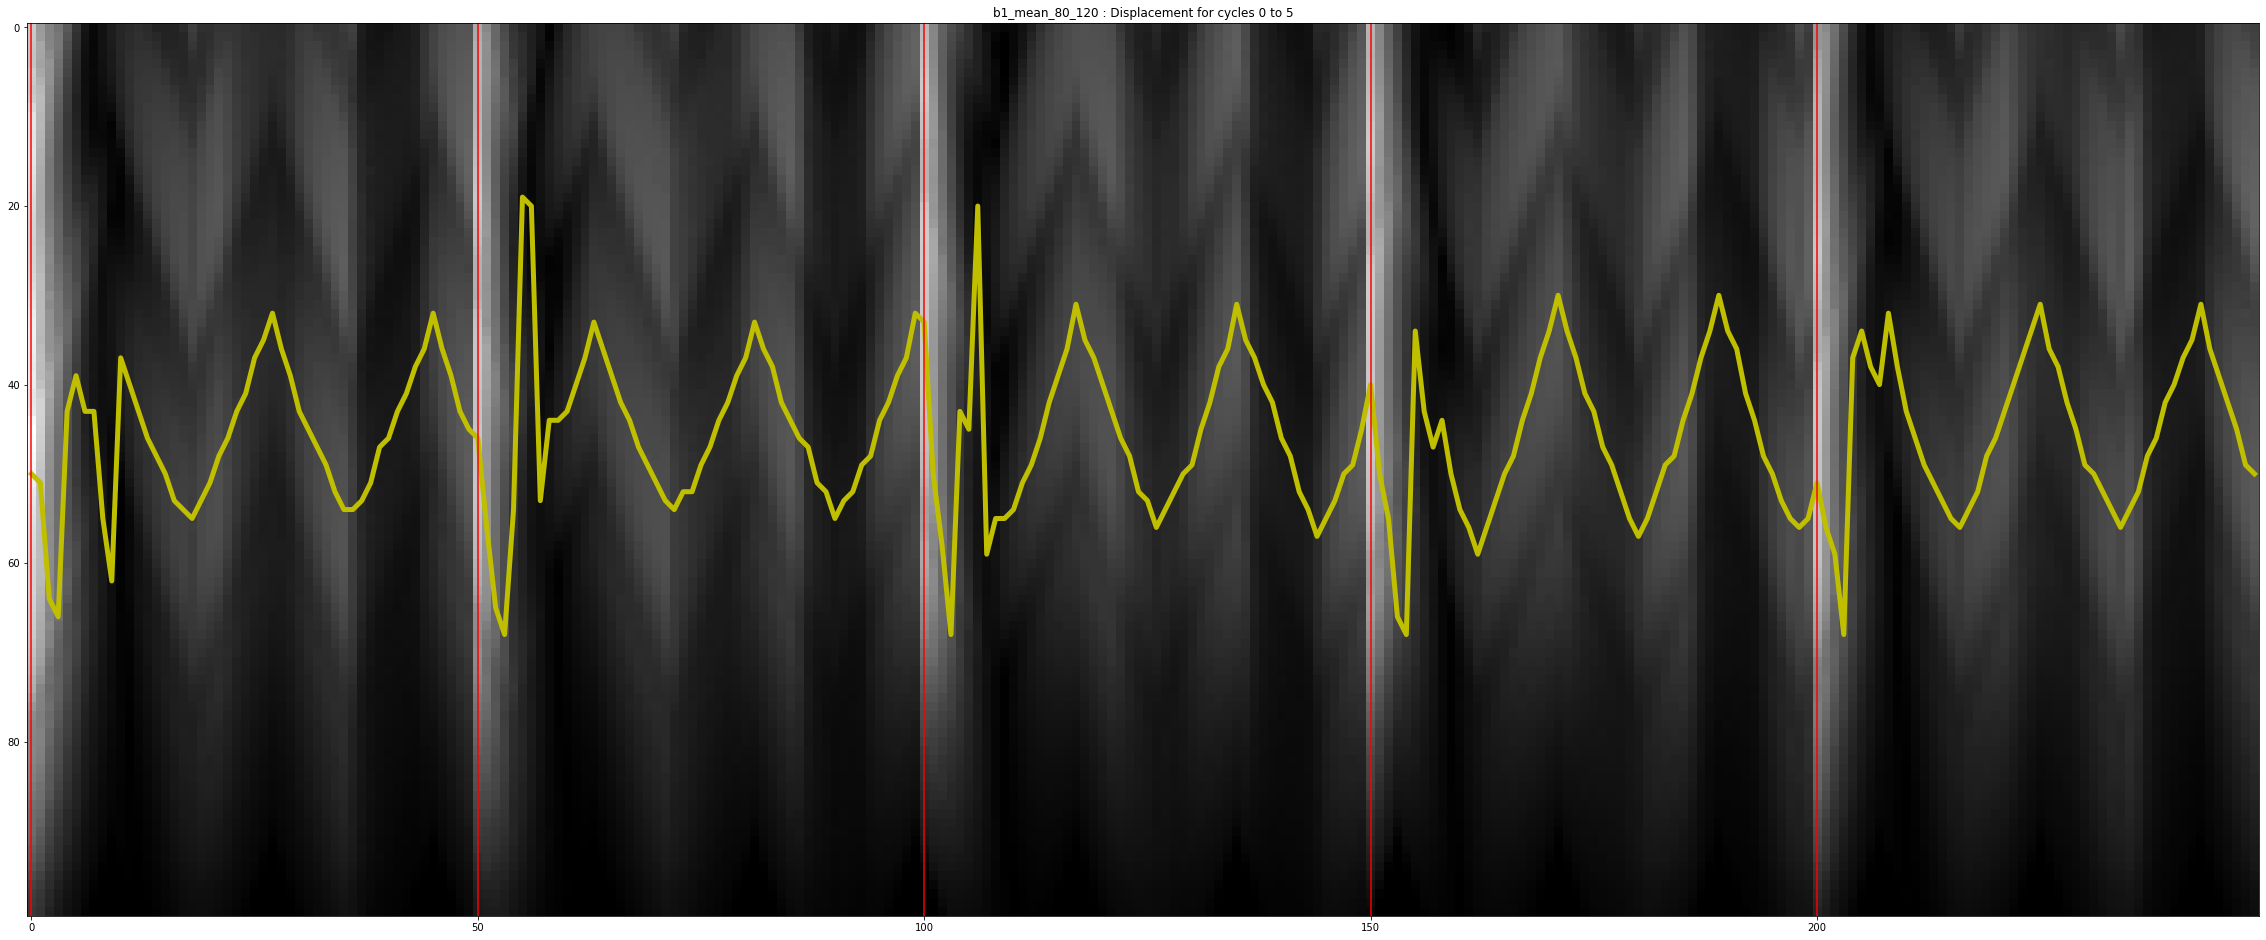

In [211]:
start_cycle = 0
end_cycle=5

plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)
(800, 400)
(800, 400)


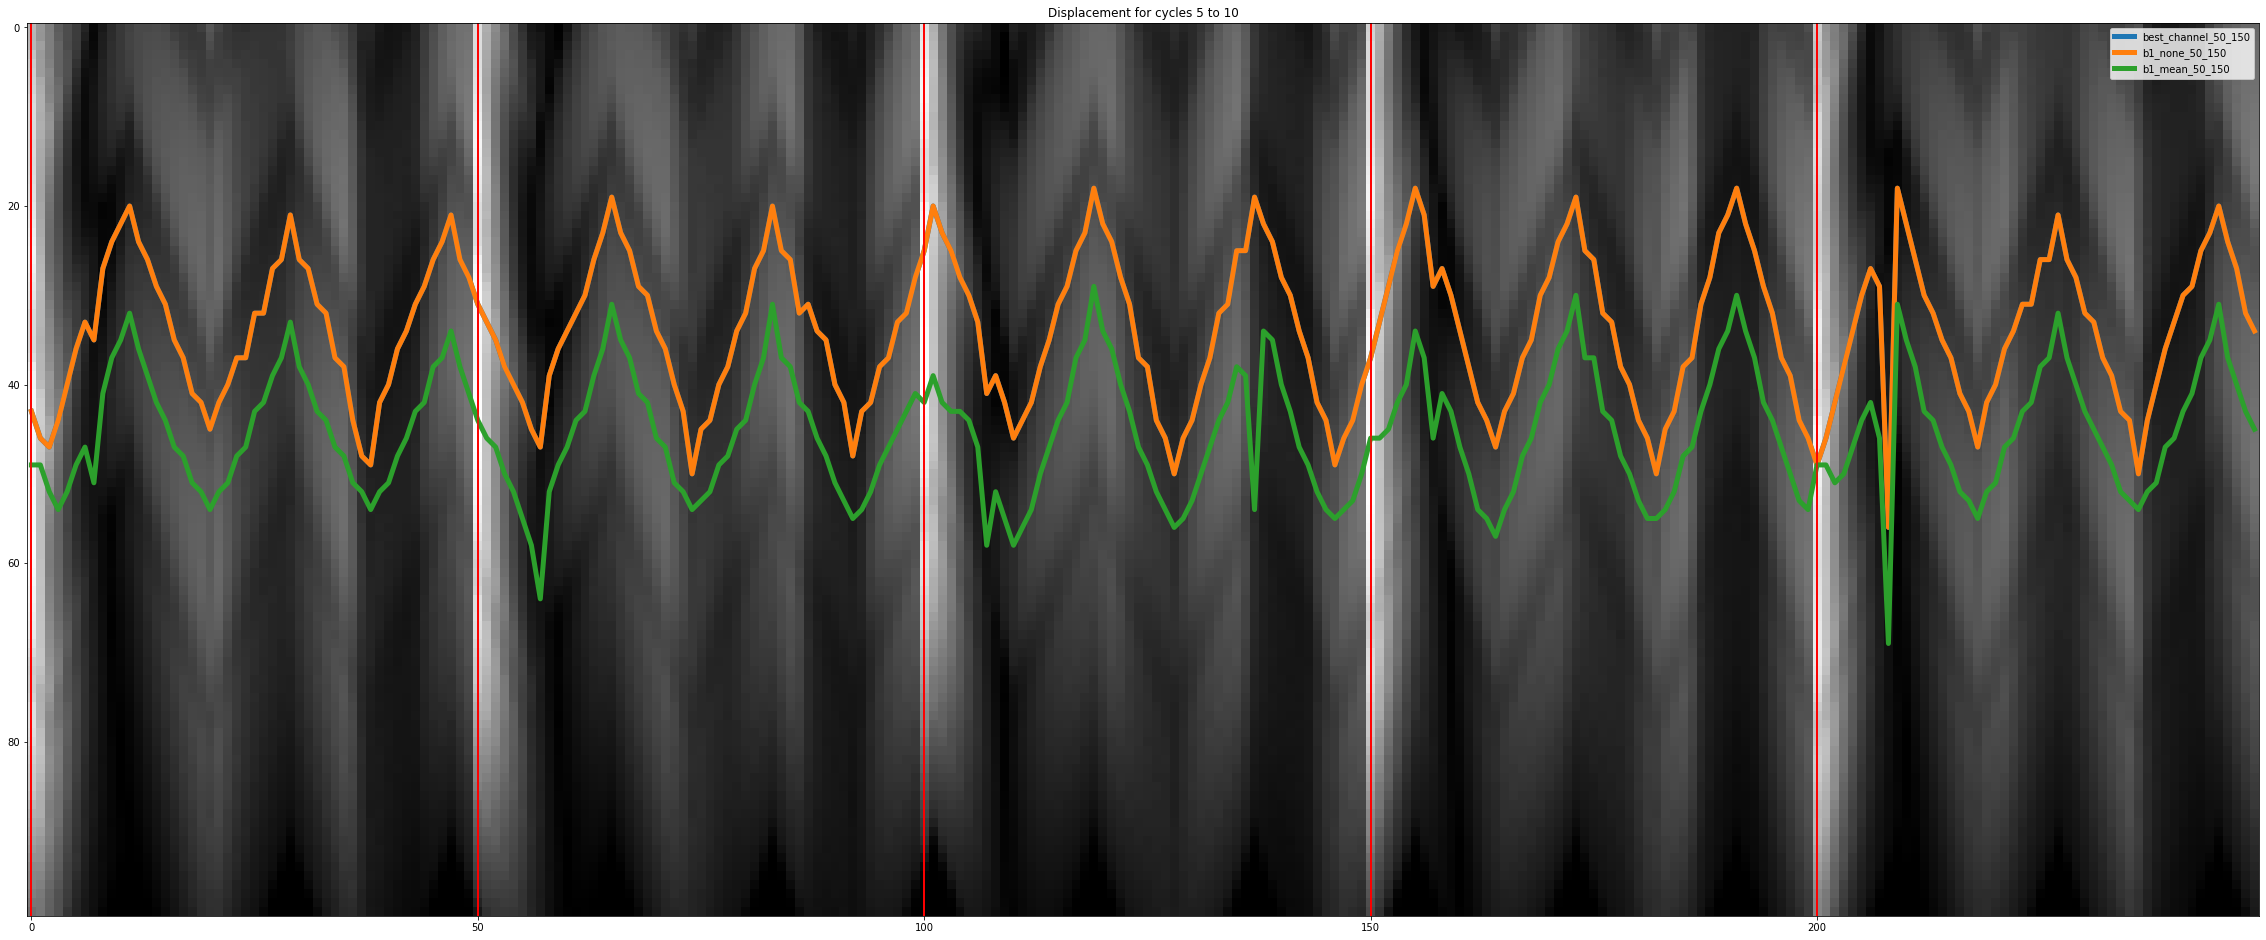

In [212]:
start_cycle = 5
end_cycle=10
plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,bottom=50,top=150,plot_on_same_image=True)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)
(800, 400)
(800, 400)


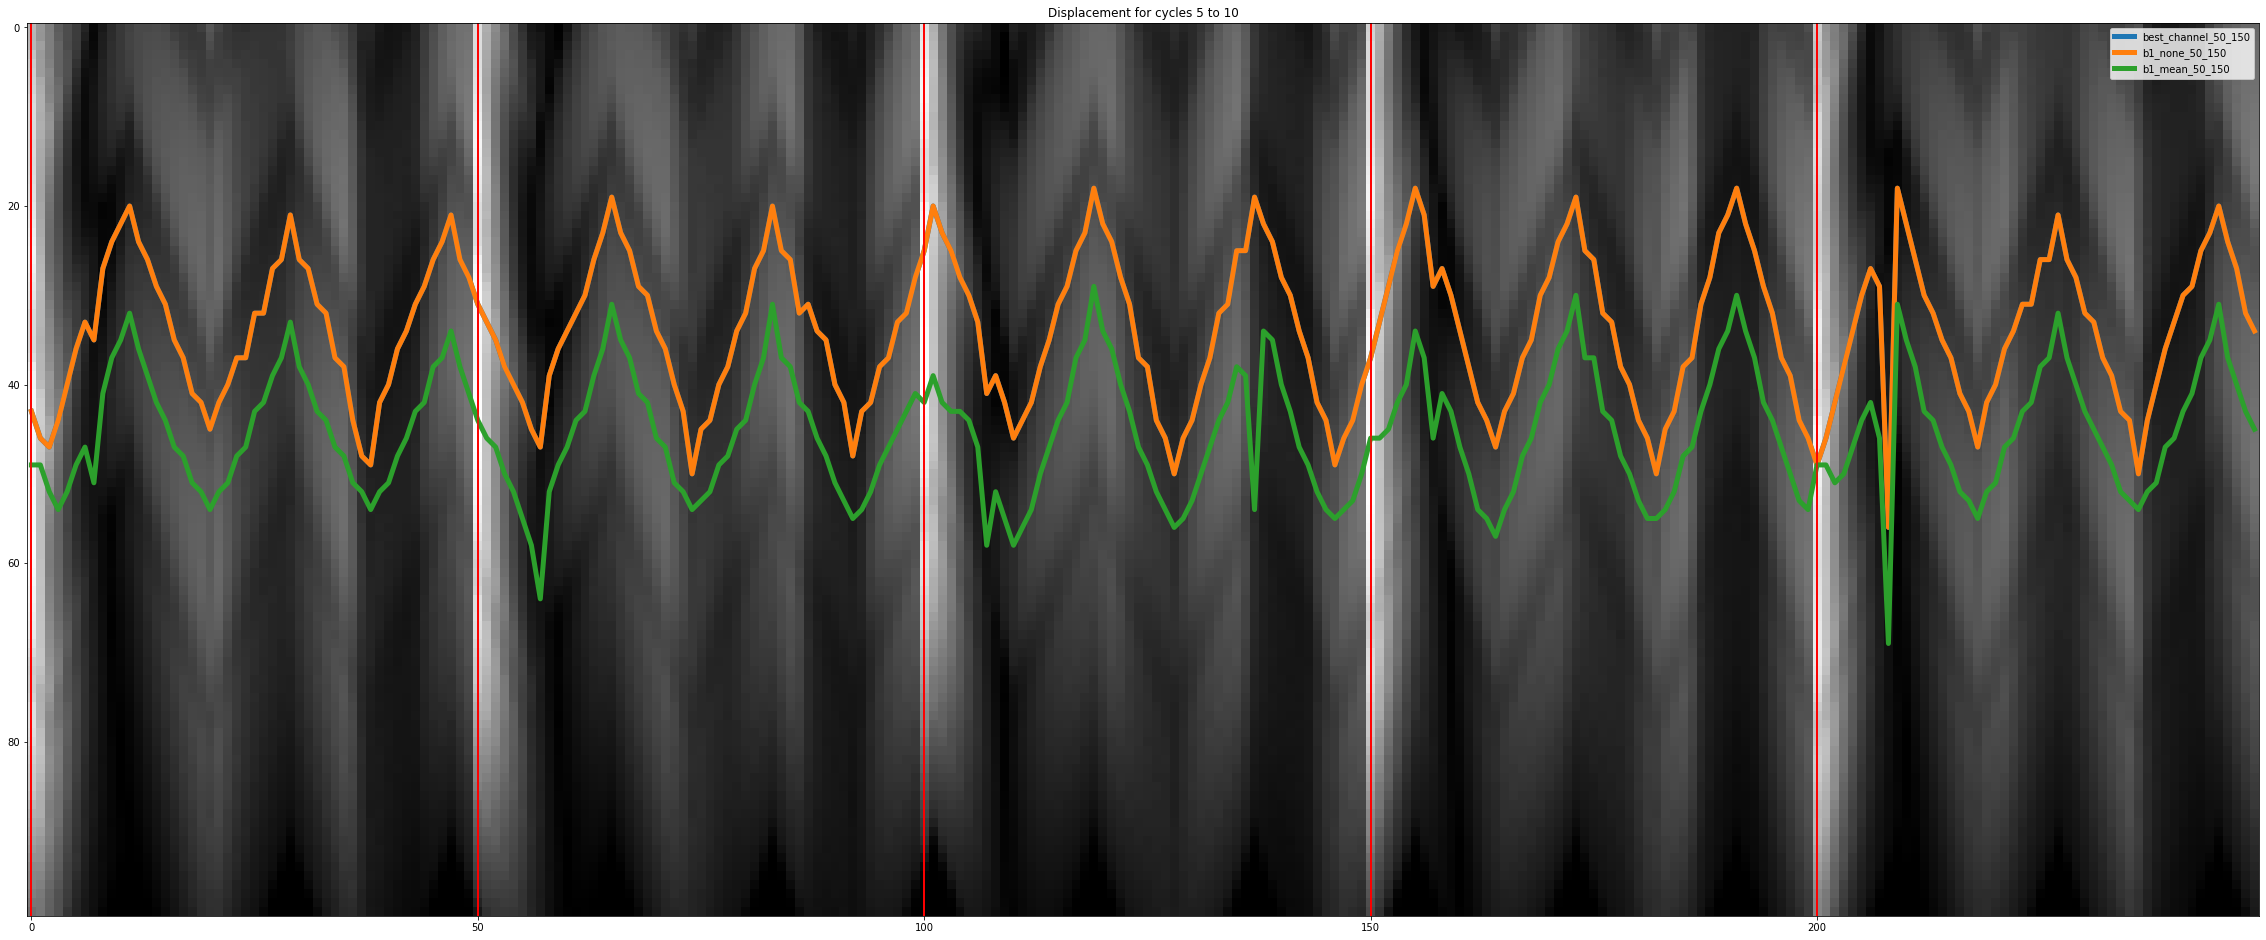

In [213]:
start_cycle = 5
end_cycle=10
plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,bottom=50,top=150,plot_on_same_image=True)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)
(800, 400)
(800, 400)


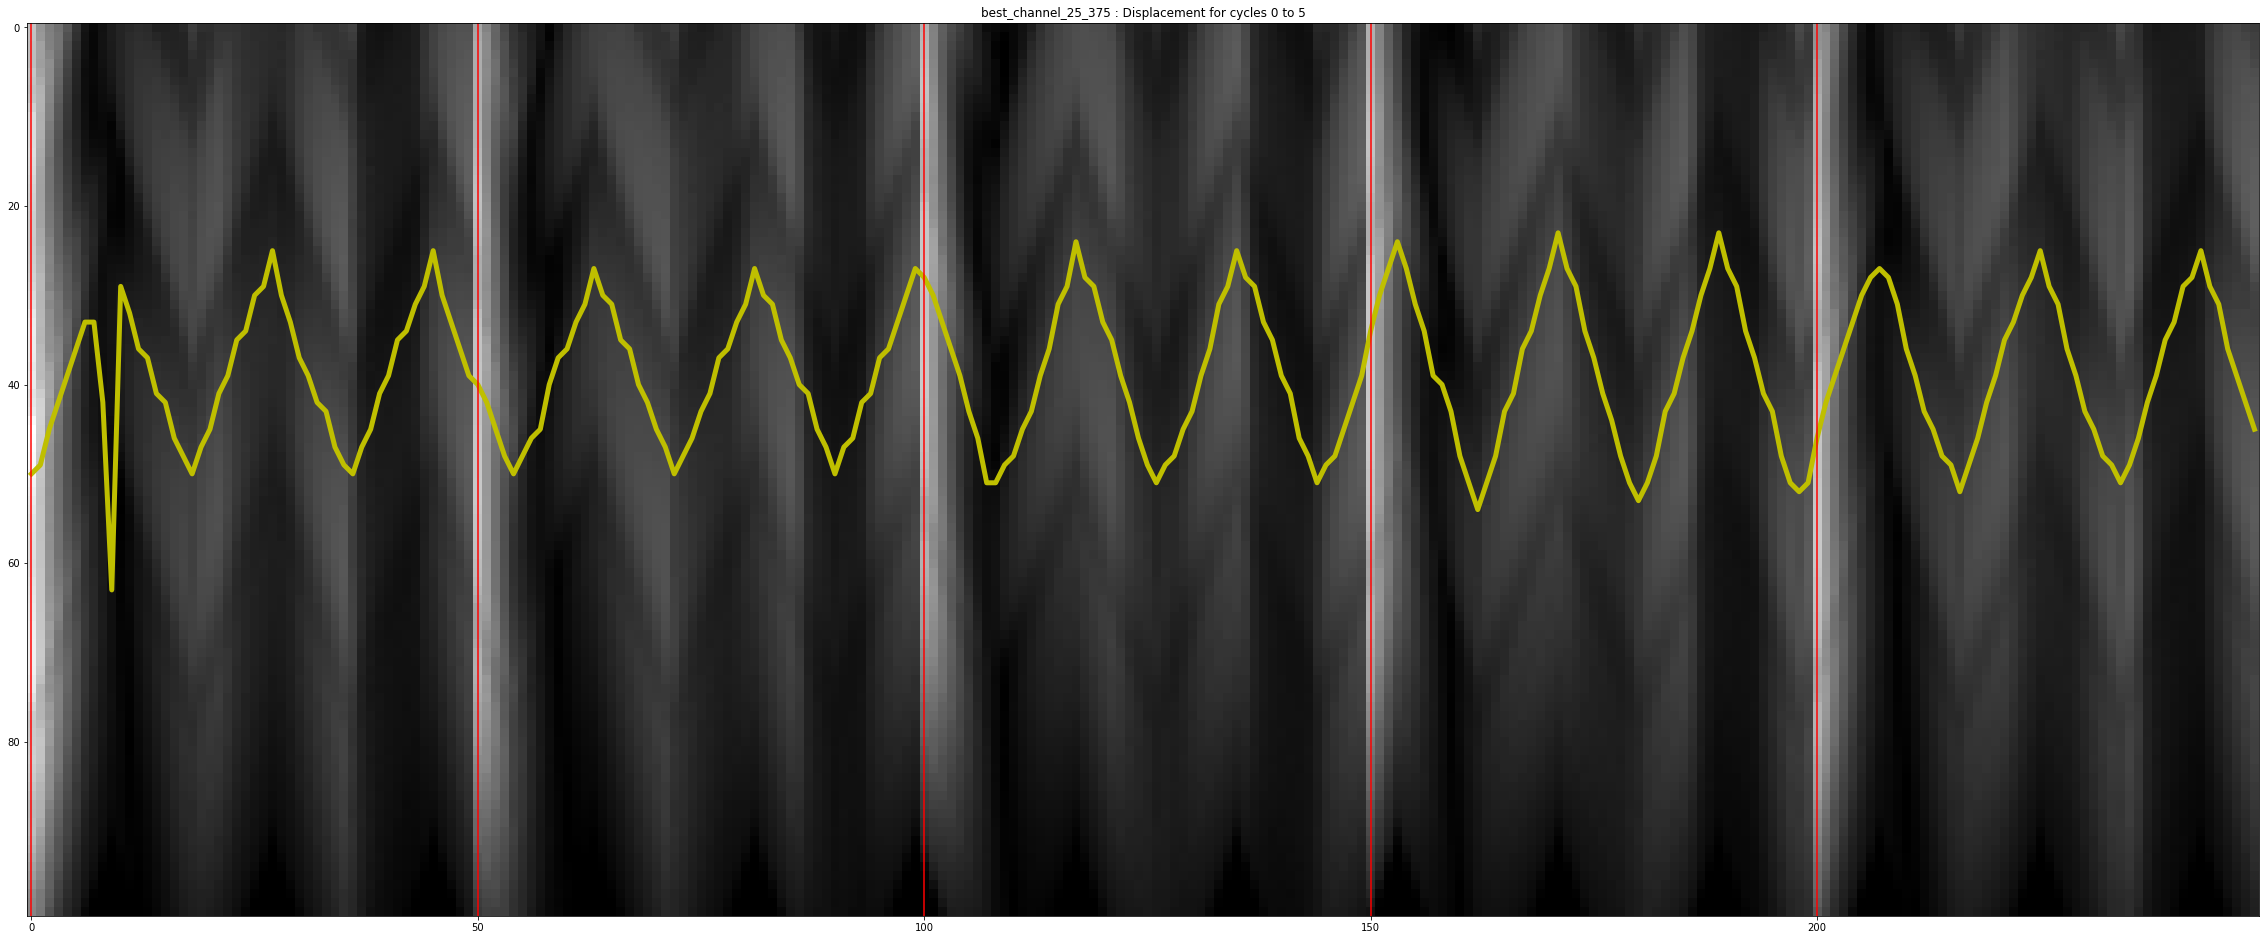

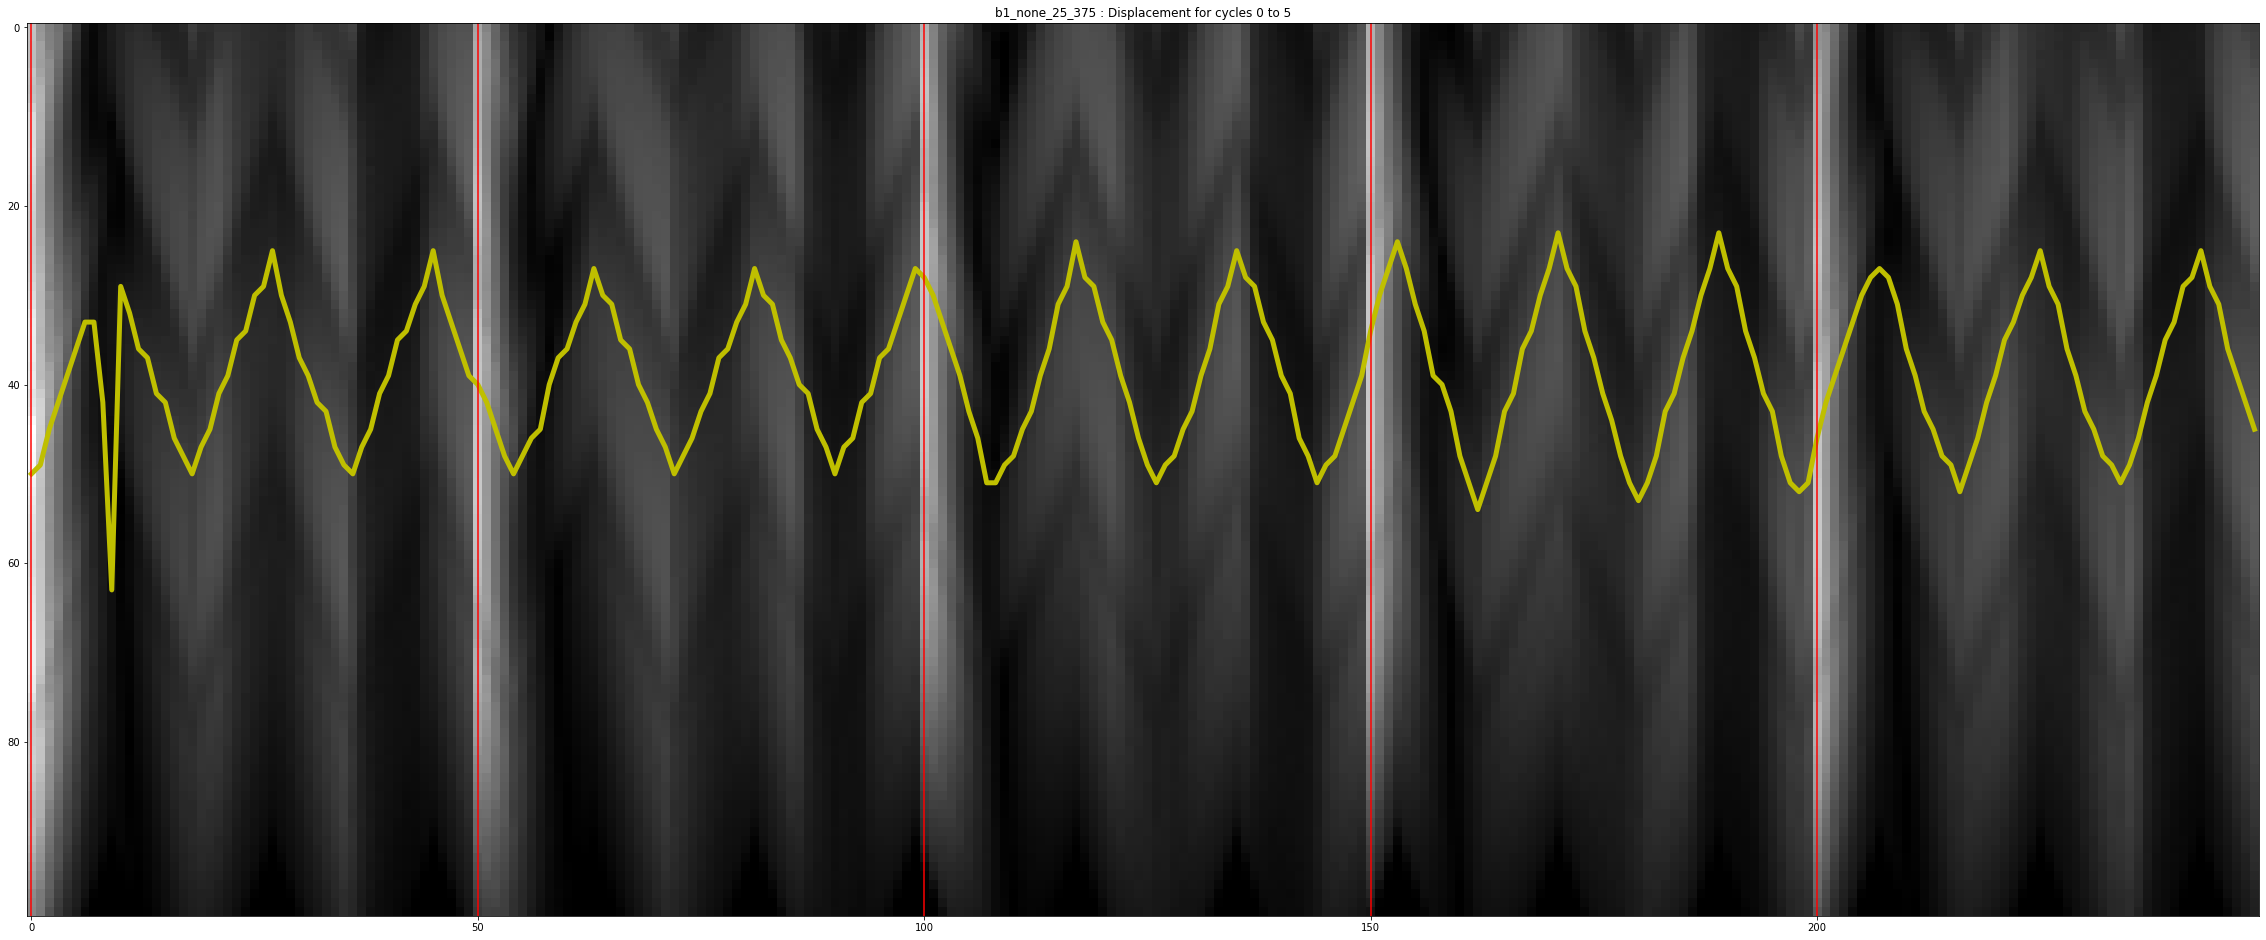

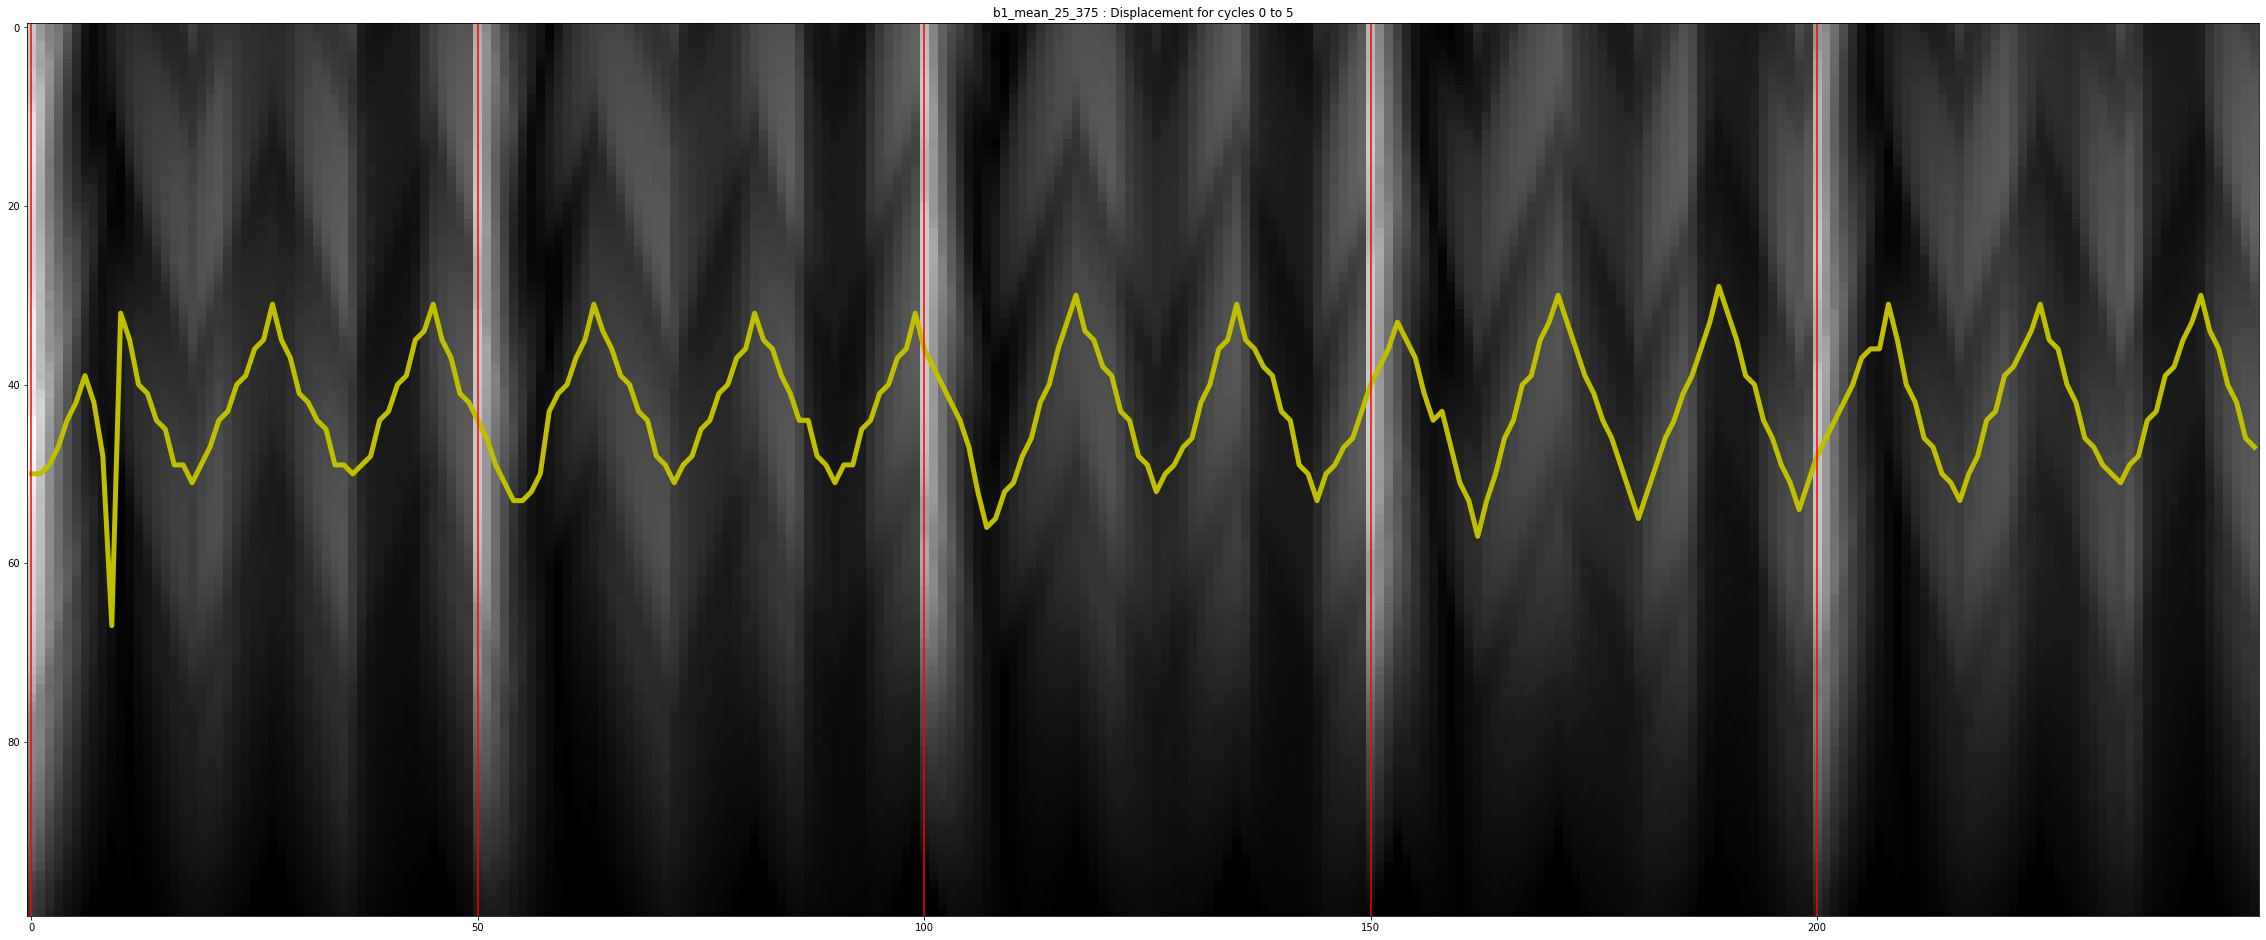

In [214]:
start_cycle = 0
end_cycle=5
plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,bottom=25,top=375)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)
(800, 400)
(800, 400)


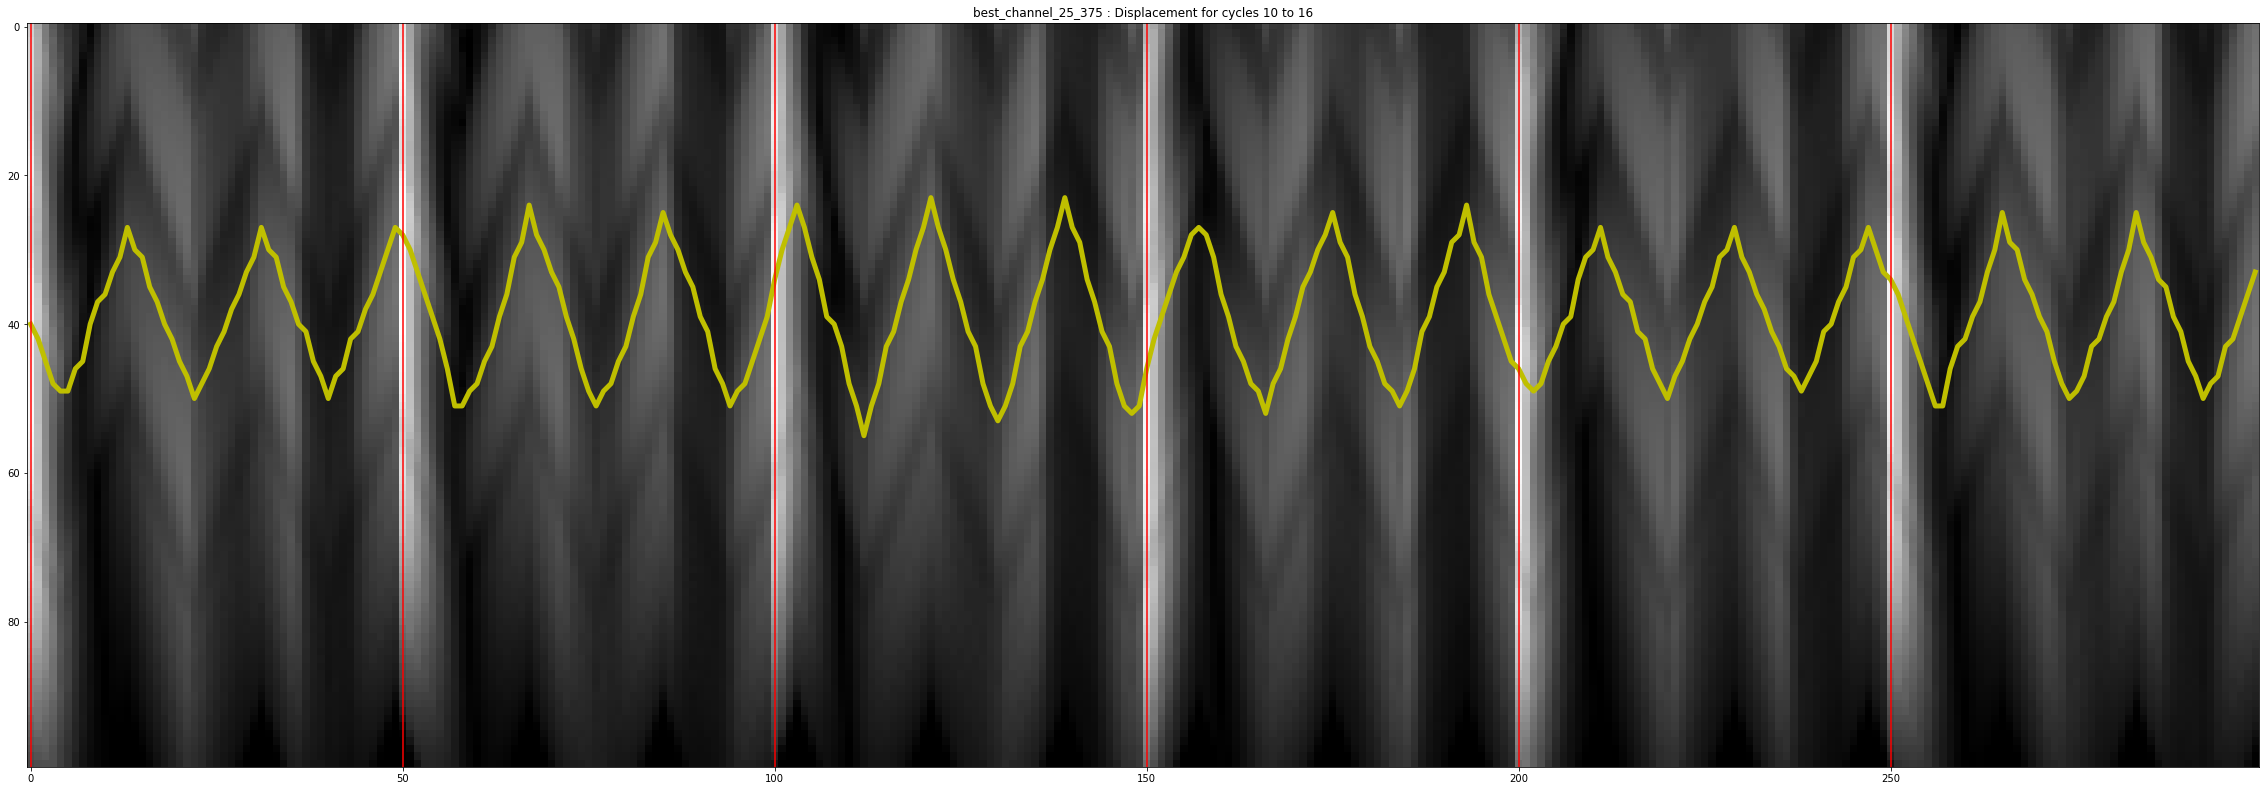

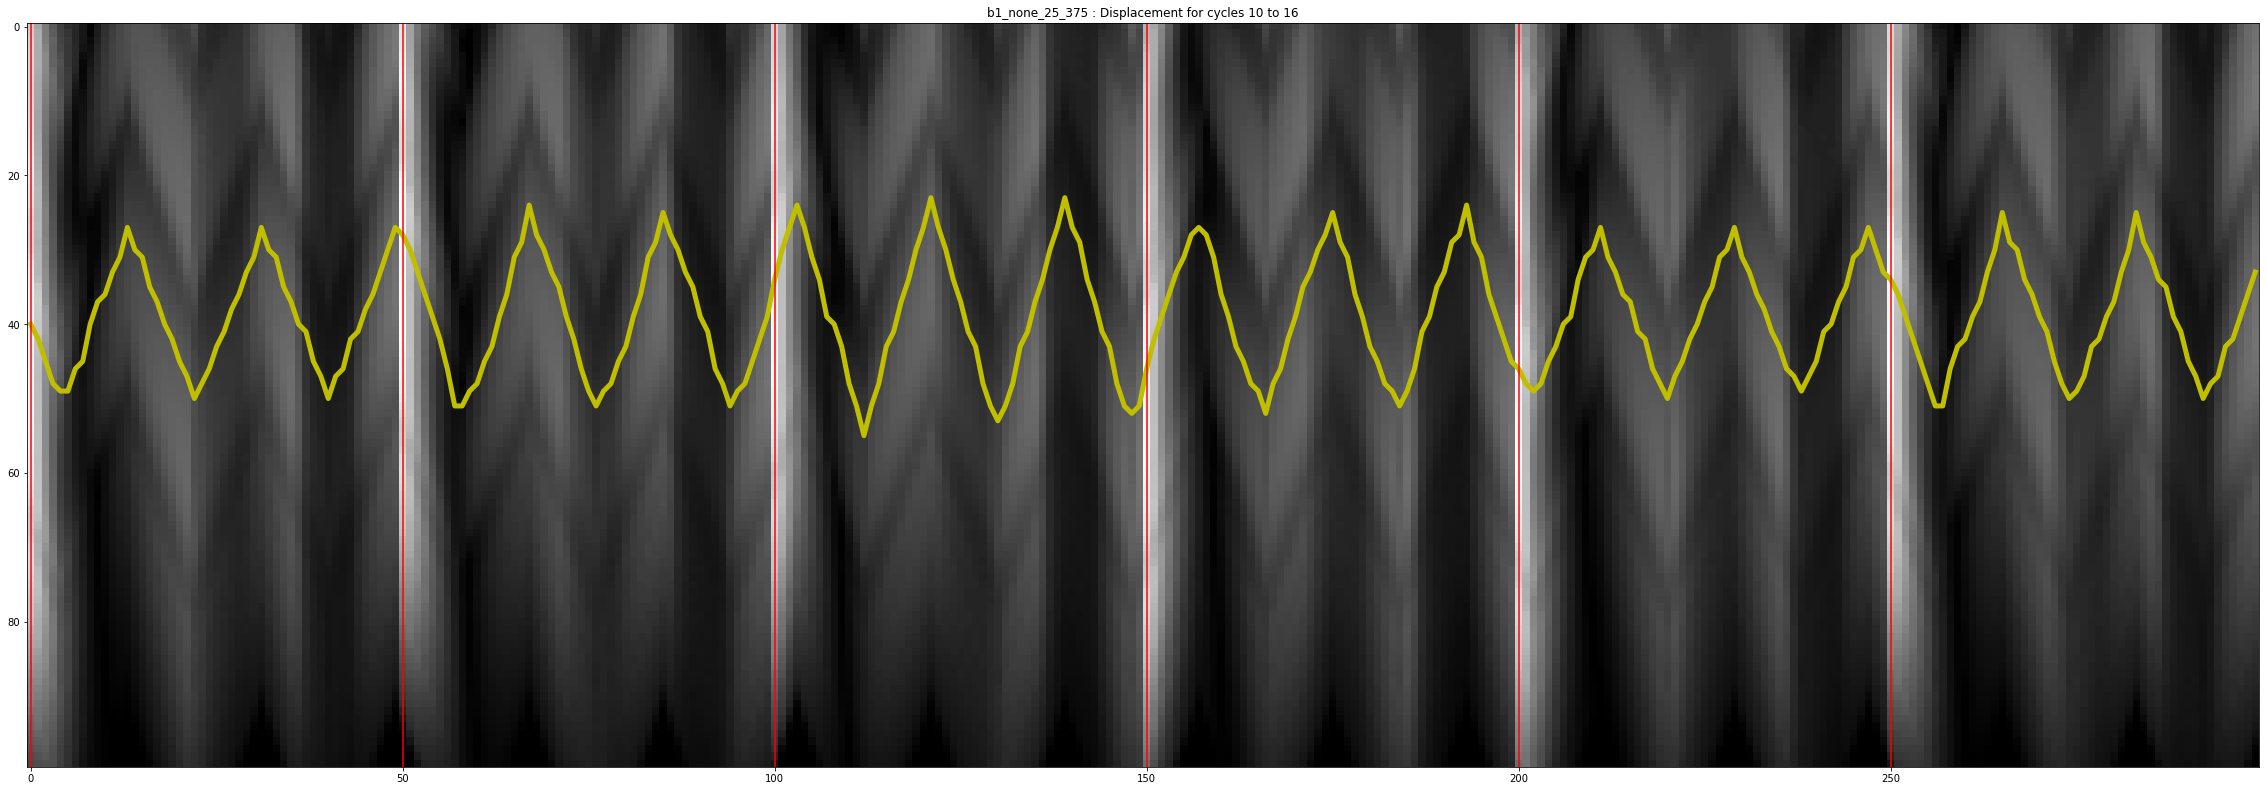

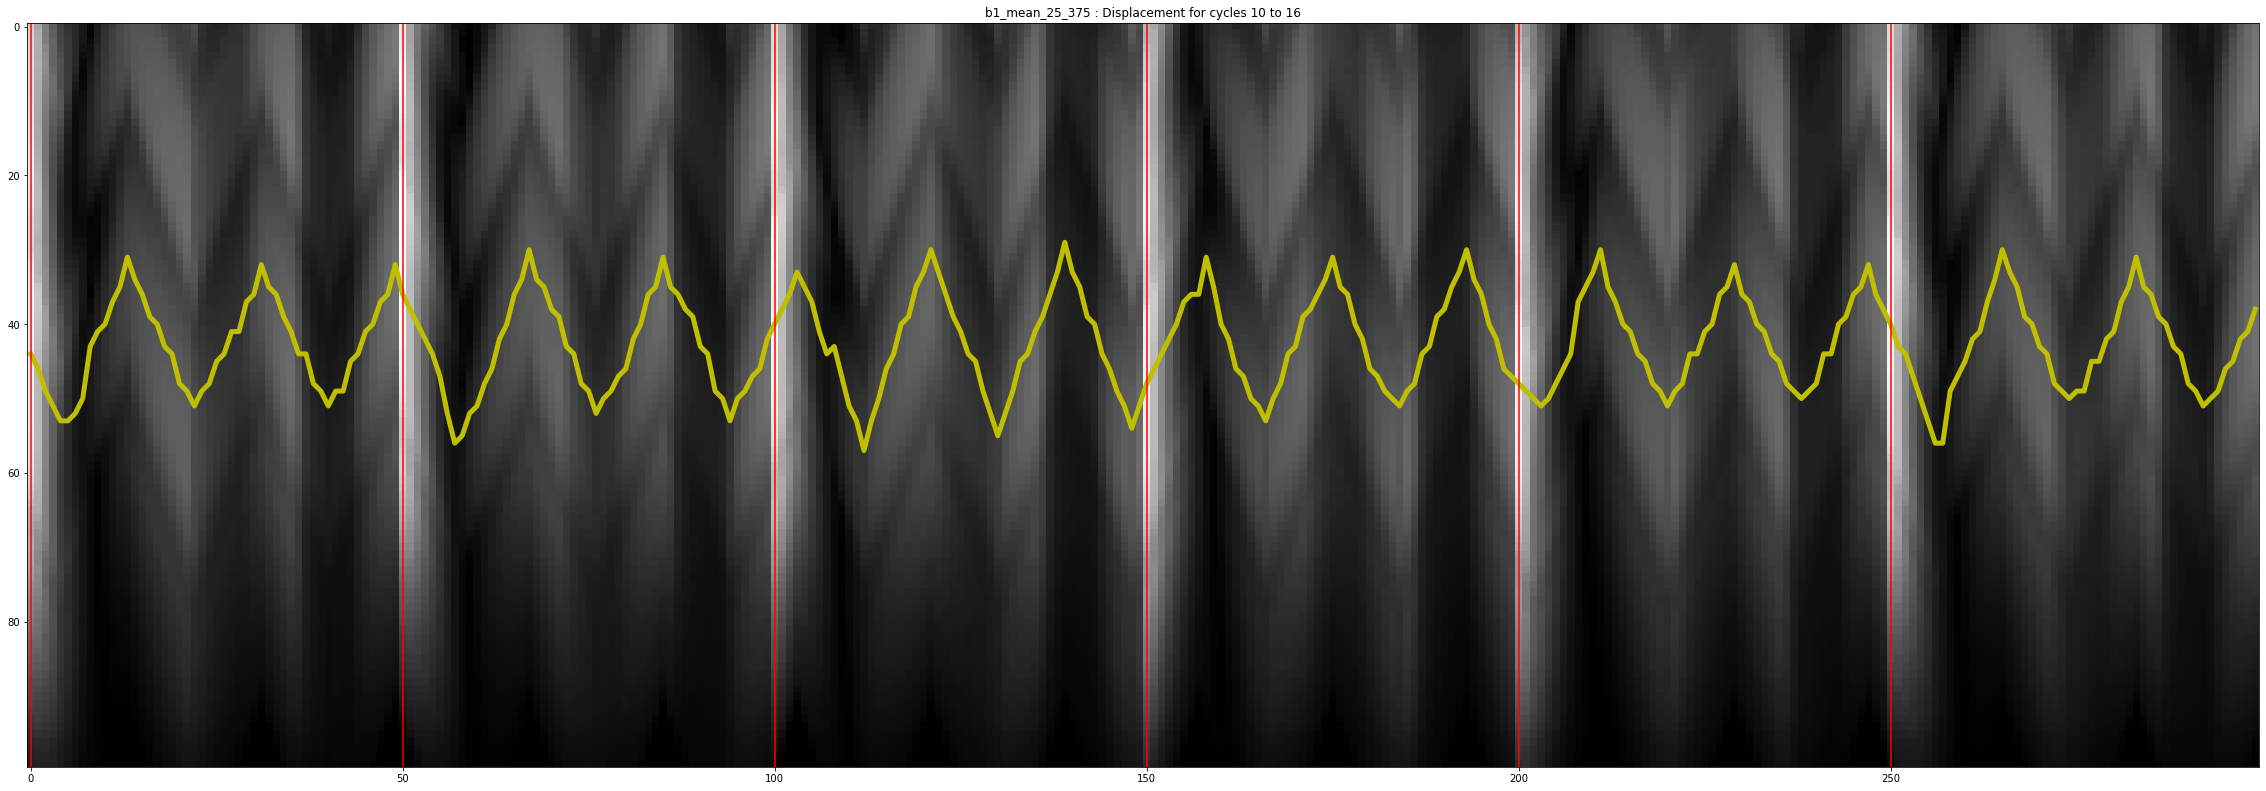

In [215]:
start_cycle = 10
end_cycle=nb_slices
plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,bottom=25,top=375)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)


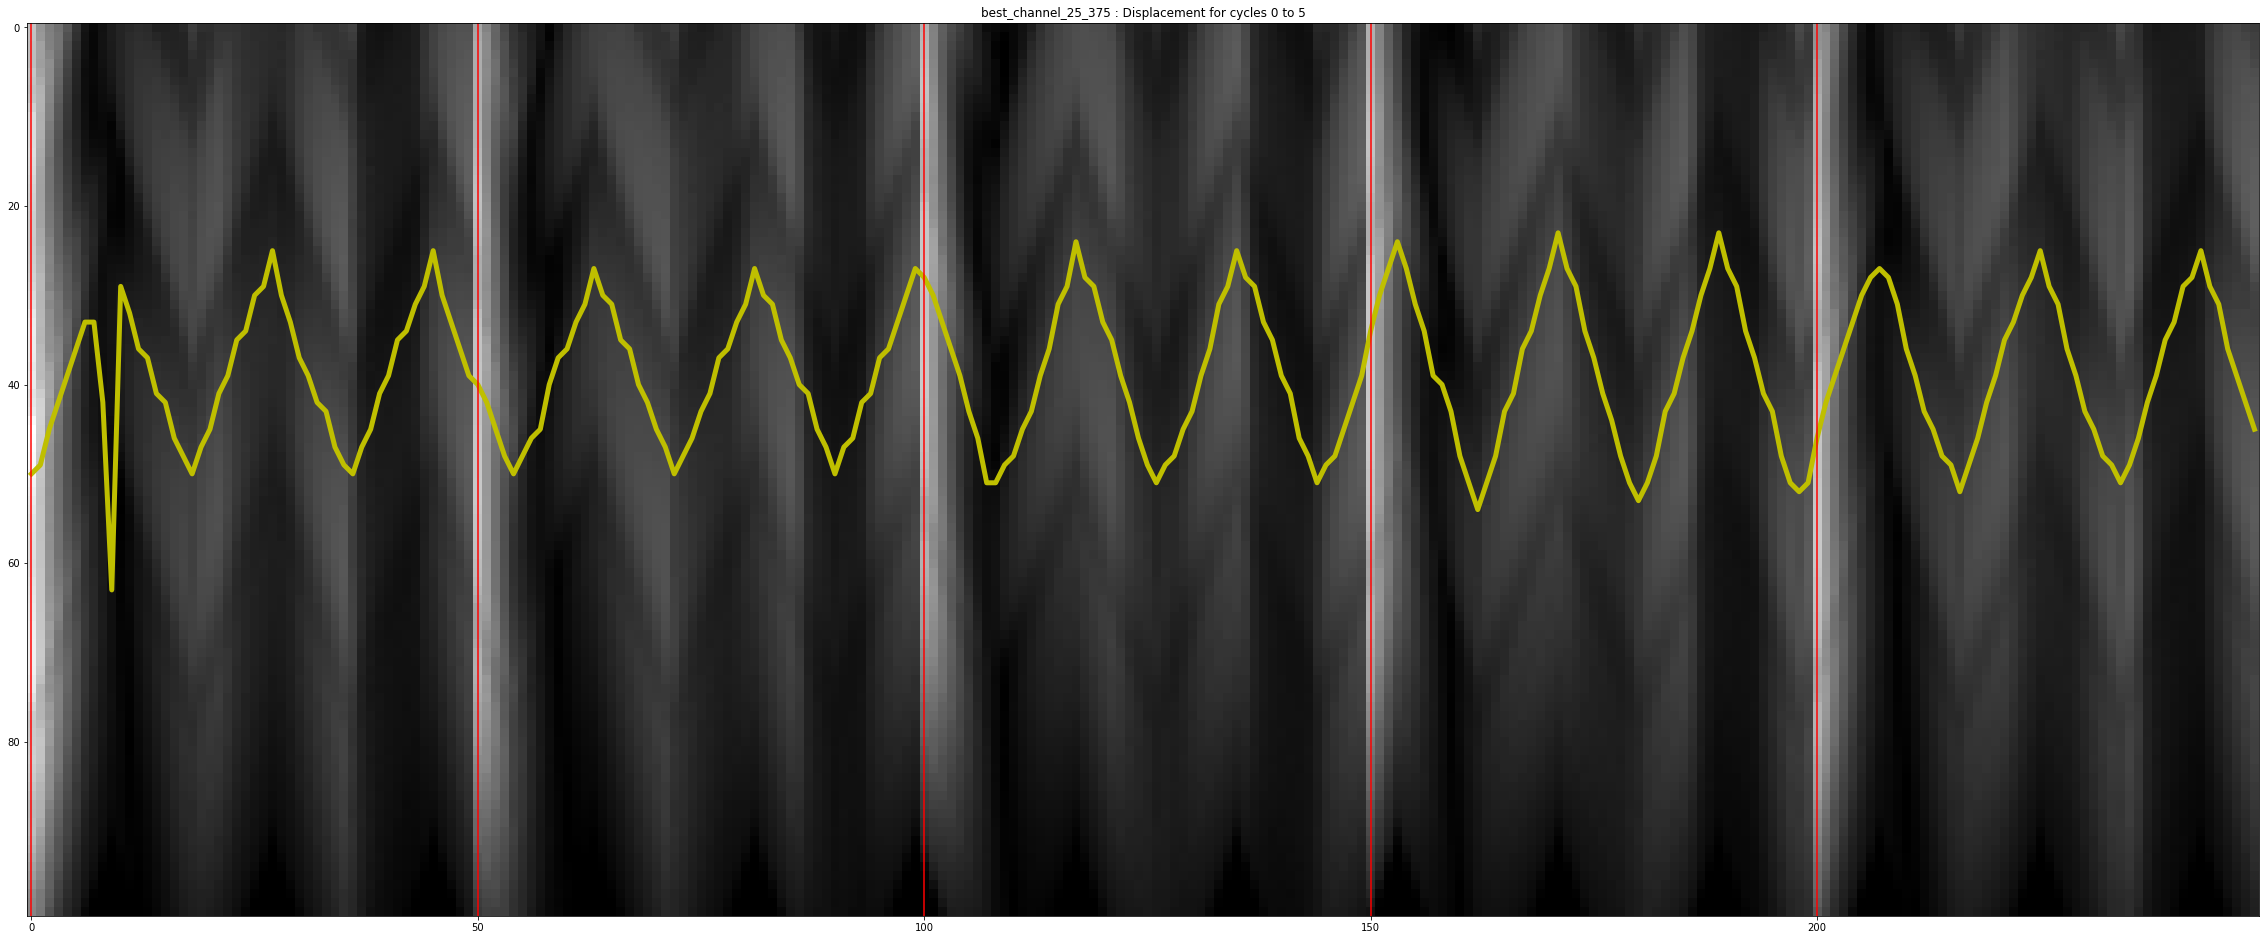

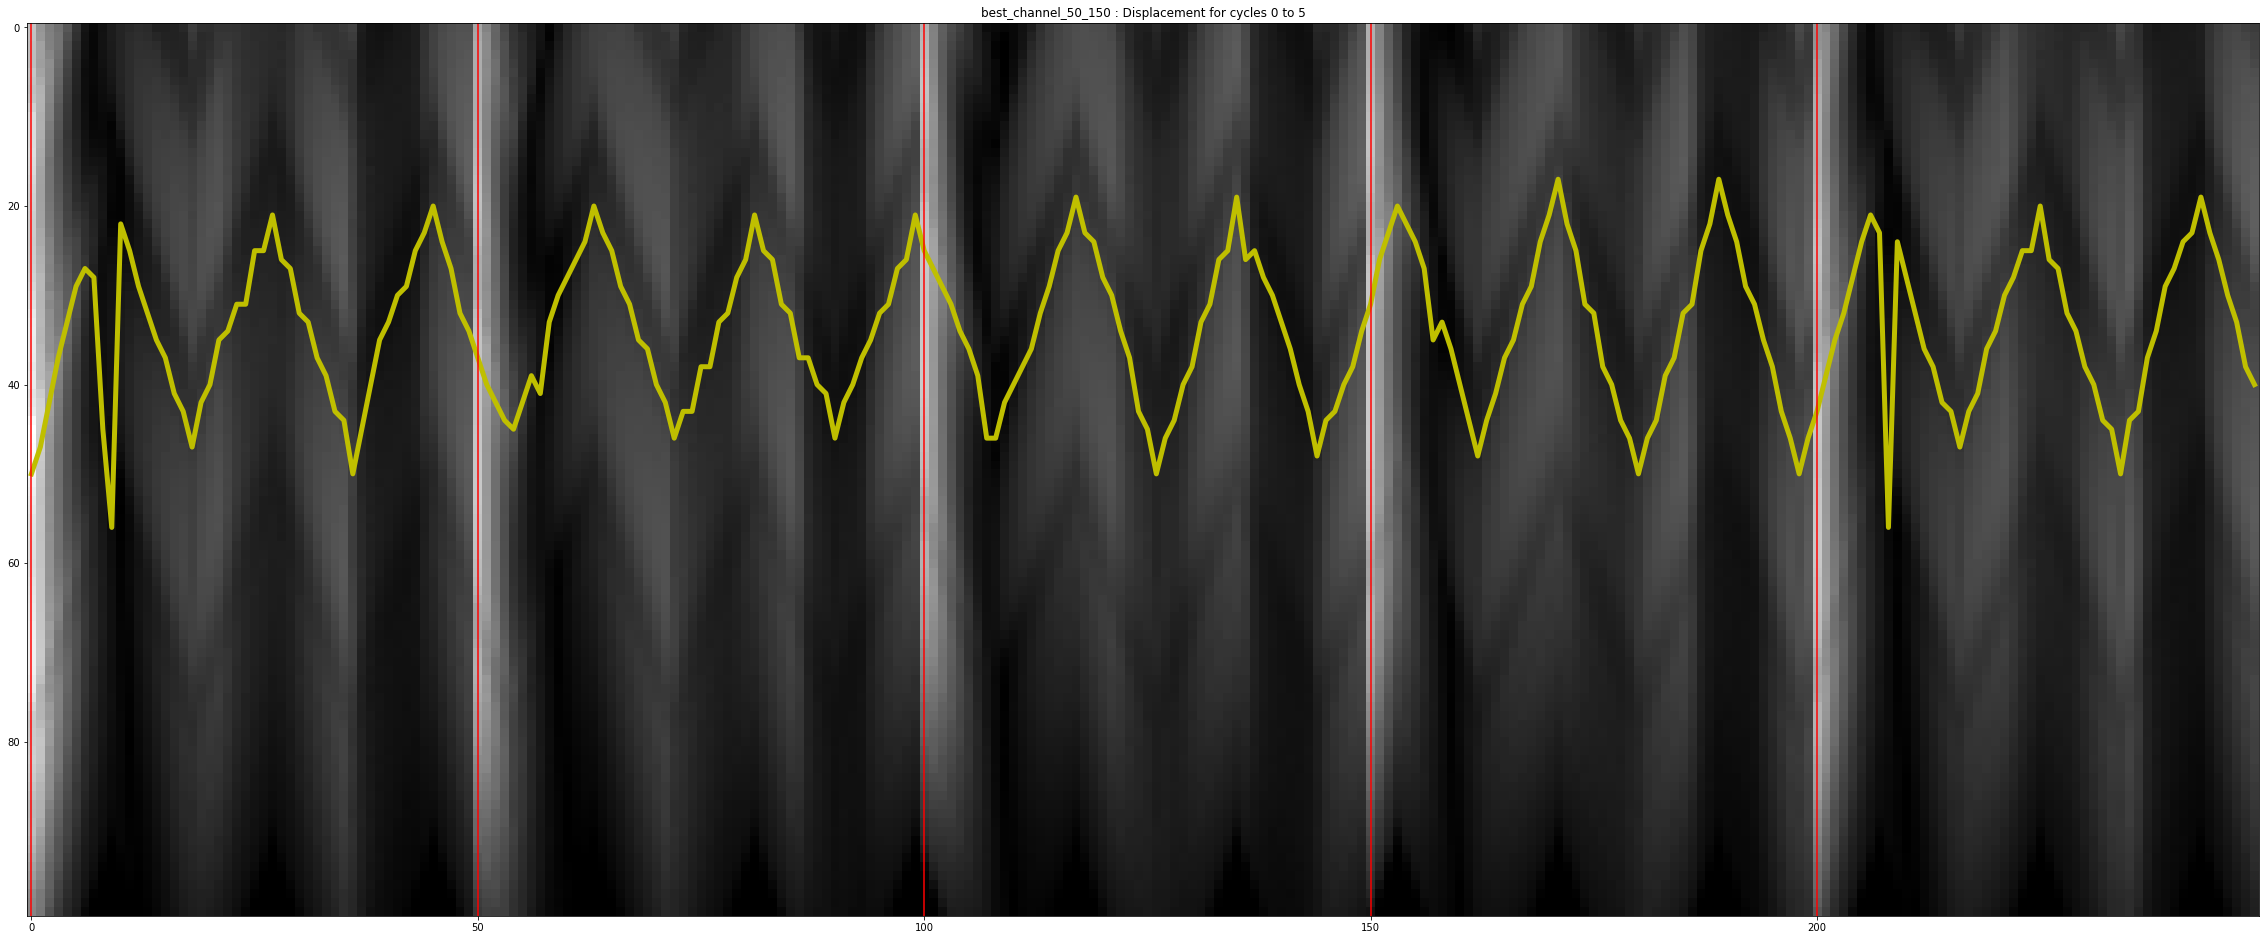

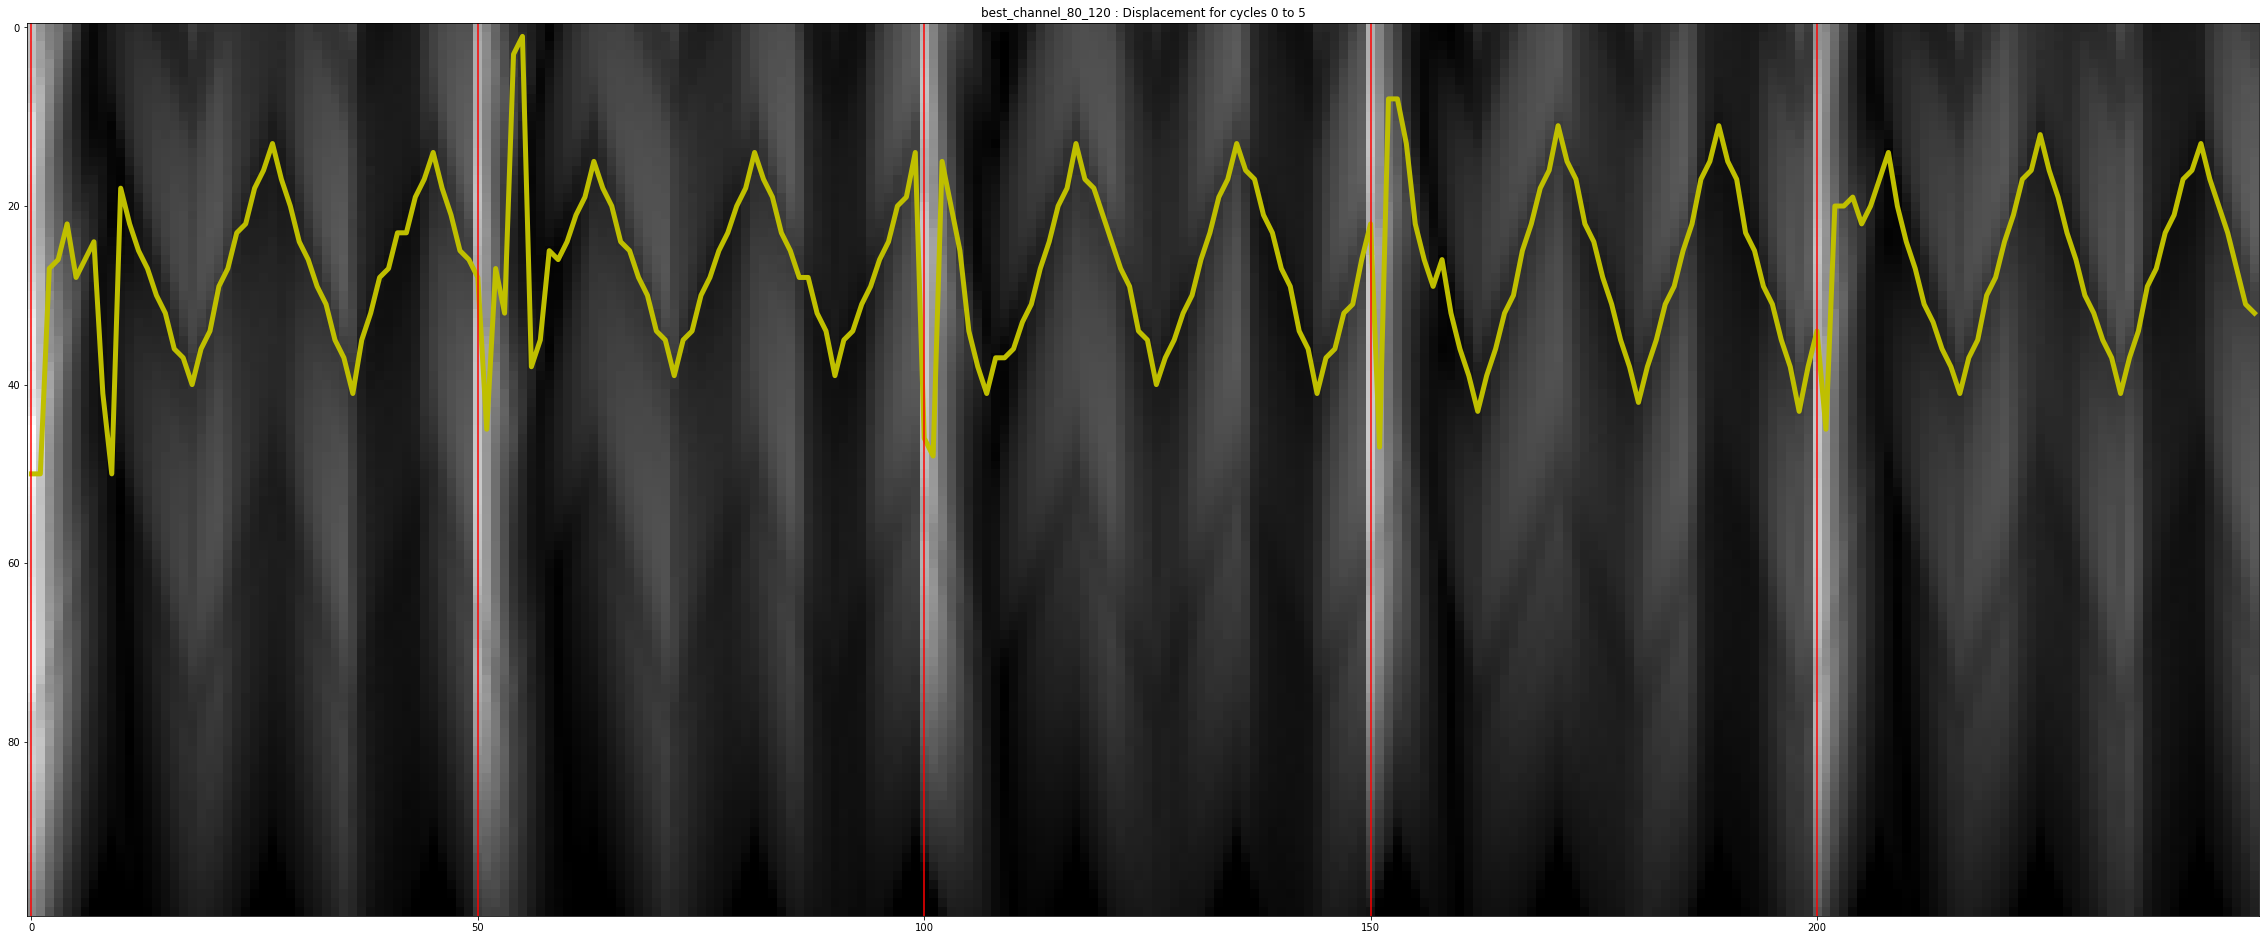

In [216]:
start_cycle = 0
end_cycle=5
plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,serie=["best_channel"])

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)


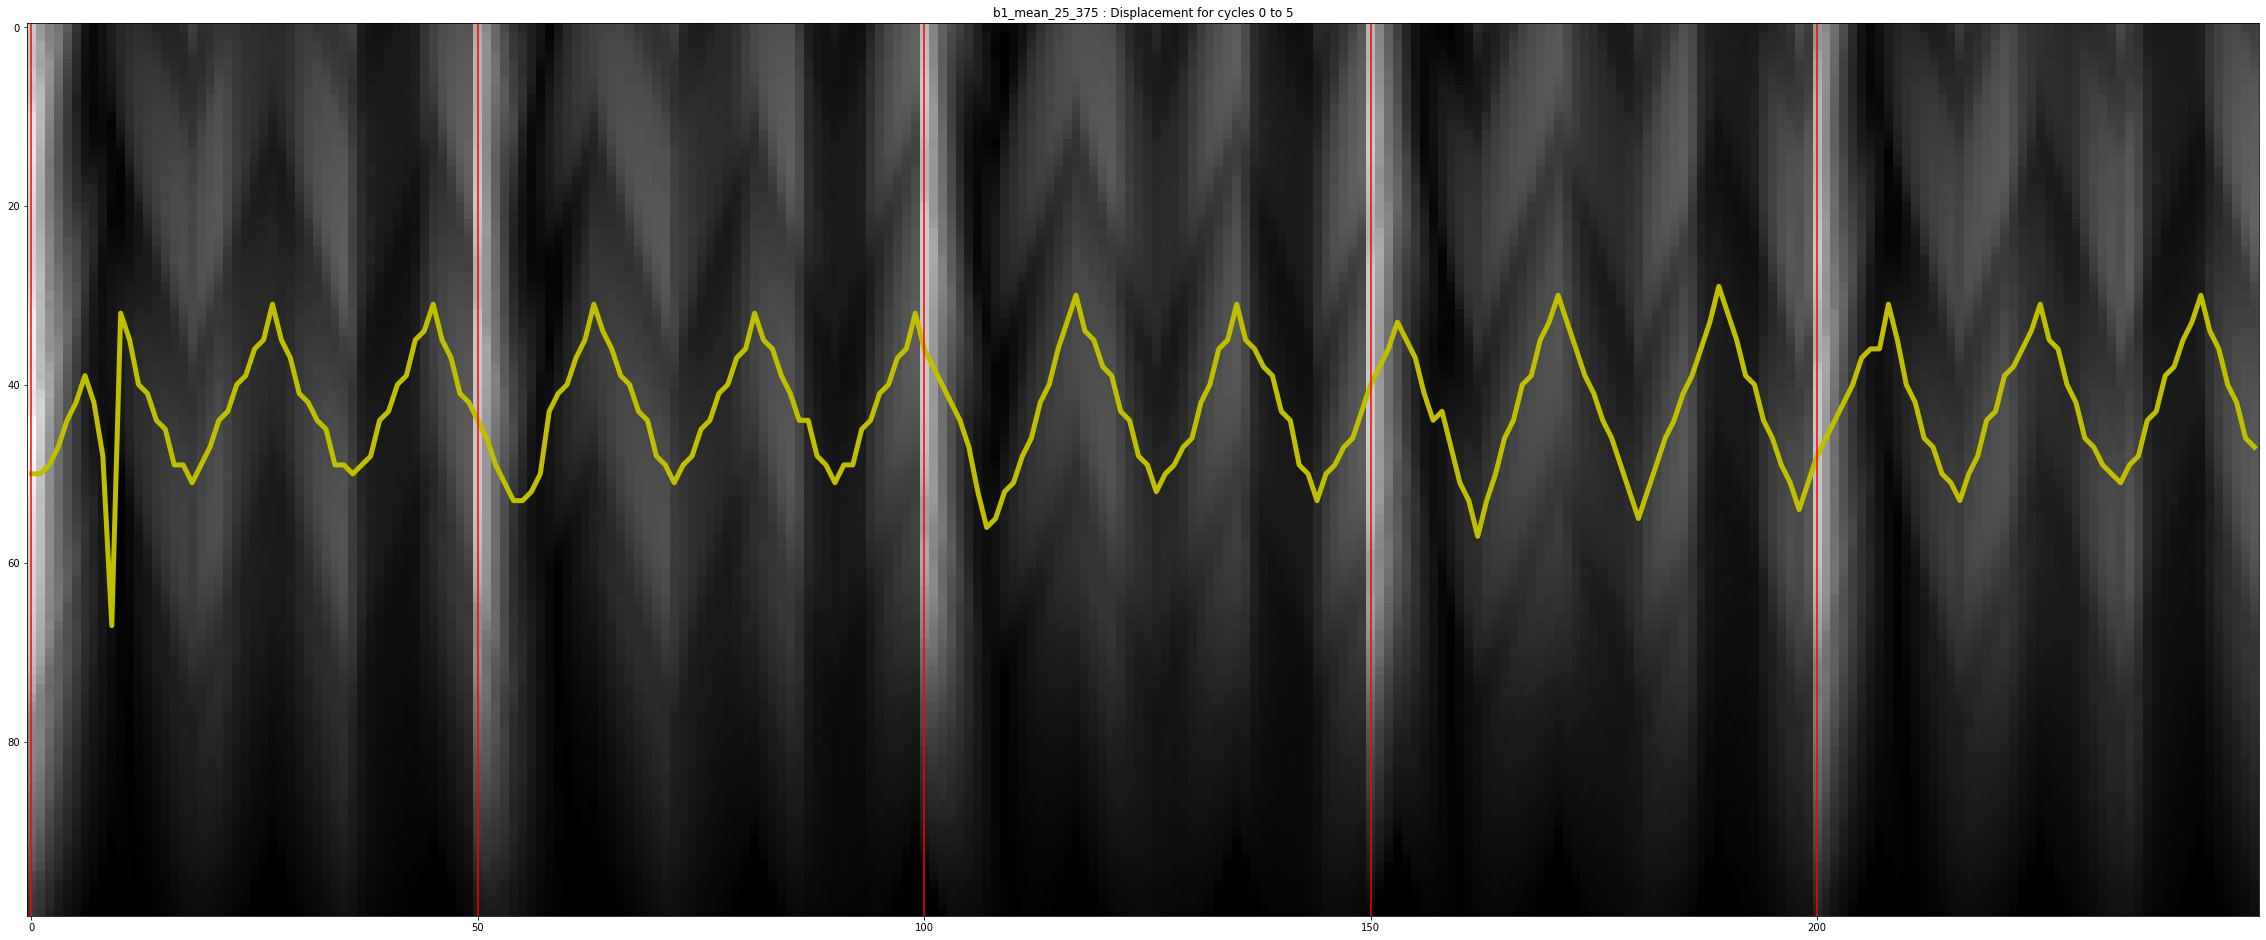

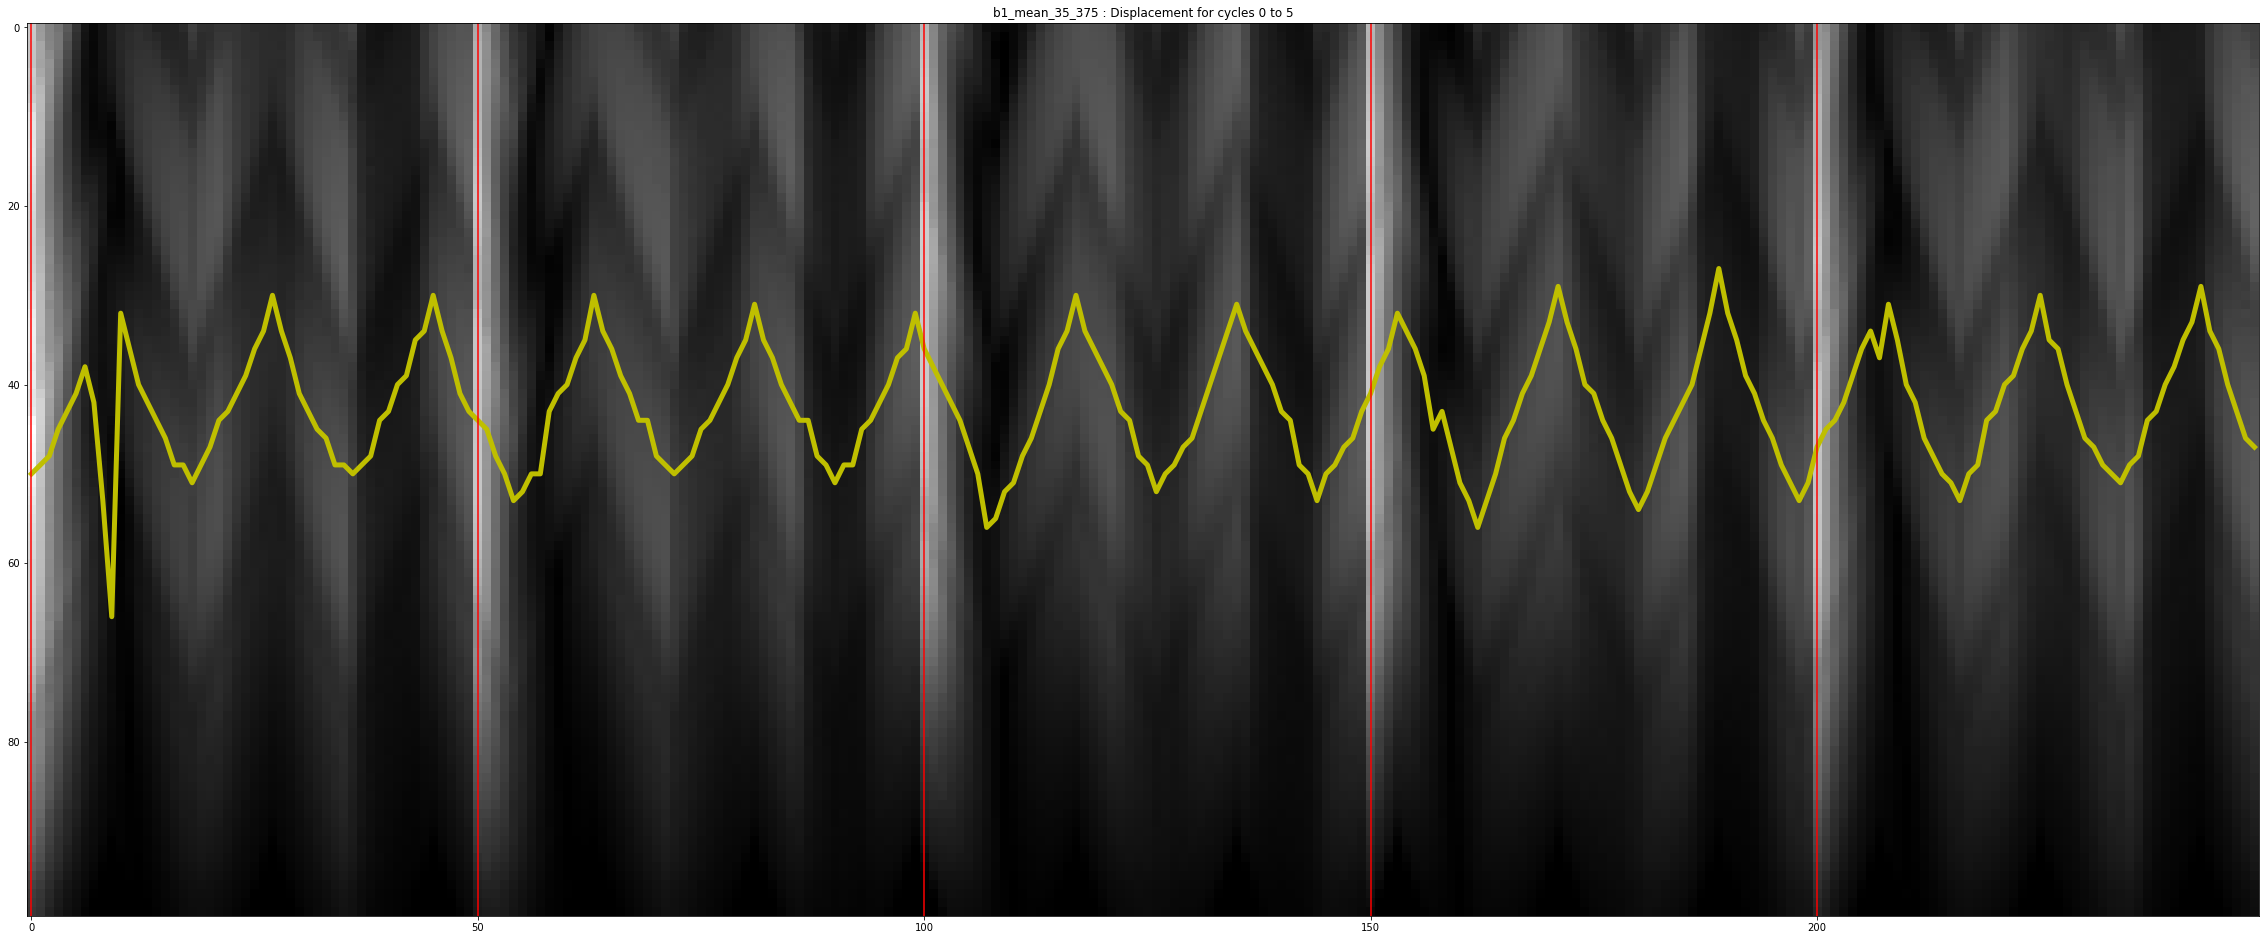

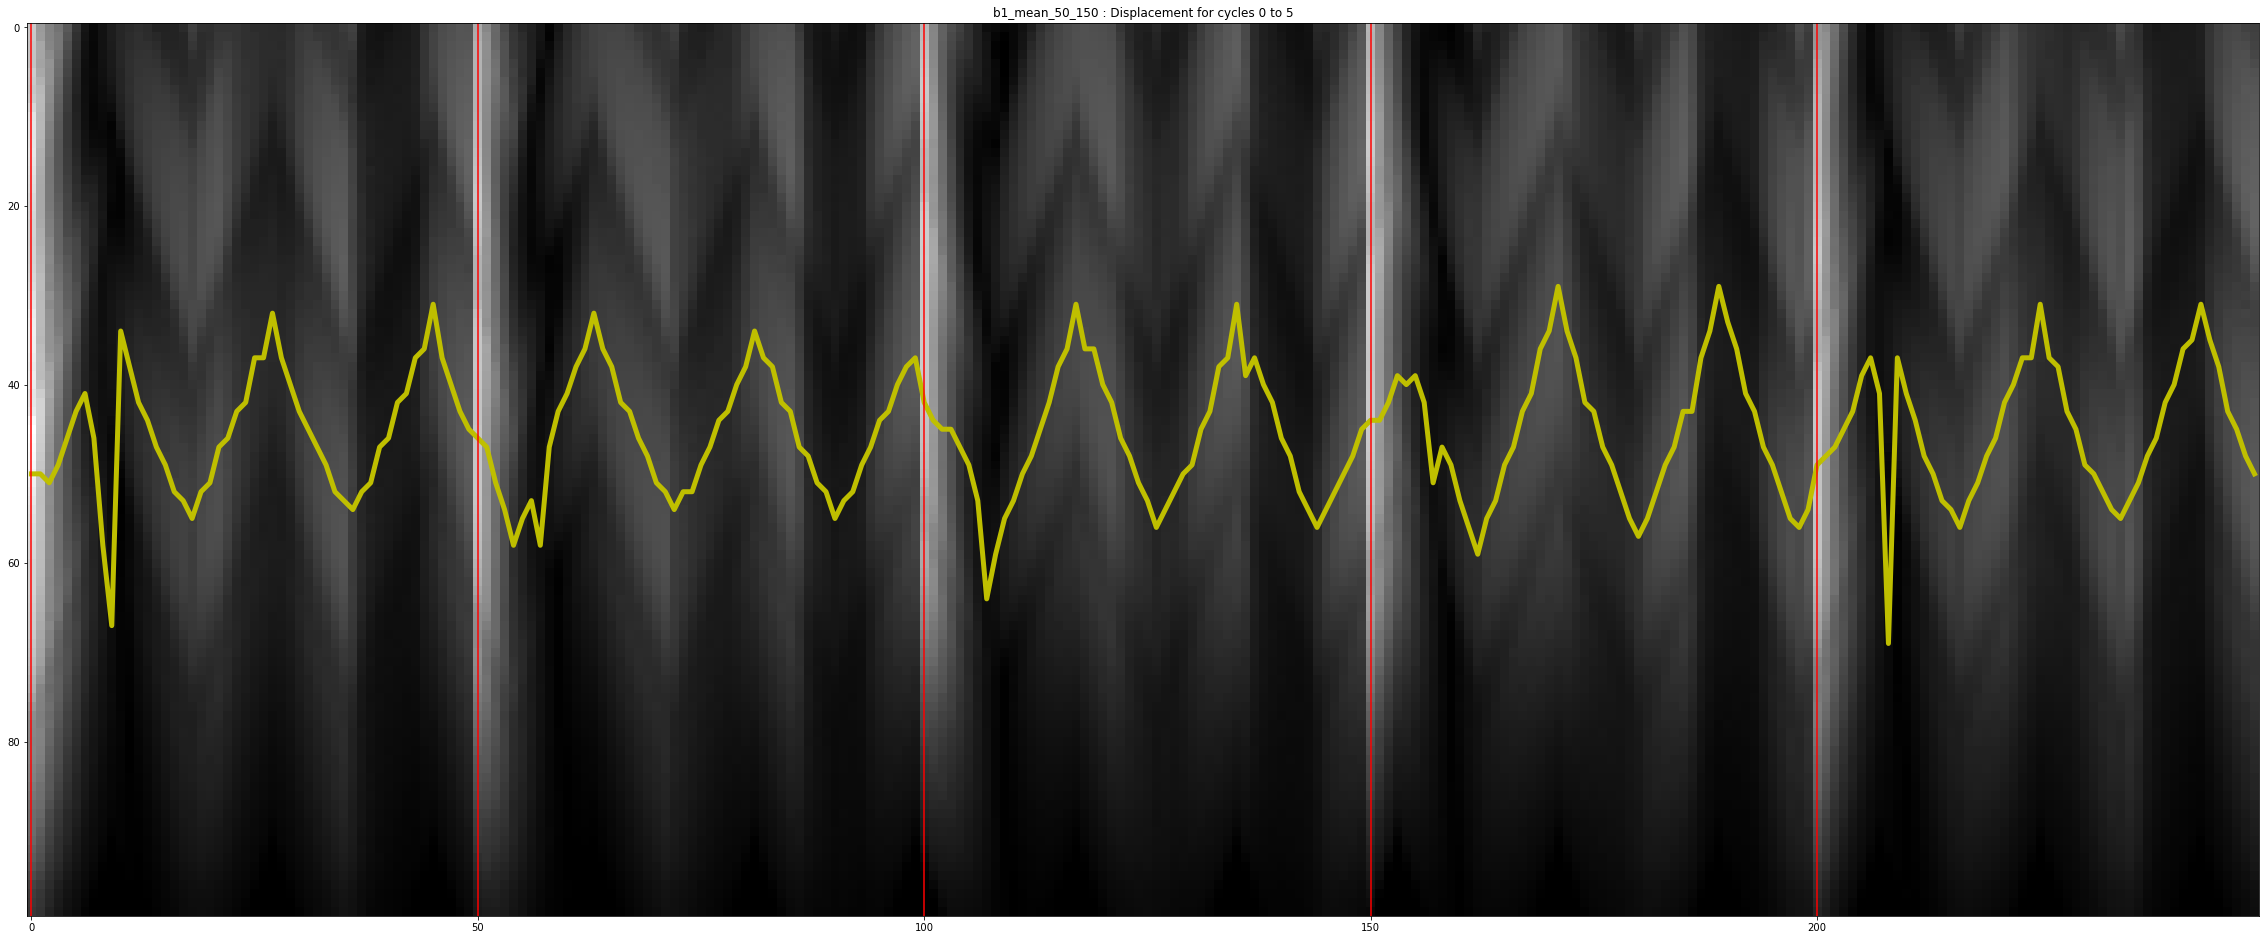

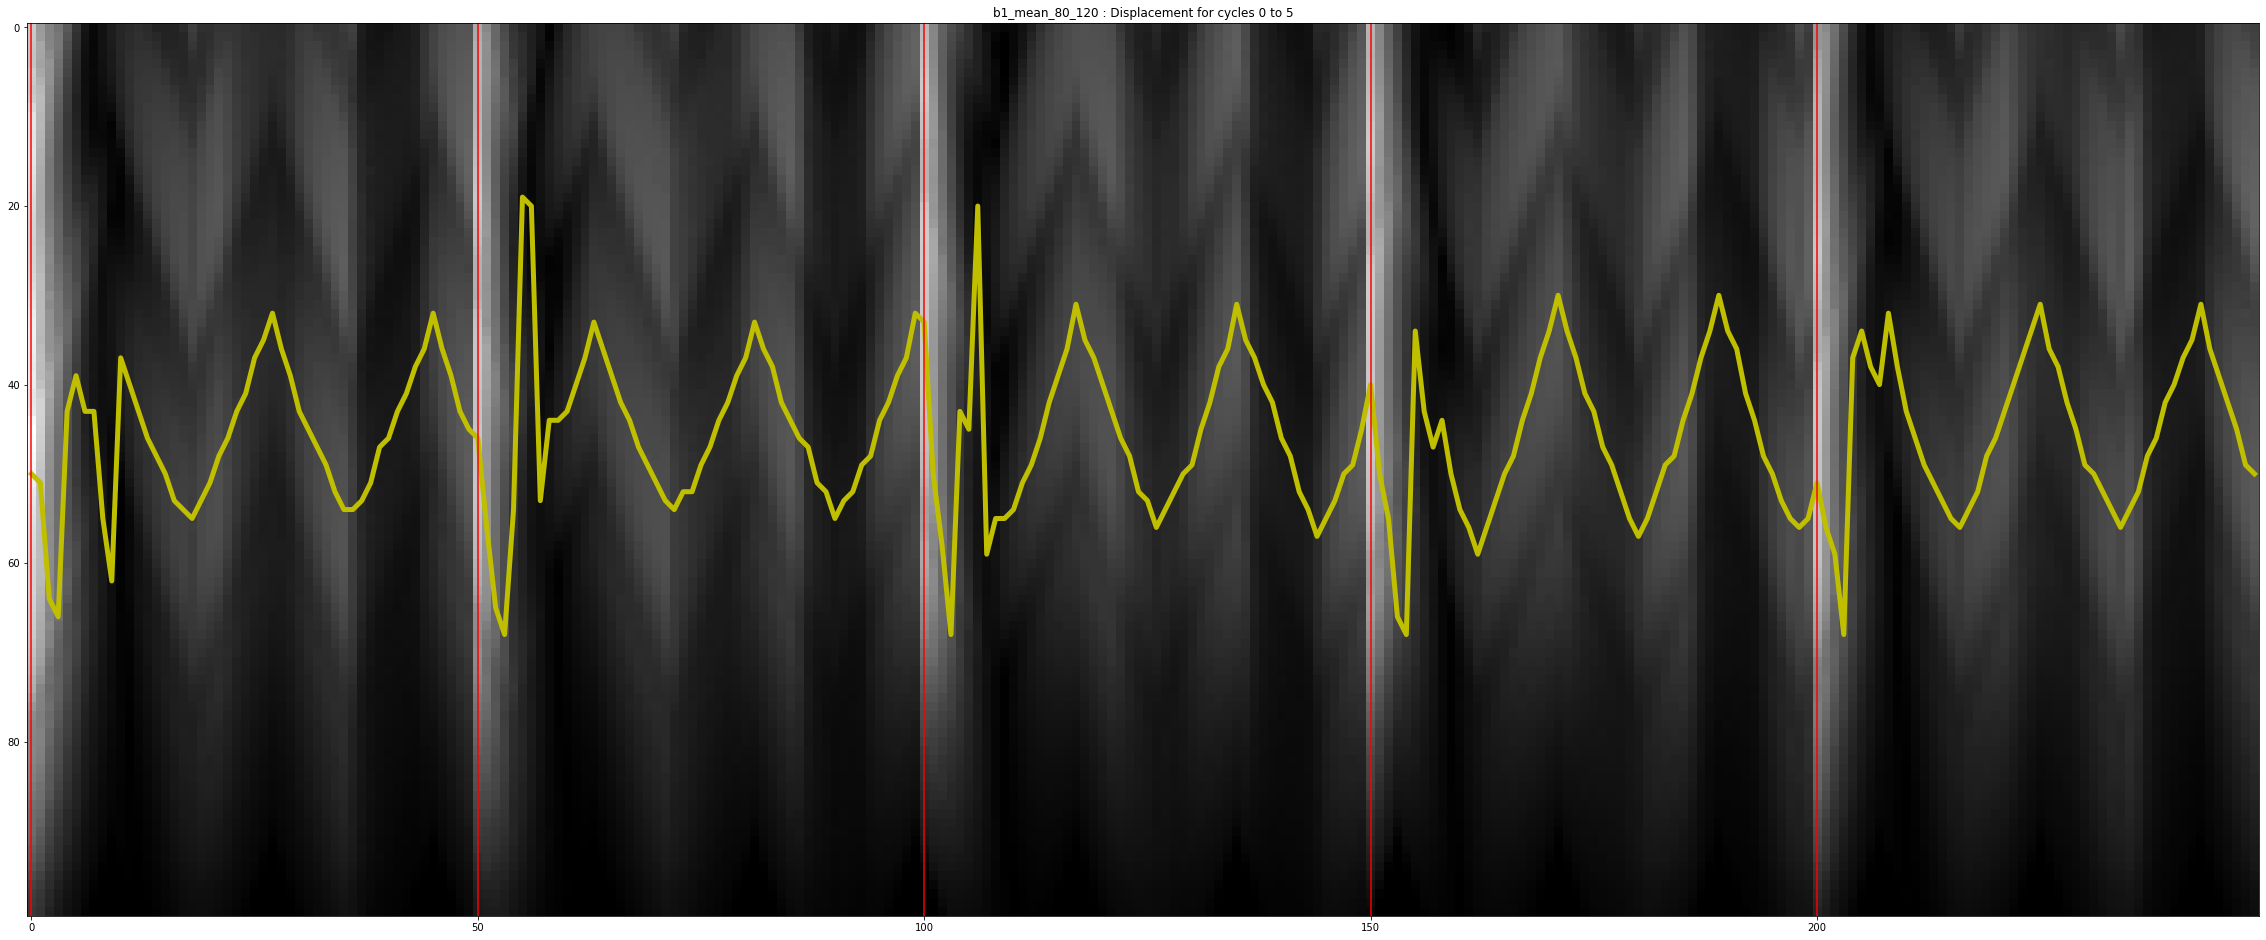

In [217]:
start_cycle = 0
end_cycle=5
plot_all_displacements_vs_images(start_cycle,end_cycle,pixel_start,bottom_plot,top_plot,serie=["b1_mean"])

Conclusion :
For larger windows, the pattern does not seem to follow the movement accurately - smaller amplitude. However might be enough for our purpose as whats important is relative movement ?

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(800, 400)


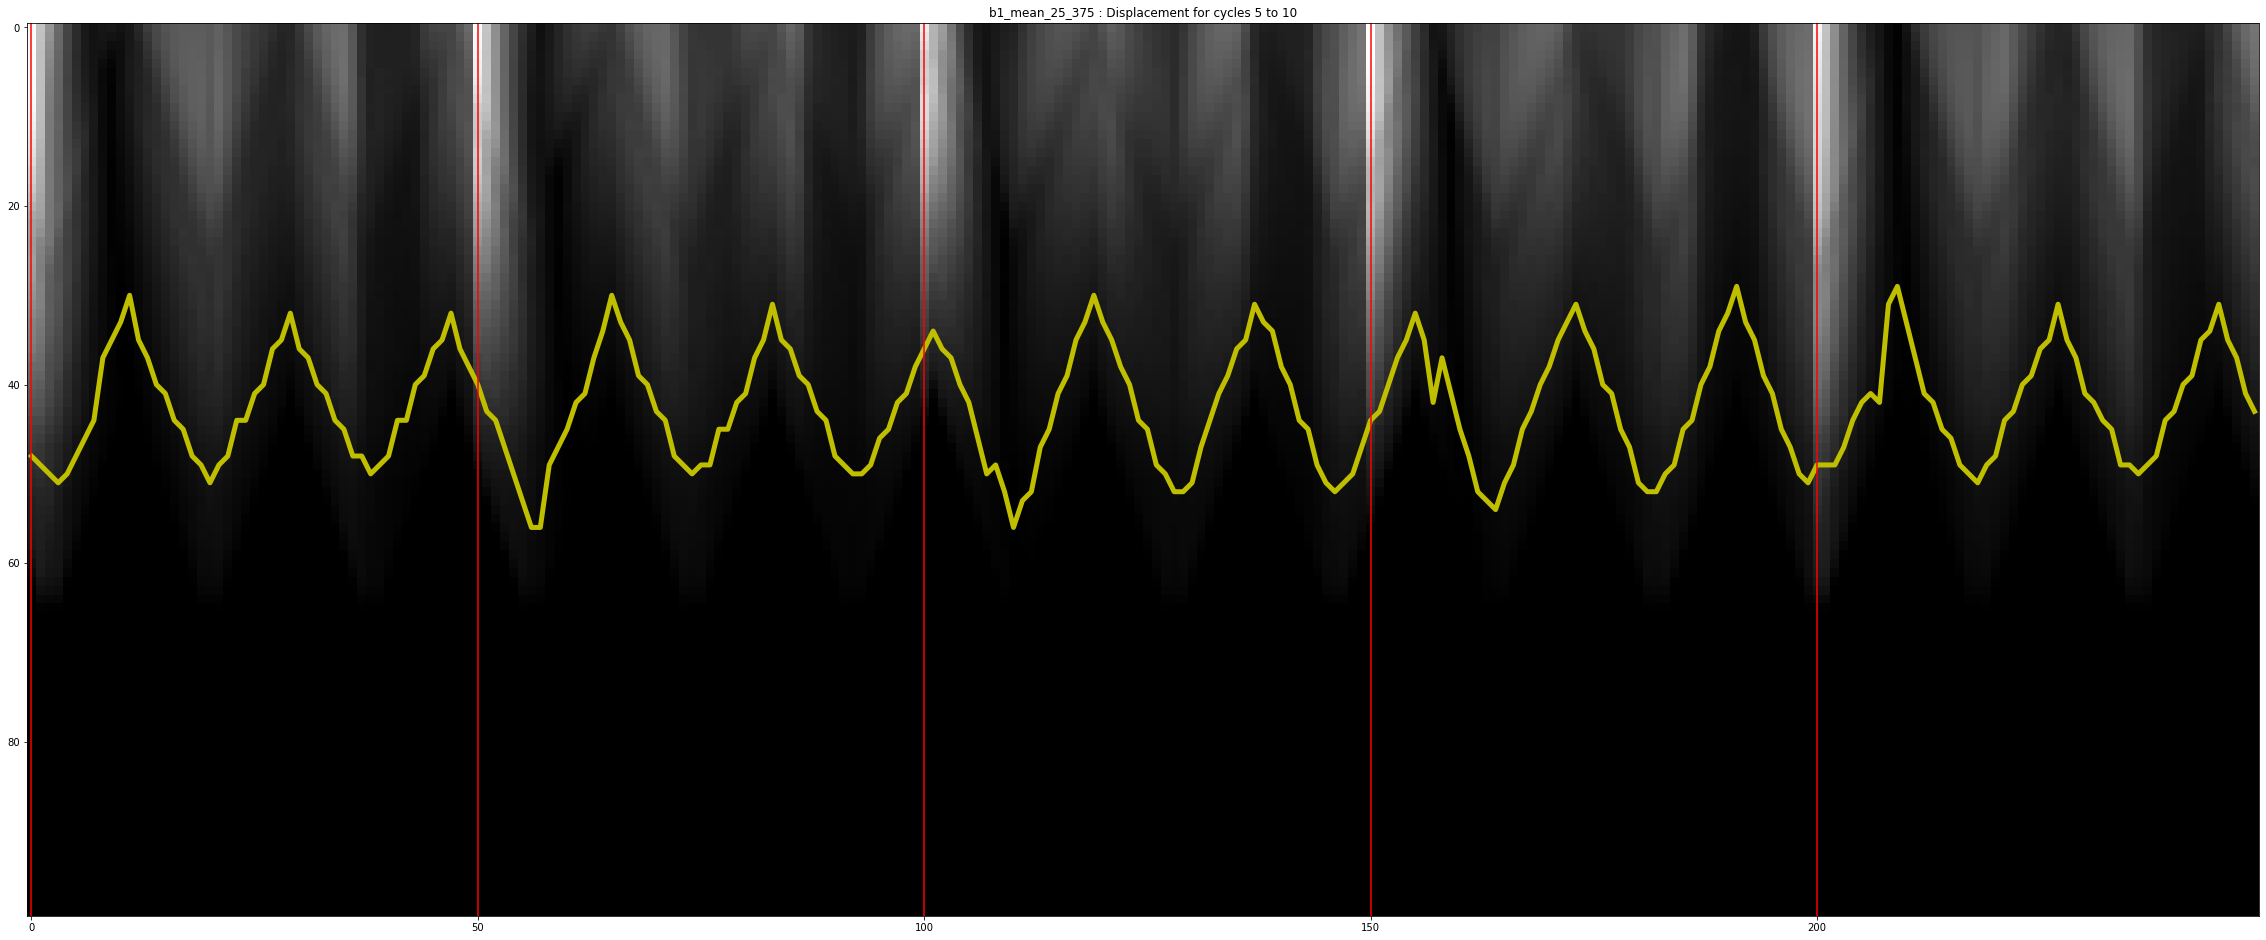

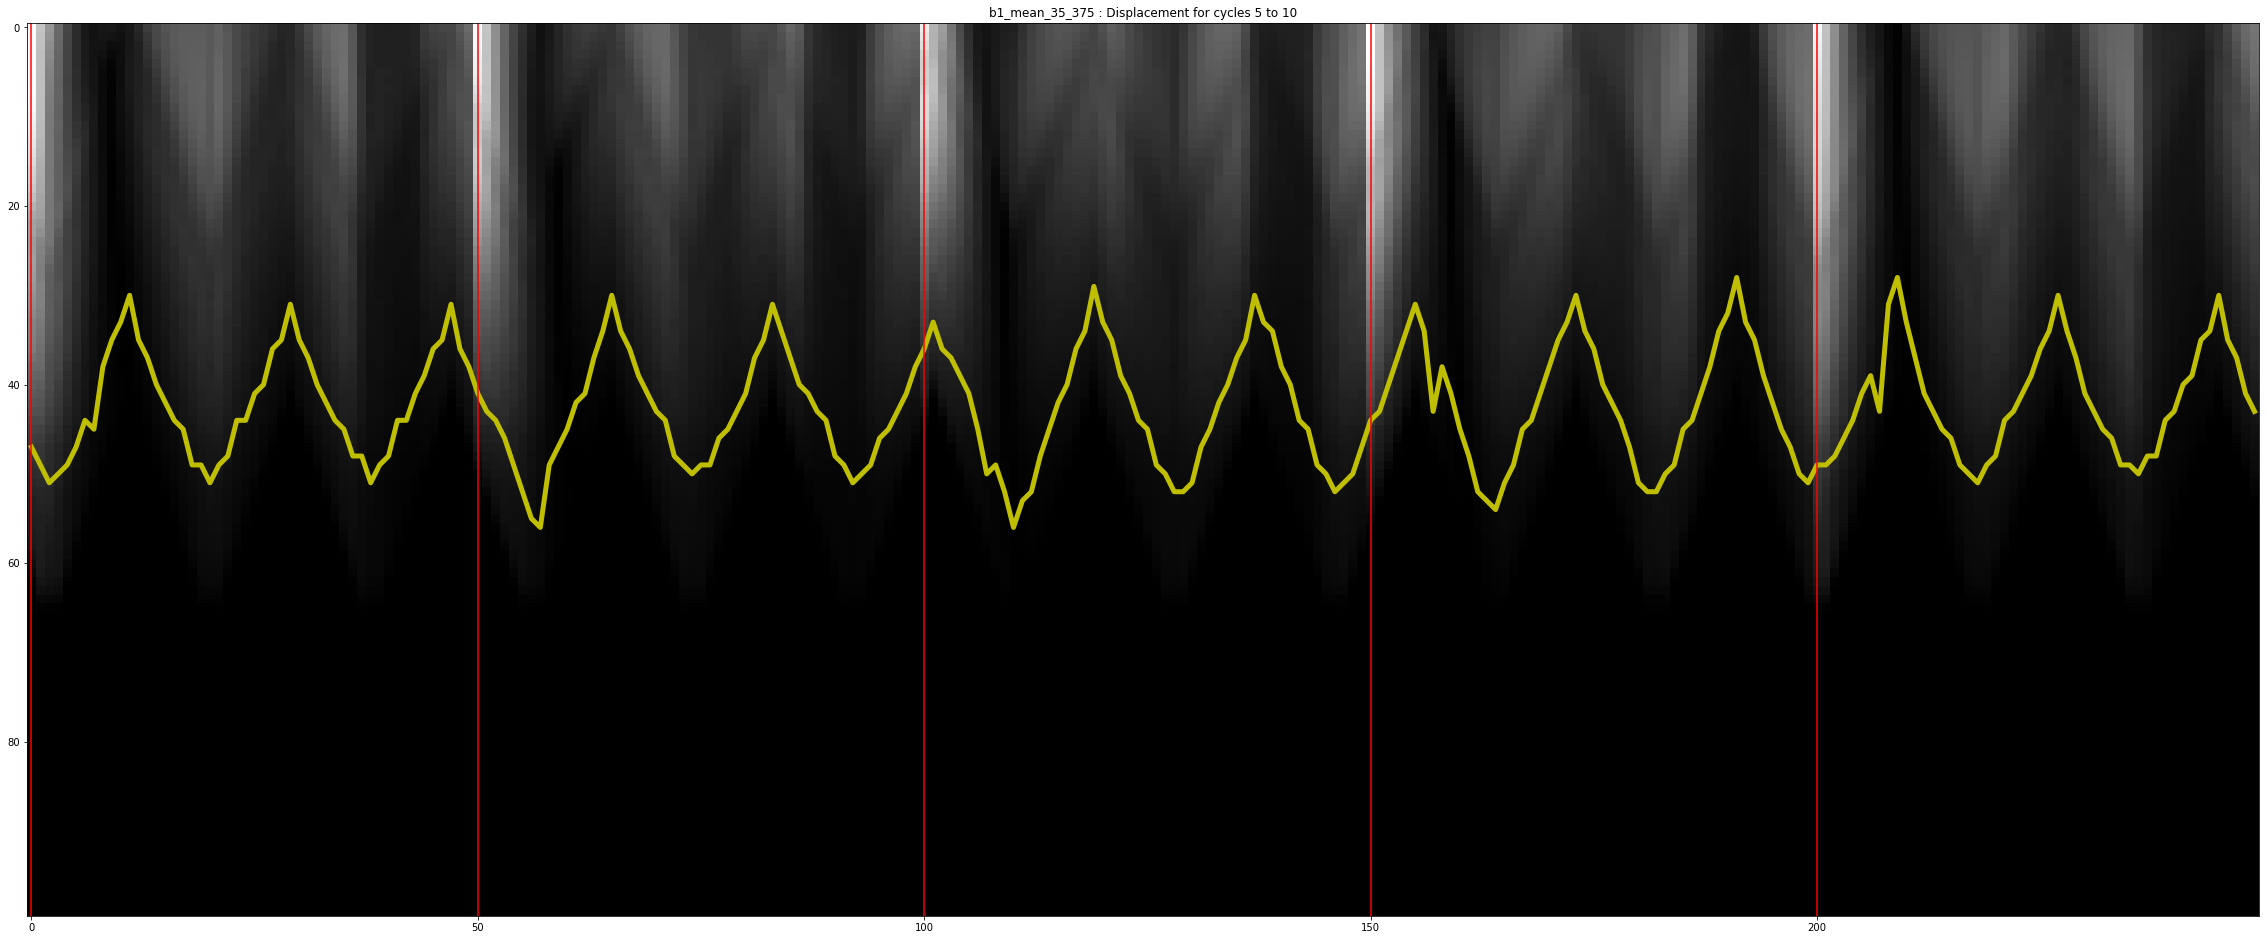

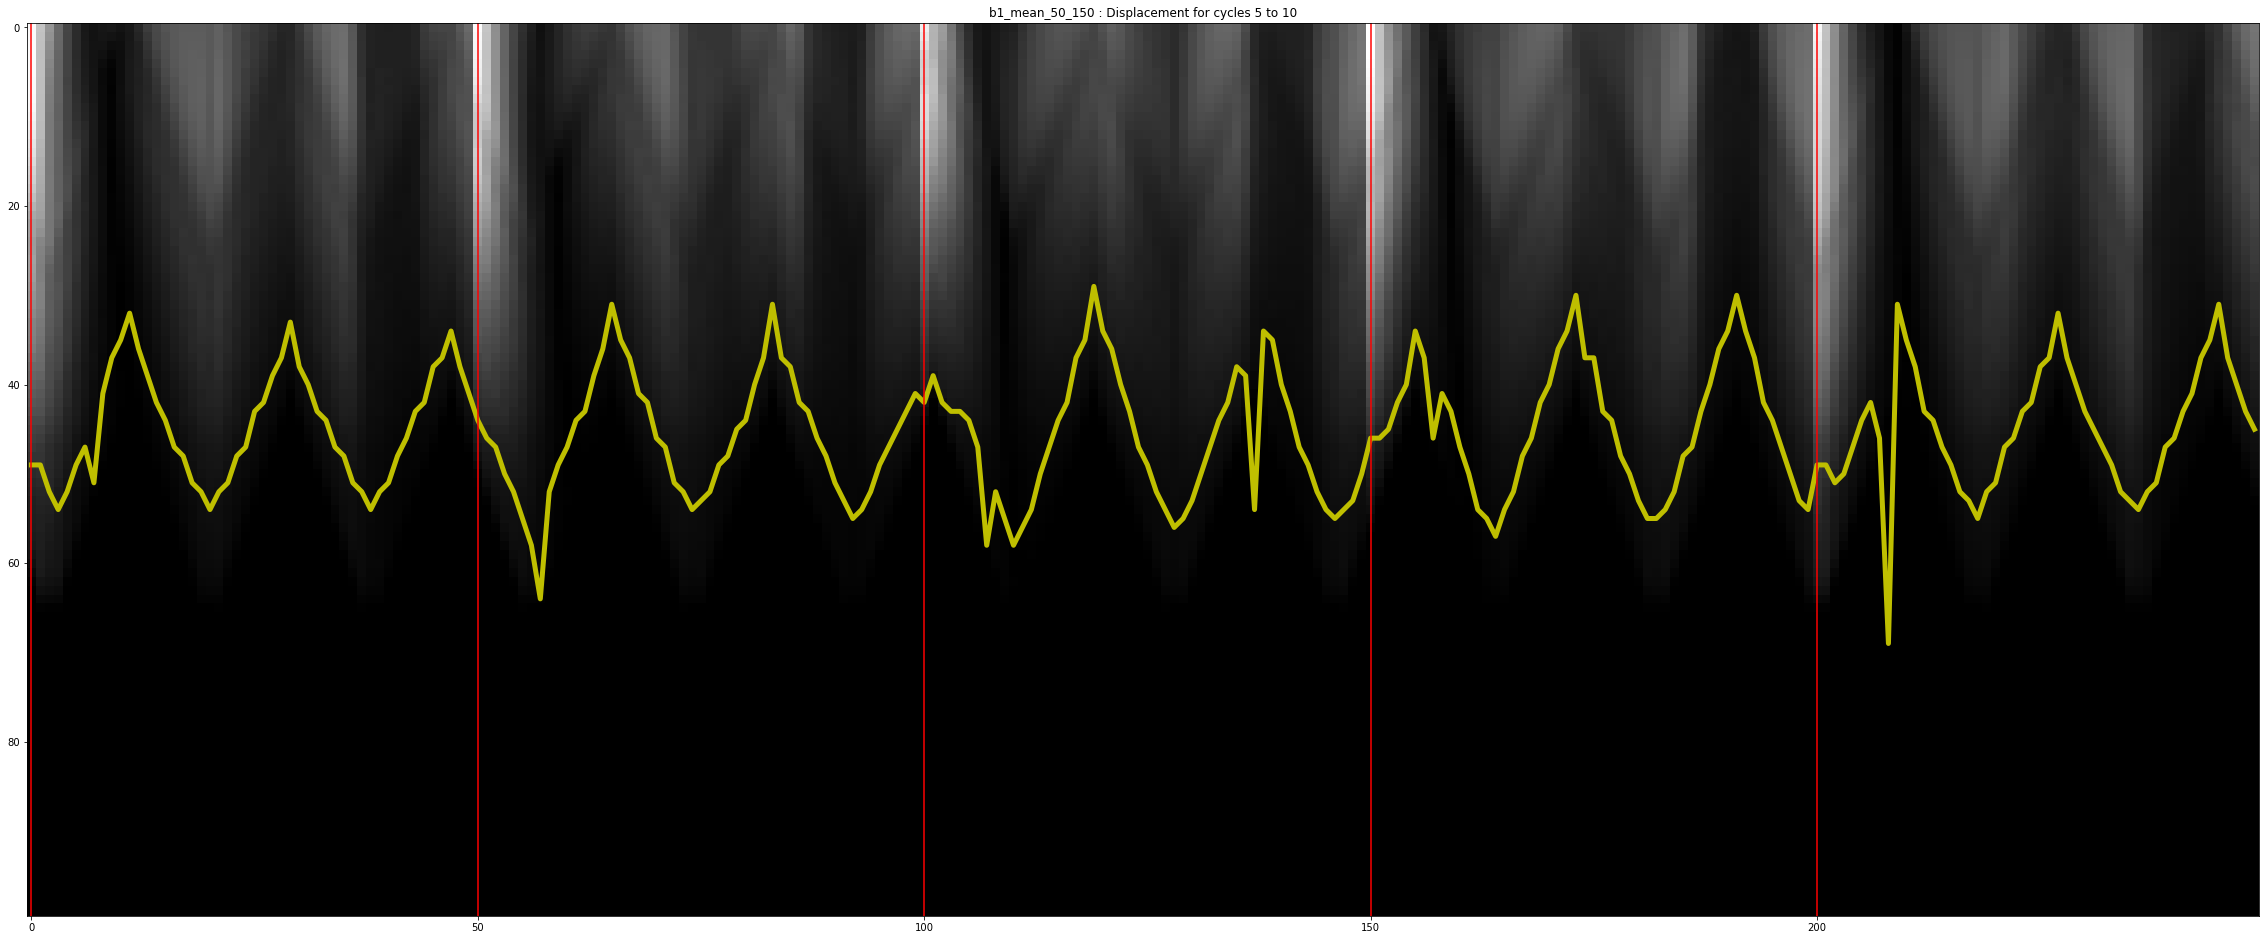

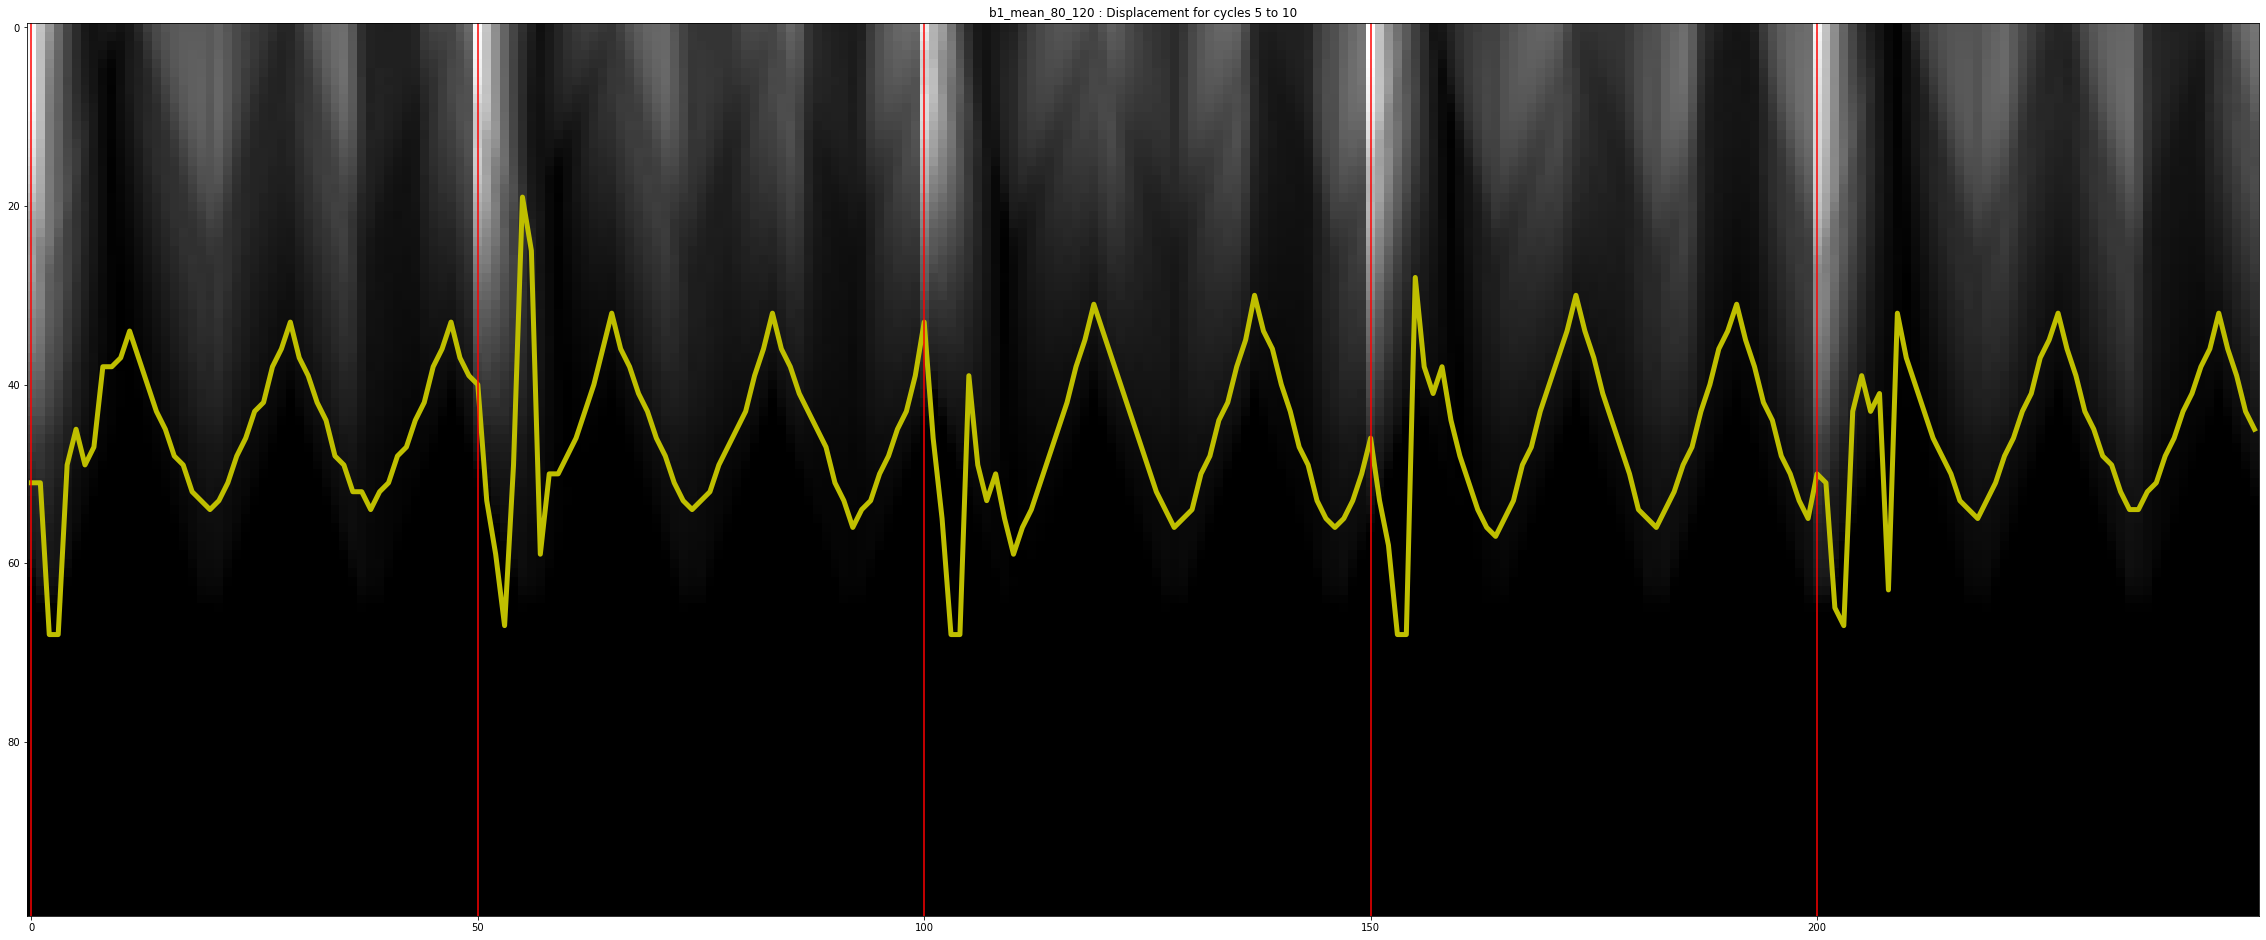

In [219]:
start_cycle = 5
end_cycle=10
plot_all_displacements_vs_images(start_cycle,end_cycle,150,100,200,serie=["b1_mean"])